In [1]:
import time
import sys
import math
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def the_ratio(n, k):
    m = 1
    for i in range(1, n):
        m = m * (k + i)
    m = round(m / math.factorial(n - 1))
    return m


def genset_k_do_increment(k, X):
    a = np.shape(X)
    lastNZ = np.amax(np.matmul((X>0), np.diag(range(1, k+1))), axis=1)
    b = np.shape(lastNZ)
    k1lastNZ = k+1-lastNZ
    Y = np.repeat(X,k1lastNZ, axis=0)
    c = np.shape(Y)
    idxY = 1
    for q in range(1,a[0]+1):
        cs = lastNZ[q-1]
        for c in range(cs,k+1):
            Y[idxY+c-cs-1,c-1] += 1
        idxY = idxY + k+1-cs
    return Y


def genset_k_by_inc(n, k):
    m = the_ratio(n, k)

    X = np.zeros((m, n), dtype=np.int8, order='C')
    for i in range(0, n):
        X[i][i] = 1
    sm = 1 
    mX = the_ratio(n, sm)
    while (sm < k):
        tm = time.time()
        sm = sm + 1
        mX1 = the_ratio(n, sm)
        X[0:mX1-1, :] = genset_k_do_increment(n, X[0:mX - 1, :])
        mX = mX1
        print("iteration:%i -- %.2f [s]" % (k - sm, time.time() - tm))
        
    X[-1,-1] = X[0,0]
    return X


def generate_dataset(n, k):
    start_time = time.time()
    print("Generating simplex data",end='')
    print('\n')
    X = genset_k_by_inc(n, k)
    print(" -- Done")

    mn = np.shape(X)
    print(np.sum(X[0, :]))
    print(mn)
    print("GenSimpBIN: %.2f [s]" % (time.time() - start_time))
    return X


def save_bin_dataset(X, fname):
    start_time = time.time()
    print("Saving BIN file: %s" % fname, end='')
    with open(fname, 'wb') as f:
        pickle.dump(X, f)
    print("SaveBIN: %.2f [s]" % (time.time() - start_time))
    print(" -- Done")


def save_txt_dataset(X, fname):
    start_time = time.time()
    print("Saving TXT file: %s" % fname, end='')
    np.savetxt(fname, X, fmt='%i')
    print(" -- Done")
    print("SaveTXT: %.2f [s]" % (time.time() - start_time))


def load_bin_dataset(fname):
    print("Loading BIN file: %s" % fname, end='')
    with open(fname, 'rb') as f:
        X = pickle.load(f)
    print(" -- Done")

    mn = np.shape(X)
    print(np.sum(X[0, :]))
    print(mn)

    return X


def load_txt_dataset(fname):
    print("Loading TXT file: %s" % fname, end='')
    X = np.loadtxt(fname, dtype=np.int8)
    print(" -- Done")

    mn = np.shape(X)
    print(np.sum(X[0, :]))
    print(mn)

    return X


def get_group_ratio(df):
    df['gr'] = (df.f_tp + df.f_fp + df.f_tn + df.f_fn) / (df.m_tp + df.m_fp + df.m_tn + df.m_fn + df.f_tp + df.f_fp + df.f_tn + df.f_fn)
    return df


def get_imbalance_ratio(df):
    df['ir'] =  (df.f_tp + df.f_fn + df.m_tp + df.m_fn) / (df.f_tn + df.f_fn + df.m_tn + df.m_fn + df.f_fp +df.f_tp + df.m_fp + df.m_tp)
    #IR DLA PRAWDZ KLAS
    return df


def get_men_true_pos_rate(df):
    df['m_tpr'] = df.m_tp/(df.m_tp + df.m_fn)
    return df


def get_females_true_pos_rate(df):
    df['f_tpr'] = df.f_tp/(df.f_tp + df.f_fn)
    return df


#ratio of true positive rates
#equal opportunity
def get_equal_opp_ratio(df):
    df['equal_opp_ratio'] = (df.f_tp/(df.f_tp + df.f_fn)) / (df.m_tp/(df.m_tp + df.m_fn))
    return df


#equal opportunity
#difference of true positive rates
def get_equal_opp_diff(df):
    df['equal_opp_diff'] = df.f_tpr - df.m_tpr
    return df


#each group has the same probability of being classified with positive outcome
#difference of probabilities
def get_statistical_parity(df):
    df["stat_parity"] = (df.f_tp + df.f_fp)/(df.f_tp + df.f_fp + df.f_tn + df.f_fn) - (df.m_tp + df.m_fp)/(df.m_tp + df.m_fp + df.m_tn + df.m_fn)
    return df


#similiar to statistical parity, but using ratio
def get_disparate_impact(df):
    df["disp_impact"] = ((df.f_tp + df.f_fp)/(df.f_tp + df.f_fp + df.f_tn + df.f_fn)) / ((df.m_tp + df.m_fp)/(df.m_tp + df.m_fp + df.m_tn + df.m_fn))
    return df


#accuracy equality ratio
def get_acc_equality_ratio(df):
    df["acc_equality_ratio"] = ((df.f_tp + df.f_tn)/(df.f_tp + df.f_fp + df.f_tn + df.f_fn)) / ((df.m_tp + df.m_tn)/(df.m_tp + df.m_fp + df.m_tn + df.m_fn))
    return df


#accuracy equality difference
def get_acc_equality_diff(df):
    df["acc_equality_diff"] = ((df.f_tp + df.f_tn)/(df.f_tp + df.f_fp + df.f_tn + df.f_fn)) - ((df.m_tp + df.m_tn)/(df.m_tp + df.m_fp + df.m_tn + df.m_fn))
    return df


#predictive equality ratio
def get_pred_equality_ratio(df):
    df["pred_equality_ratio"] = (df.f_fp/(df.f_fp + df.f_tn)) / (df.m_fp/(df.m_fp + df.m_tn))
    return df


#predictive equality difference
def get_pred_equality_diff(df):
    df["pred_equality_diff"] = (df.f_fp/(df.f_fp + df.f_tn)) - (df.m_fp/(df.m_fp + df.m_tn))
    return df


#predictive parity ratio
def get_pred_parity_ratio(df):
    df["pred_parity_ratio"] = (df.f_tp/(df.f_tp + df.f_fp)) / (df.m_tp/(df.m_tp + df.m_fp))
    return df


#predictive parity difference
def get_pred_parity_diff(df):
    df["pred_parity_diff"] = (df.f_tp/(df.f_tp + df.f_fp)) - (df.m_tp/(df.m_tp + df.m_fp))
    return df


def create_heatmap(df, fair_measure):
    plt.clf()

    li = sns.color_palette("light:b", as_cmap=True)

    df1 = df.groupby(['ir', fair_measure]).size().reset_index(name='counts')
    ir_counts = df1.groupby(['ir'])['counts'].sum().reset_index(name='ir_counts')
    df1 = pd.merge(df1, ir_counts, on='ir', how='left')
    df1['probability'] = df1.counts / df1.ir_counts

    heatm = sns.histplot(df1, x="ir", y=fair_measure, weights="probability", binwidth=(0.0625, 0.05), cmap=li)
     
    norm = plt.Normalize(df1['probability'].min(), df1['probability'].max())
    sm = plt.cm.ScalarMappable(cmap=li, norm=norm)
    sm.set_array([])

    heatm.figure.colorbar(sm)
    
    fm_name = fm_full_names[fair_measure]
    plt.title(str(fm_name))
    plt.ylabel(f"Fairness Measure - {fm_name}")
    plt.xlabel("Minority Ratio")
    
    fig = heatm.get_figure()
    fig.savefig(f"plots/heatmap_{fair_measure}.png")
    return
    

def create_histogram_ir(df, ir_selected, fair_measure, bins_selected):
    plt.clf()

    df1 = df[df["ir"] == ir_selected]
    df1 = df1[[fair_measure]]
    
    hist = df1.hist(bins=bins_selected)
    
    fm_name = fm_full_names[fair_measure]
    plt.title(str(fm_name) + ' for ir = ' + str(round(ir_selected,2)))
    plt.xlabel(f"Fairness Measure - {fm_name}")
    plt.ylabel("Counts")
    
    fig = hist[0][0].get_figure()
    fig.savefig(f"plots/histogram_{fair_measure}_ir_{round(ir_selected,2)}.png")
    return
    
    
def create_histogram_gr(df, gr_selected, fair_measure, bins_selected):
    plt.clf()

    df1 = df[df["gr"] == gr_selected]
    df1 = df1[[fair_measure]]
    
    hist = df1.hist(bins=bins_selected)
    
    fm_name = fm_full_names[fair_measure]
    plt.title(str(fm_name) + ' for gr = ' + str(round(gr_selected,2)))
    plt.xlabel(f"Fairness Measure - {fm_name}")
    plt.ylabel("Counts")
    
    fig = hist[0][0].get_figure()
    fig.savefig(f"plots/histogram_{fair_measure}_gr_{round(gr_selected,2)}.png")
    return    
        
        
def create_dataframe(nparray, k):
    
    df = pd.DataFrame(nparray, columns=['m_tp', 'm_fp', 'm_tn', 'm_fn', 'f_tp', 'f_fp', 'f_tn', 'f_fn'])
    
    get_group_ratio(df)
    get_imbalance_ratio(df)
    
    df.replace([np.inf, -np.inf], 0, inplace=True)
    
    get_men_true_pos_rate(df)
    get_females_true_pos_rate(df)
    df.replace([np.inf, -np.inf], 0, inplace=True)
    
    # calculate fairness measures
    get_equal_opp_ratio(df)
    get_equal_opp_diff(df)
    get_acc_equality_diff(df)
    get_acc_equality_ratio(df)
    get_statistical_parity(df)
    get_disparate_impact(df)
    get_pred_equality_ratio(df)
    get_pred_equality_diff(df)
    get_pred_parity_ratio(df)
    get_pred_parity_diff(df)
    
    
    df.replace([np.inf, -np.inf], 0, inplace=True)
    df.replace(np.NaN, 0, inplace=True)

    return df





In [2]:
# k - size of set; n -  error matrix combinations
# k should be a multiple of n, (otherwise a potentially incomplete data set is generated)
n = 8
k = n * 2
print('Default params: ', end='')

print('n=%i, k=%i'%(n,k))
prog_start_time = time.time()
bin_fname = "Set(%02i,%02i).bin" % (n, k)

# Data generating
# X = generate_dataset(n, k)

# Data saving - bin
# save_bin_dataset(X, bin_fname)

# Data loading - bin
X = load_bin_dataset(bin_fname)

# Data saving - txt
# txt_fname = "Set(%02i,%02i).txt" % (n, k)
# save_txt_dataset(X, txt_fname)

df = create_dataframe(X, k)

fm_list = ['equal_opp_ratio', 
           'equal_opp_diff', 
           'stat_parity', 
           'disp_impact', 
           'acc_equality_ratio', 
           'acc_equality_diff', 
           'pred_equality_ratio', 
           'pred_equality_diff', 
           'pred_parity_ratio', 
           'pred_parity_diff'
           ]

ir_selected_list = df['ir'].unique().tolist()
gr_selected_list = df['gr'].unique().tolist()

fm_full_names = {
    'equal_opp_ratio': 'Equal Opportunity Ratio',
    'equal_opp_diff': 'Equal Opportunity Difference',
    'stat_parity': 'Statistical Parity',
    'disp_impact': 'Disparate Impact',
    'acc_equality_ratio': 'Accuracy Equality Ratio',
    'acc_equality_diff': 'Accuracy Equality Difference',
    'pred_equality_ratio': 'Predictive Equality Ratio',
    'pred_equality_diff': 'Predictive Equality Difference',
    'pred_parity_ratio': 'Predictive Parity Ratio',
    'pred_parity_diff': 'Predictive Parity Difference'
}

pd.set_option('display.max_columns', None)

Default params: n=8, k=16
Loading BIN file: Set(08,16).bin -- Done
16
(245157, 8)


In [3]:
#     for fm in fm_list:
#         create_heatmap(df, fm)
    #     for ir_selected in ir_selected_list:
    #         create_histogram_ir(df, ir_selected, fm, 100)
    #     for gr_selected in gr_selected_list:
    #         create_histogram_gr(df, gr_selected, fm, 100)
    #for fm in fm_list:
print(df)

        m_tp  m_fp  m_tn  m_fn  f_tp  f_fp  f_tn  f_fn      gr      ir  \
0         16     0     0     0     0     0     0     0  0.0000  1.0000   
1         15     1     0     0     0     0     0     0  0.0000  0.9375   
2         15     0     1     0     0     0     0     0  0.0000  0.9375   
3         15     0     0     1     0     0     0     0  0.0000  1.0000   
4         15     0     0     0     1     0     0     0  0.0625  1.0000   
...      ...   ...   ...   ...   ...   ...   ...   ...     ...     ...   
245152     0     0     0     0     0     0     4    12  1.0000  0.7500   
245153     0     0     0     0     0     0     3    13  1.0000  0.8125   
245154     0     0     0     0     0     0     2    14  1.0000  0.8750   
245155     0     0     0     0     0     0     1    15  1.0000  0.9375   
245156     0     0     0     0     0     0     0    16  1.0000  1.0000   

         m_tpr  f_tpr  equal_opp_ratio  equal_opp_diff  acc_equality_diff  \
0       1.0000    0.0             

----------------------------- equal_opp_ratio -----------------------------


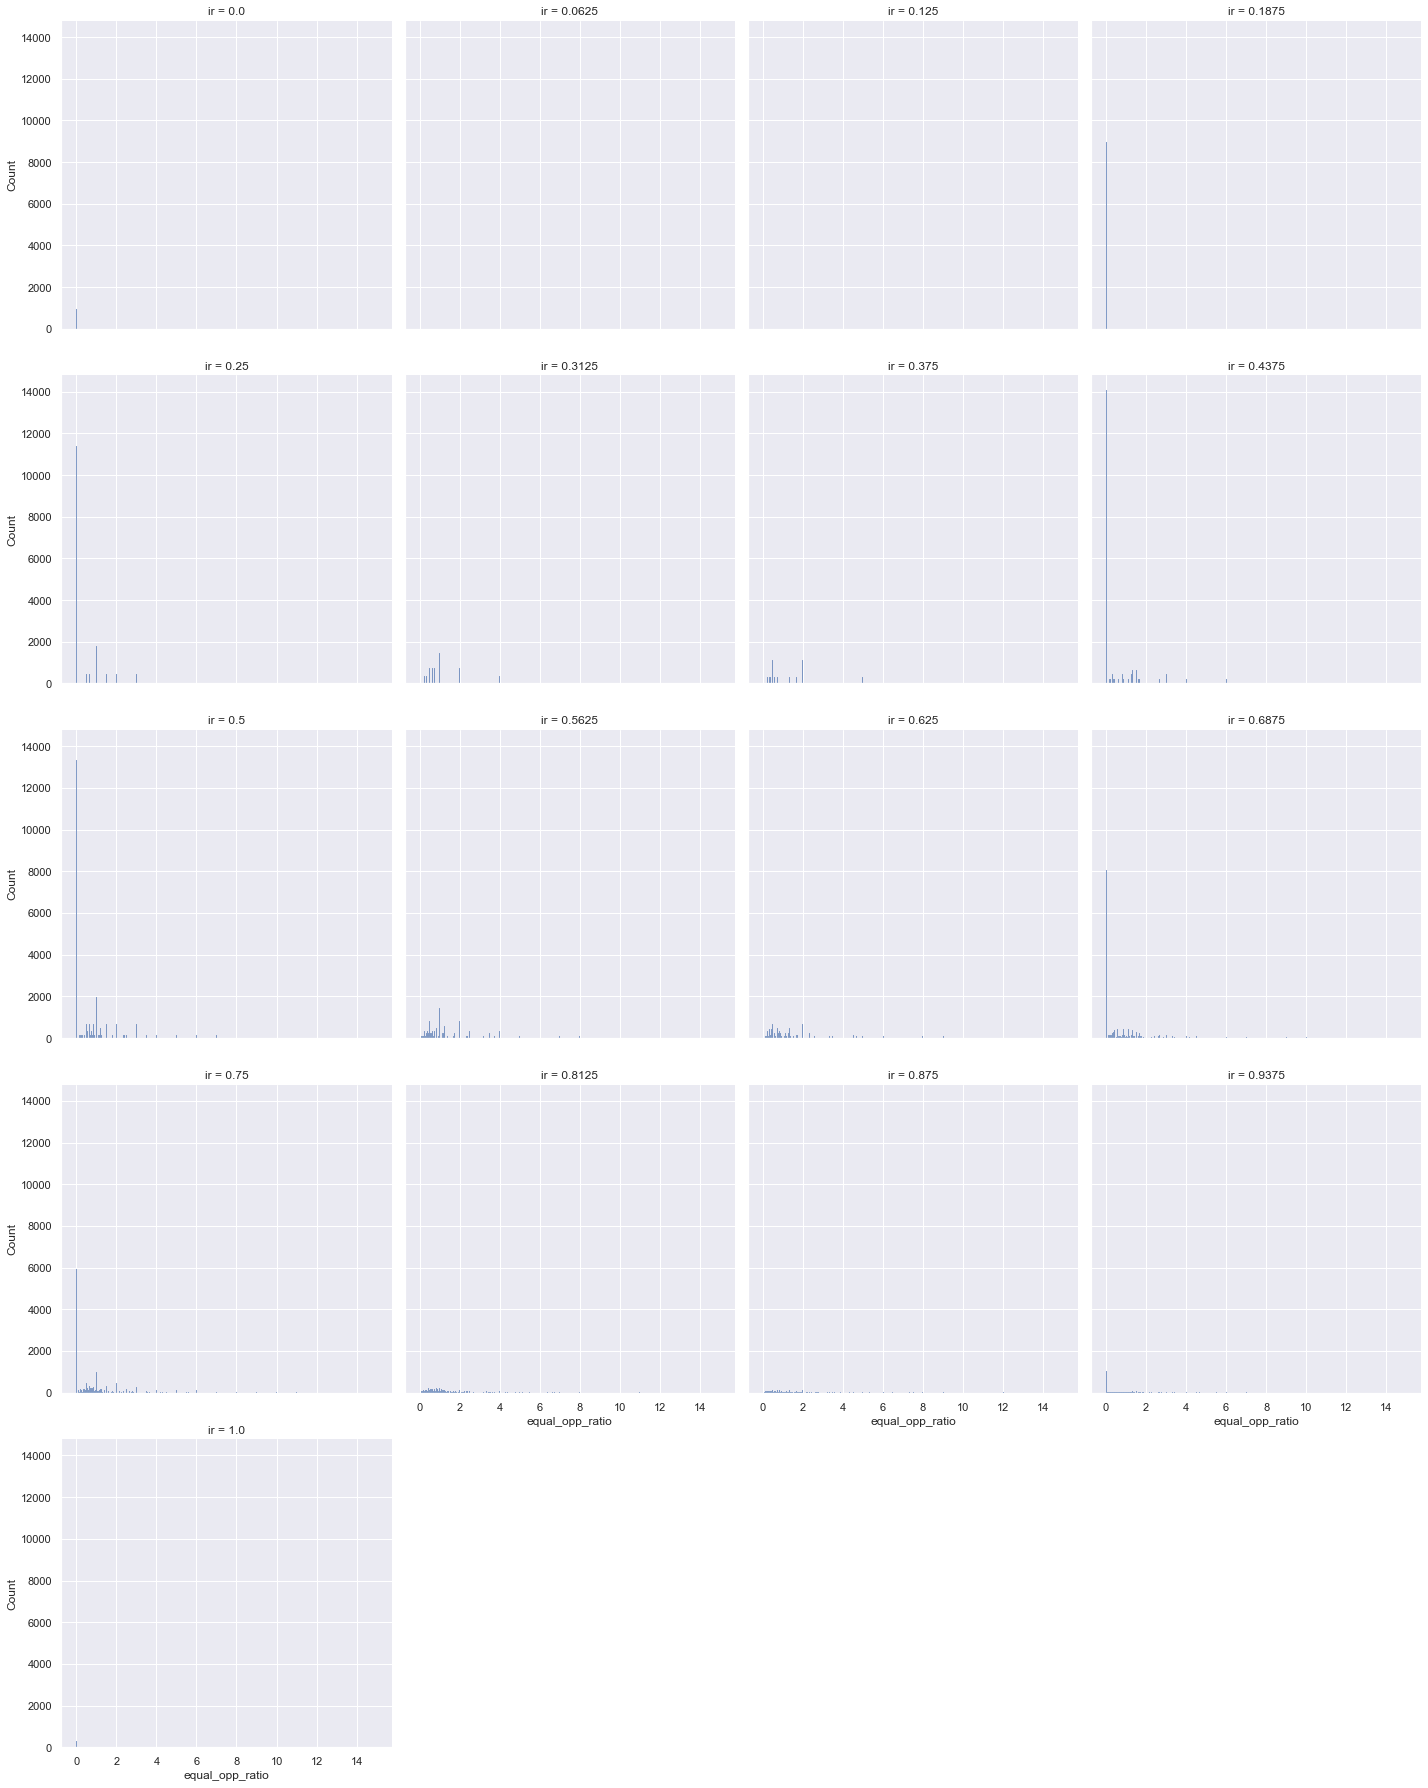

----------------------------- equal_opp_ratio -----------------------------


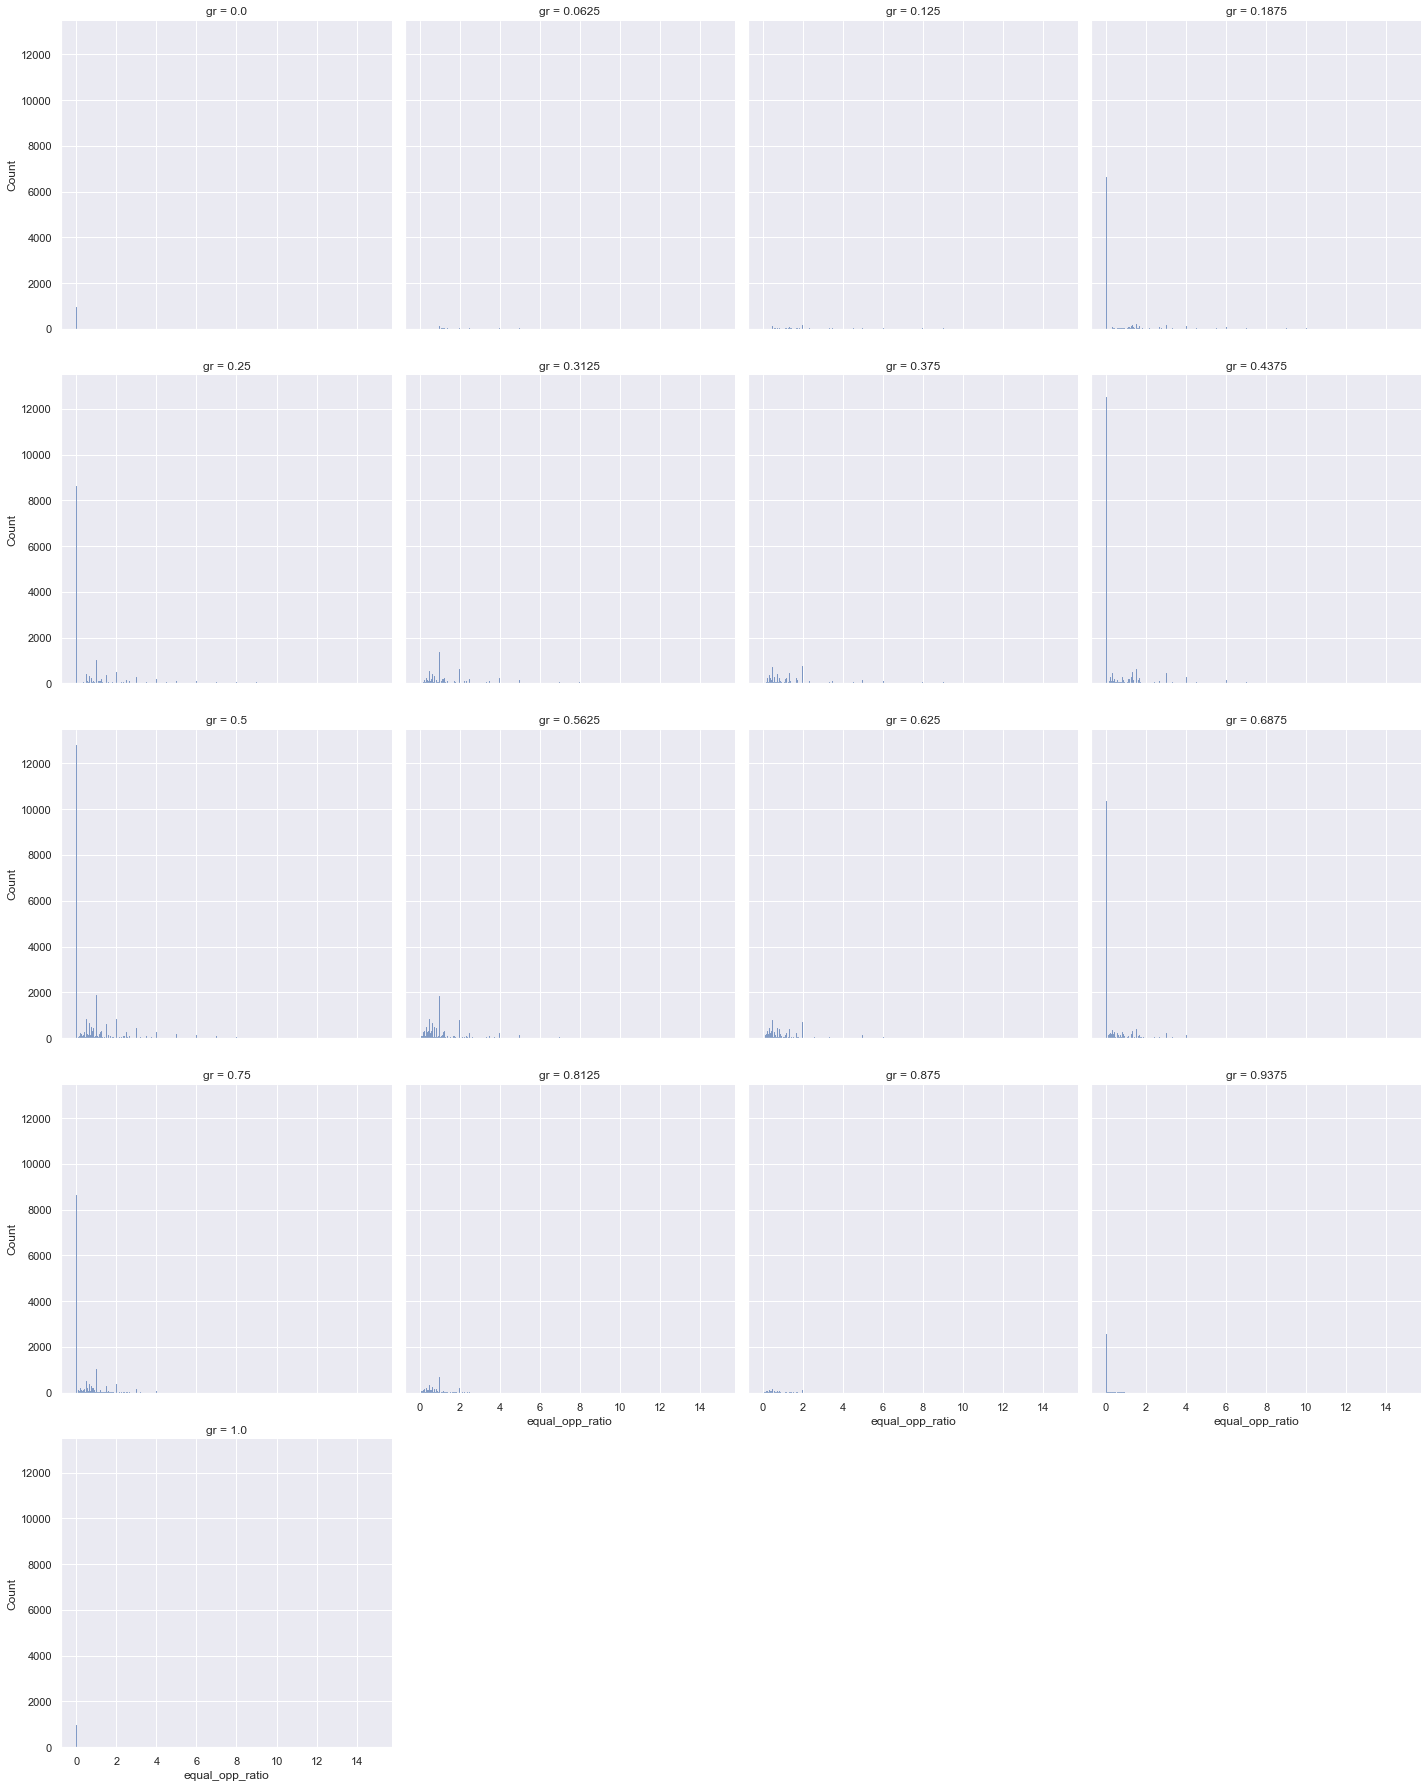

----------------------------- equal_opp_diff -----------------------------


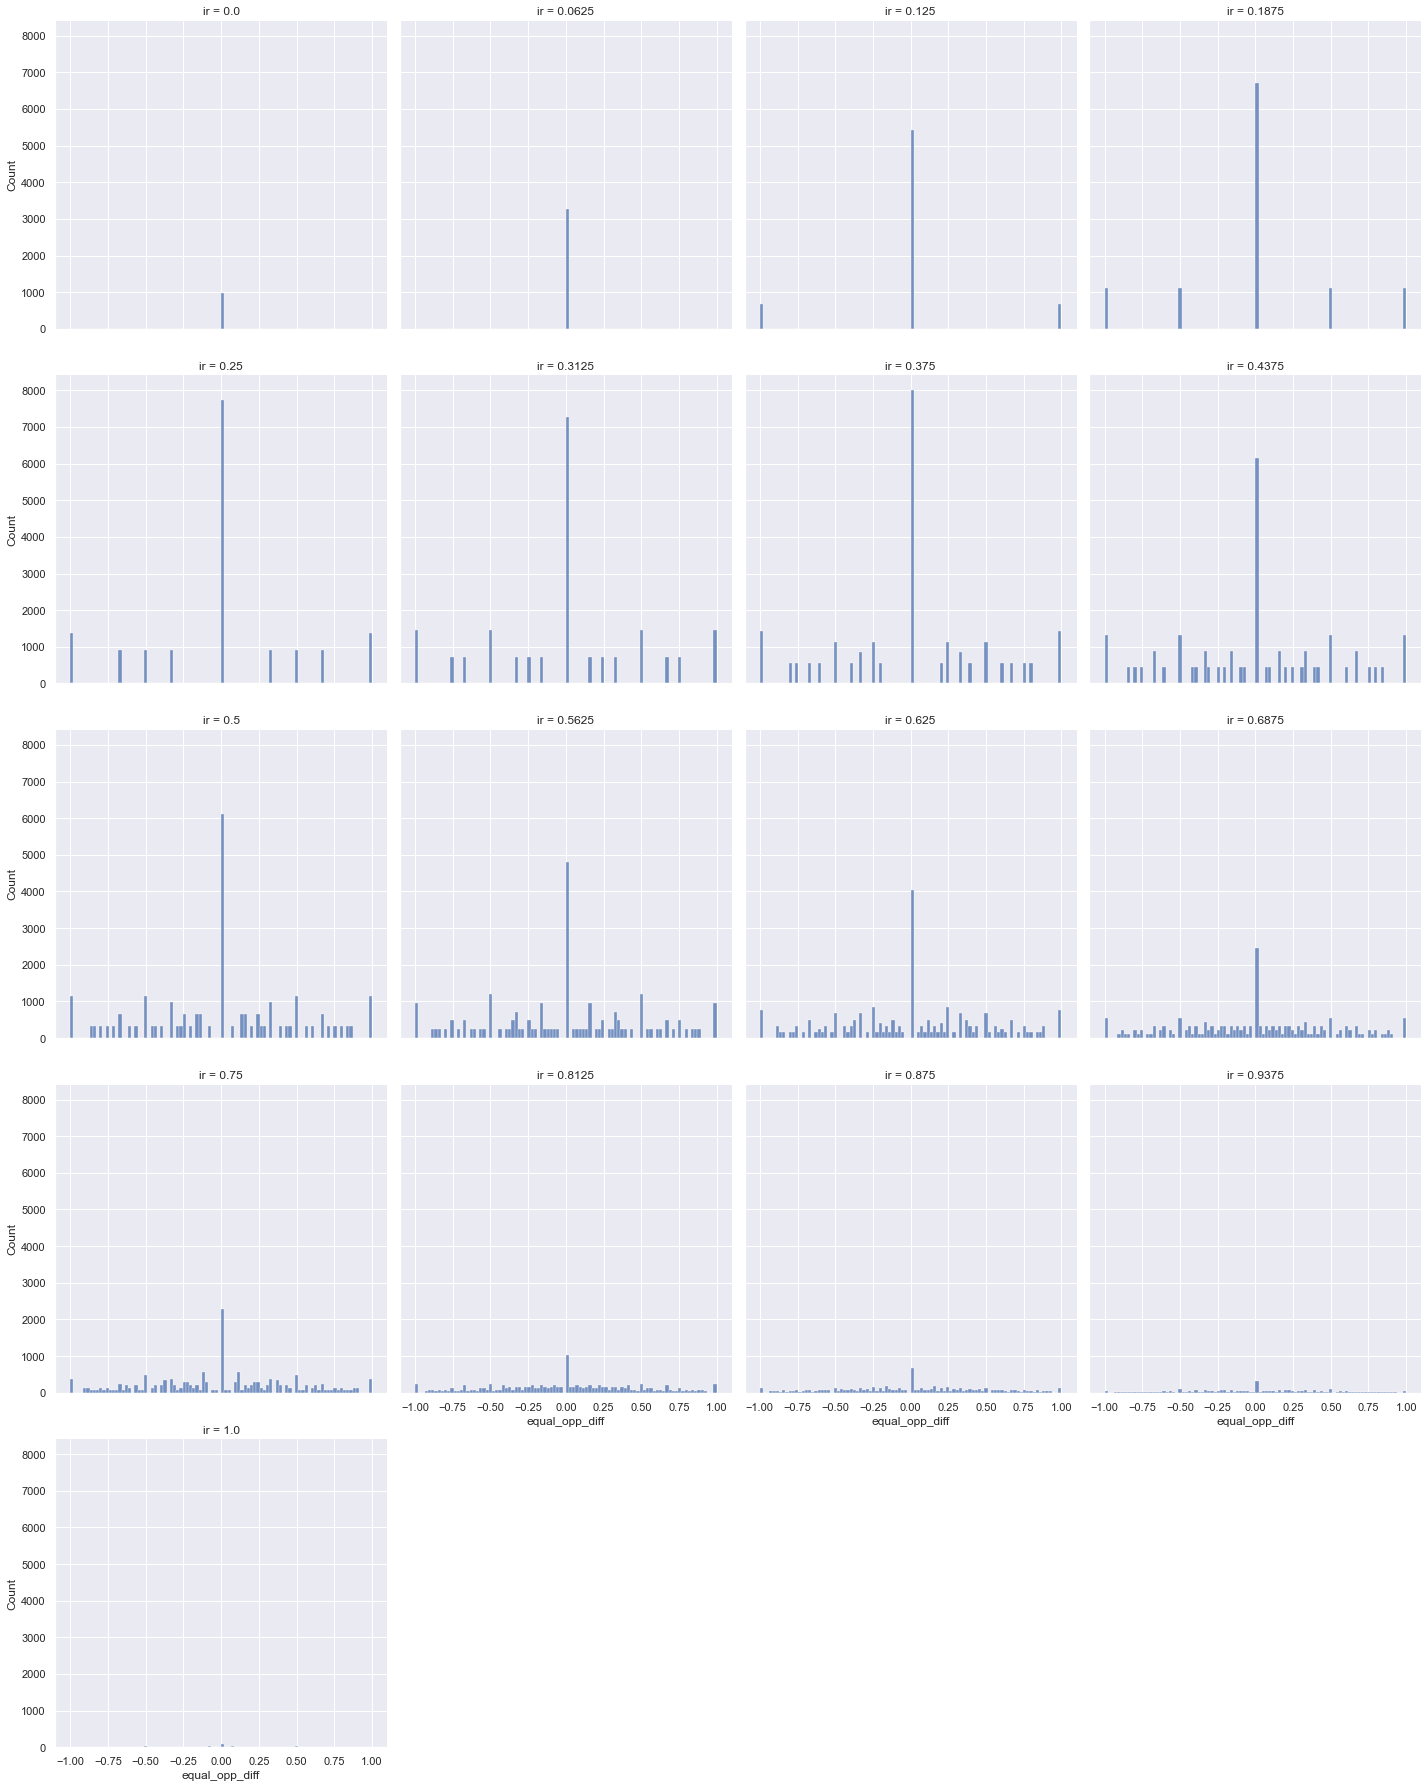

----------------------------- equal_opp_diff -----------------------------


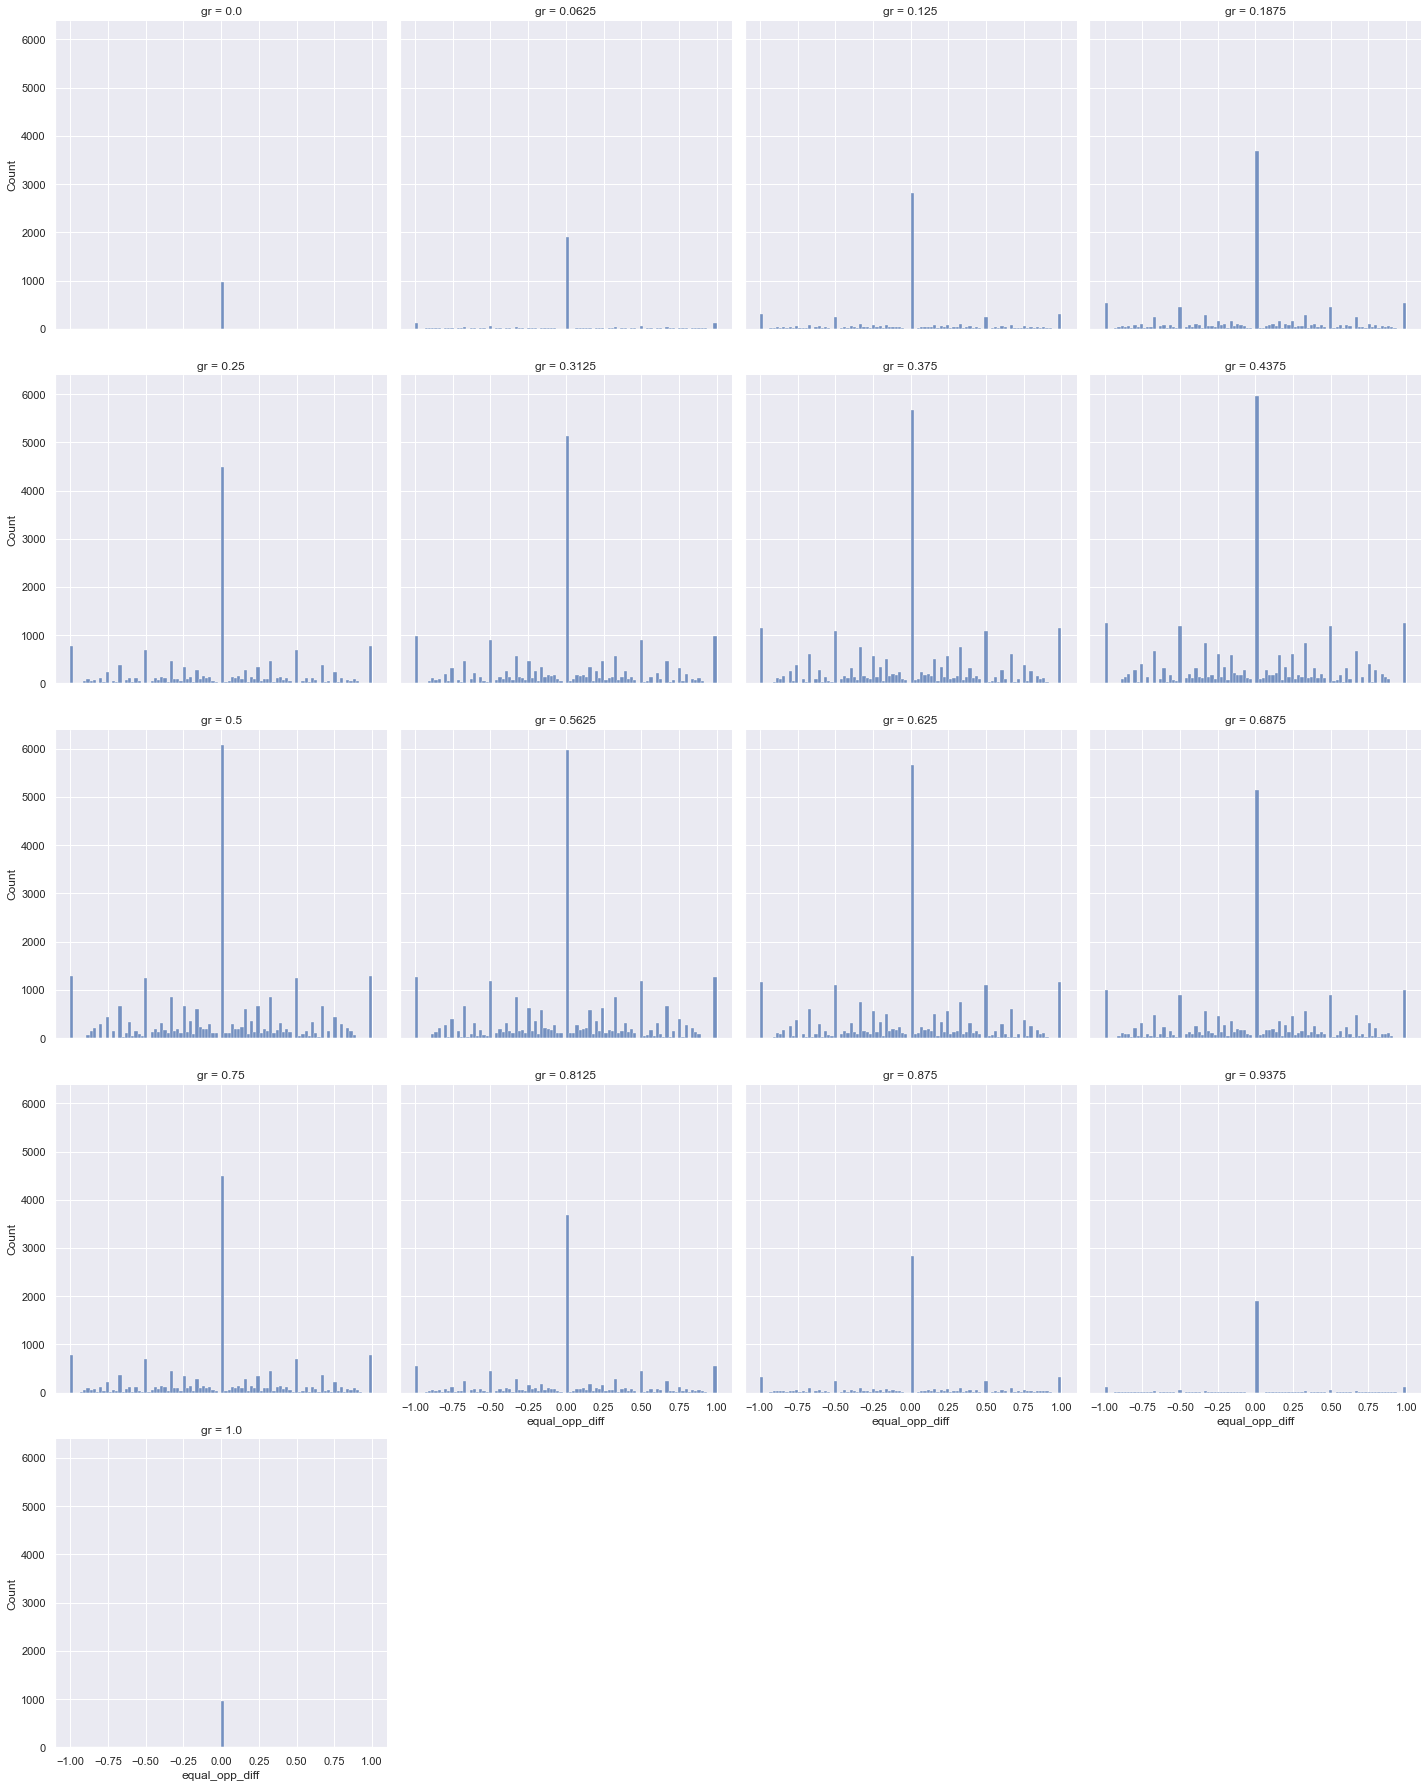

----------------------------- stat_parity -----------------------------


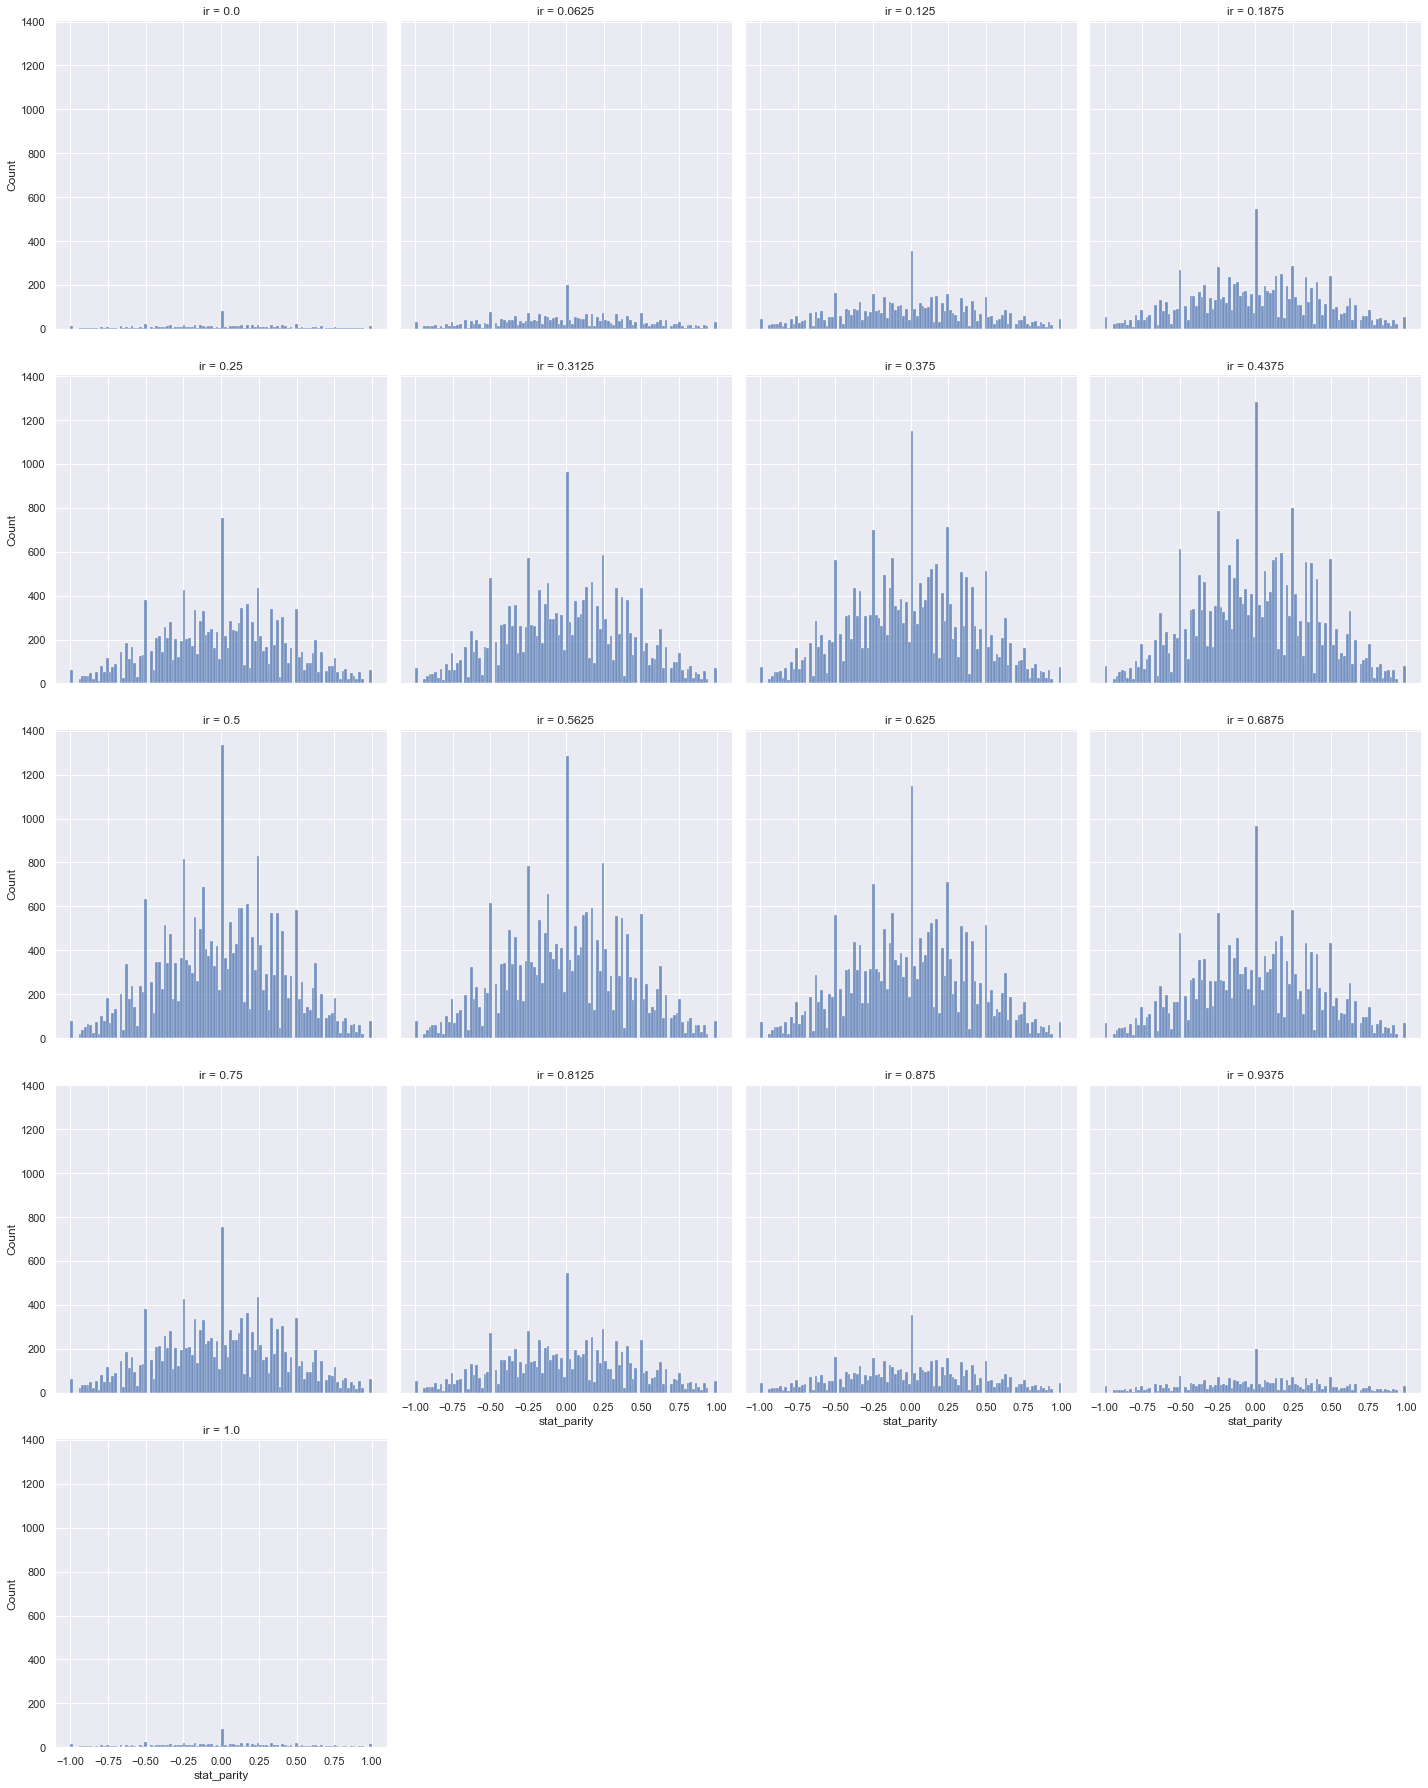

----------------------------- stat_parity -----------------------------


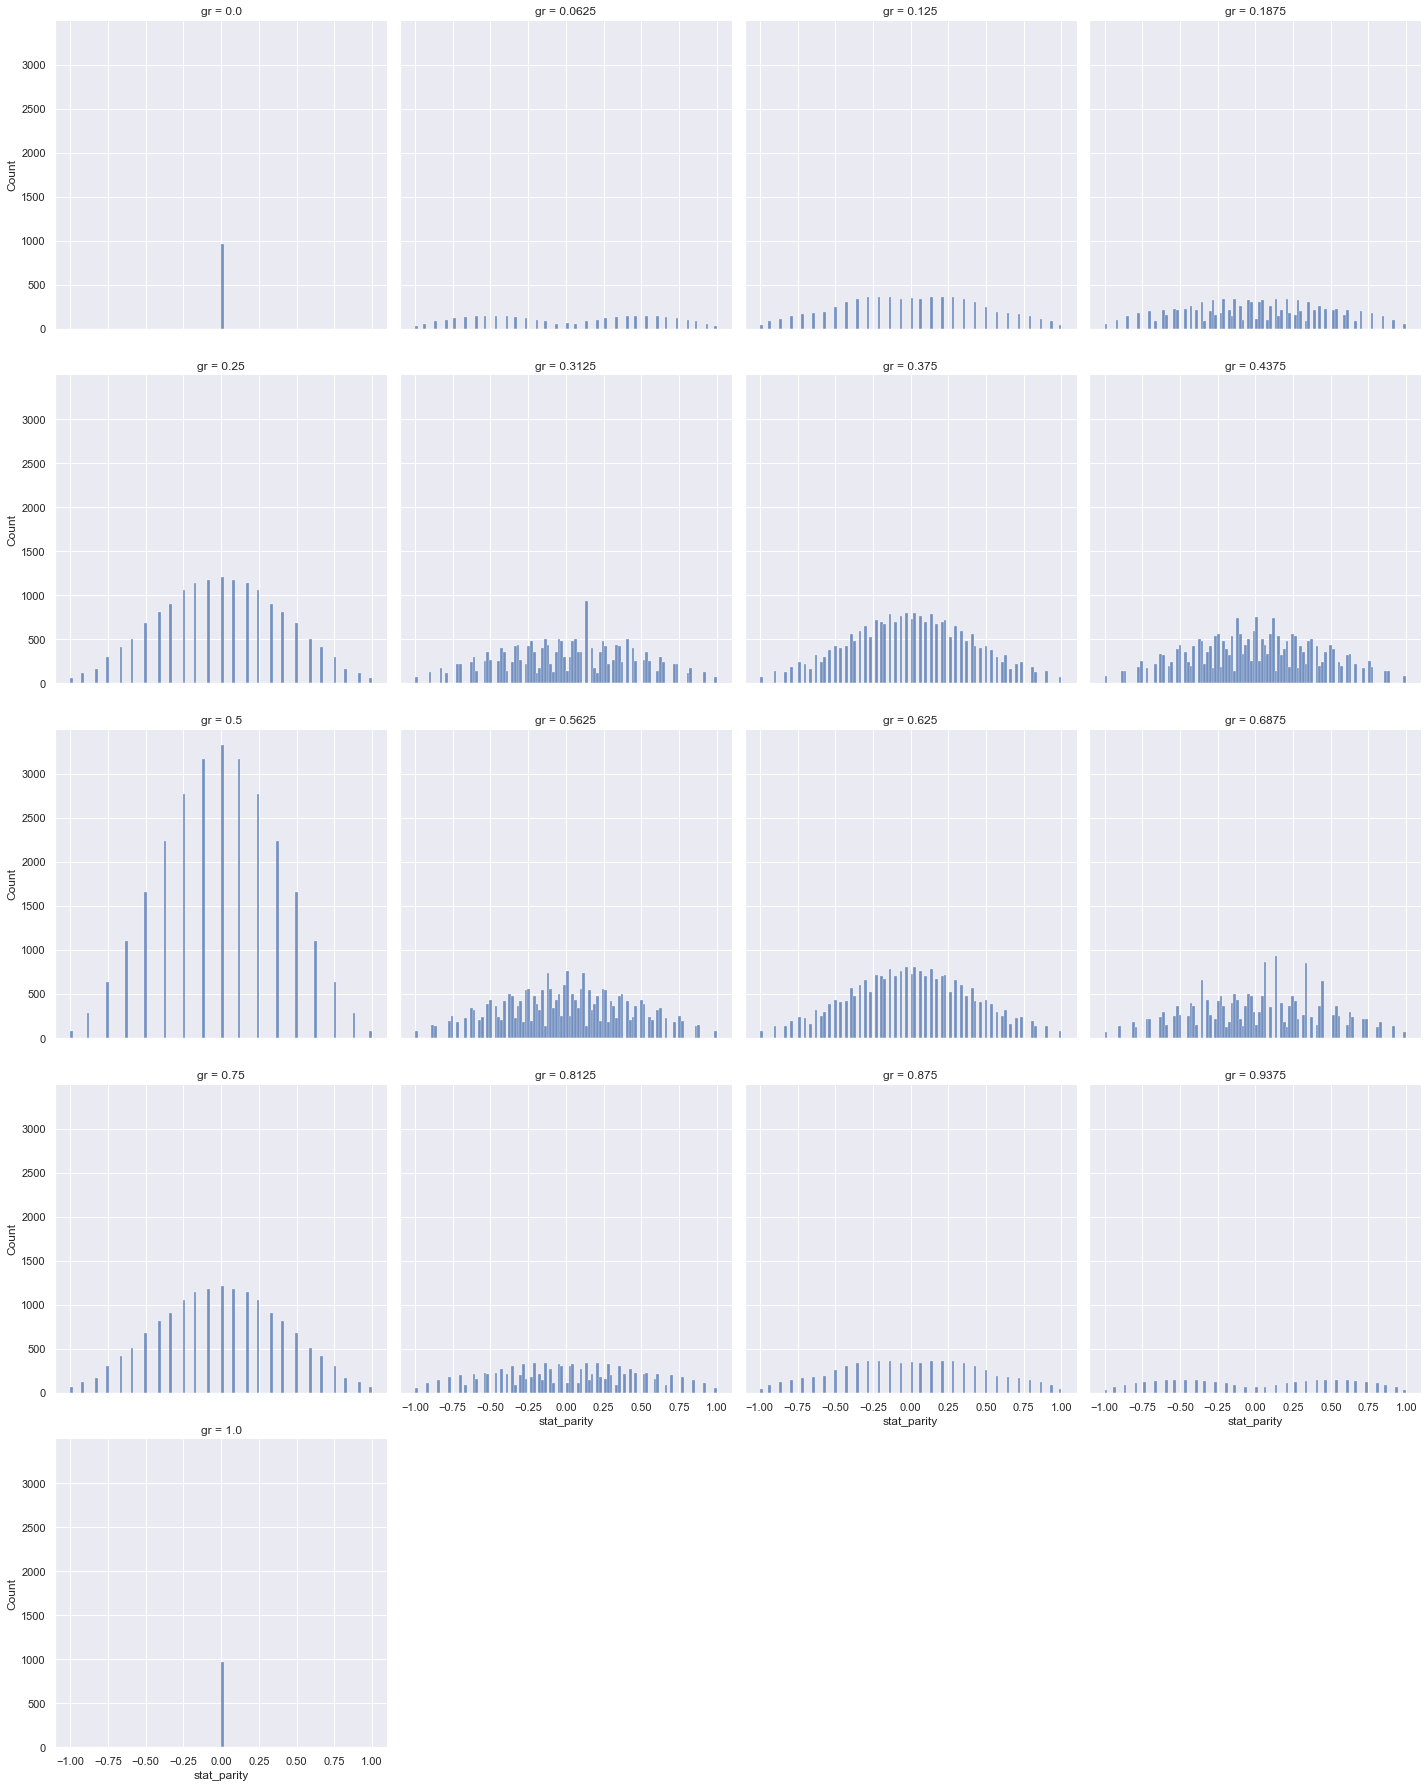

----------------------------- disp_impact -----------------------------


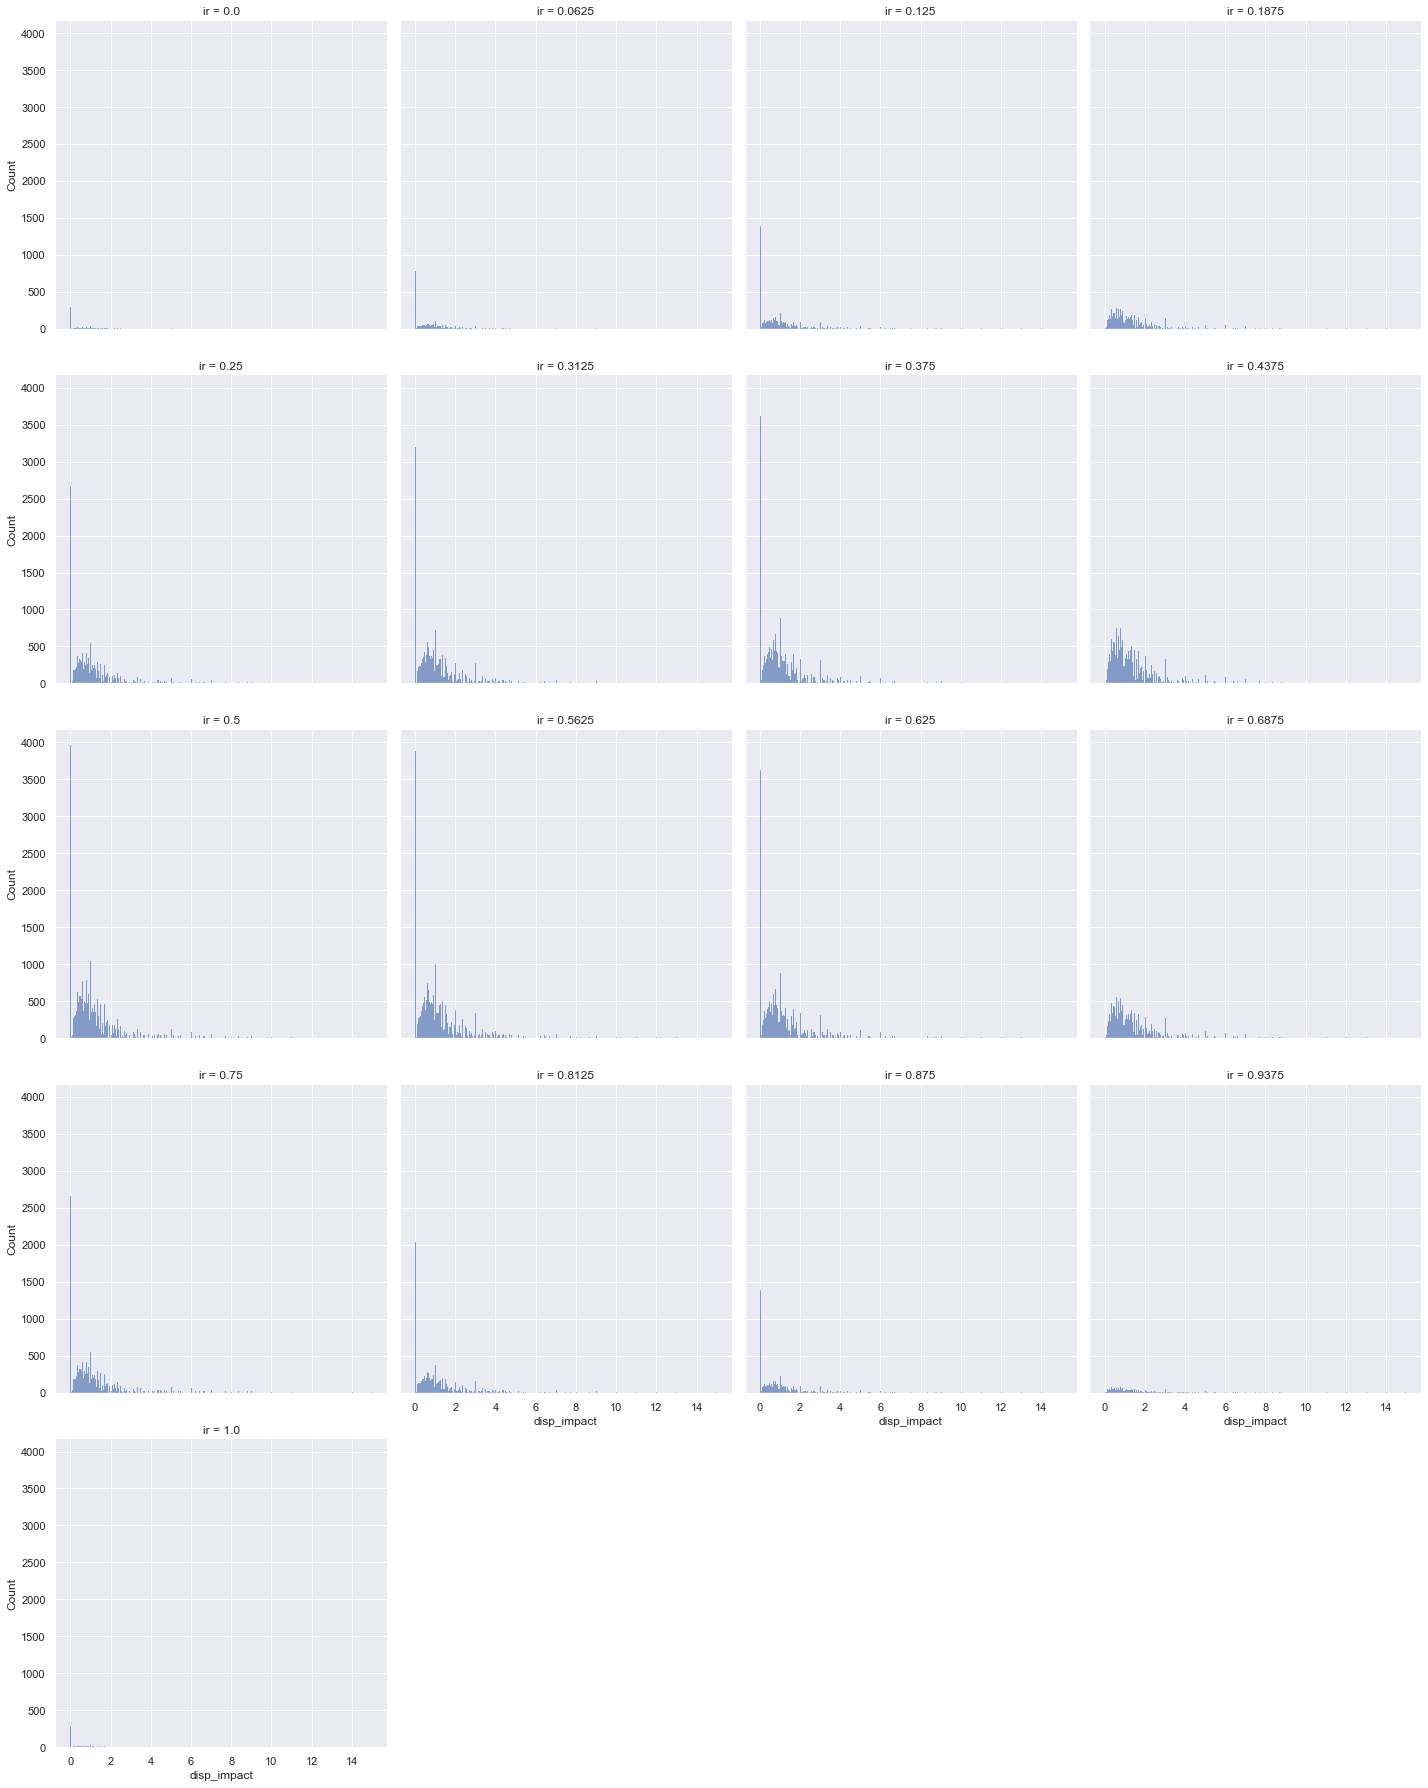

----------------------------- disp_impact -----------------------------


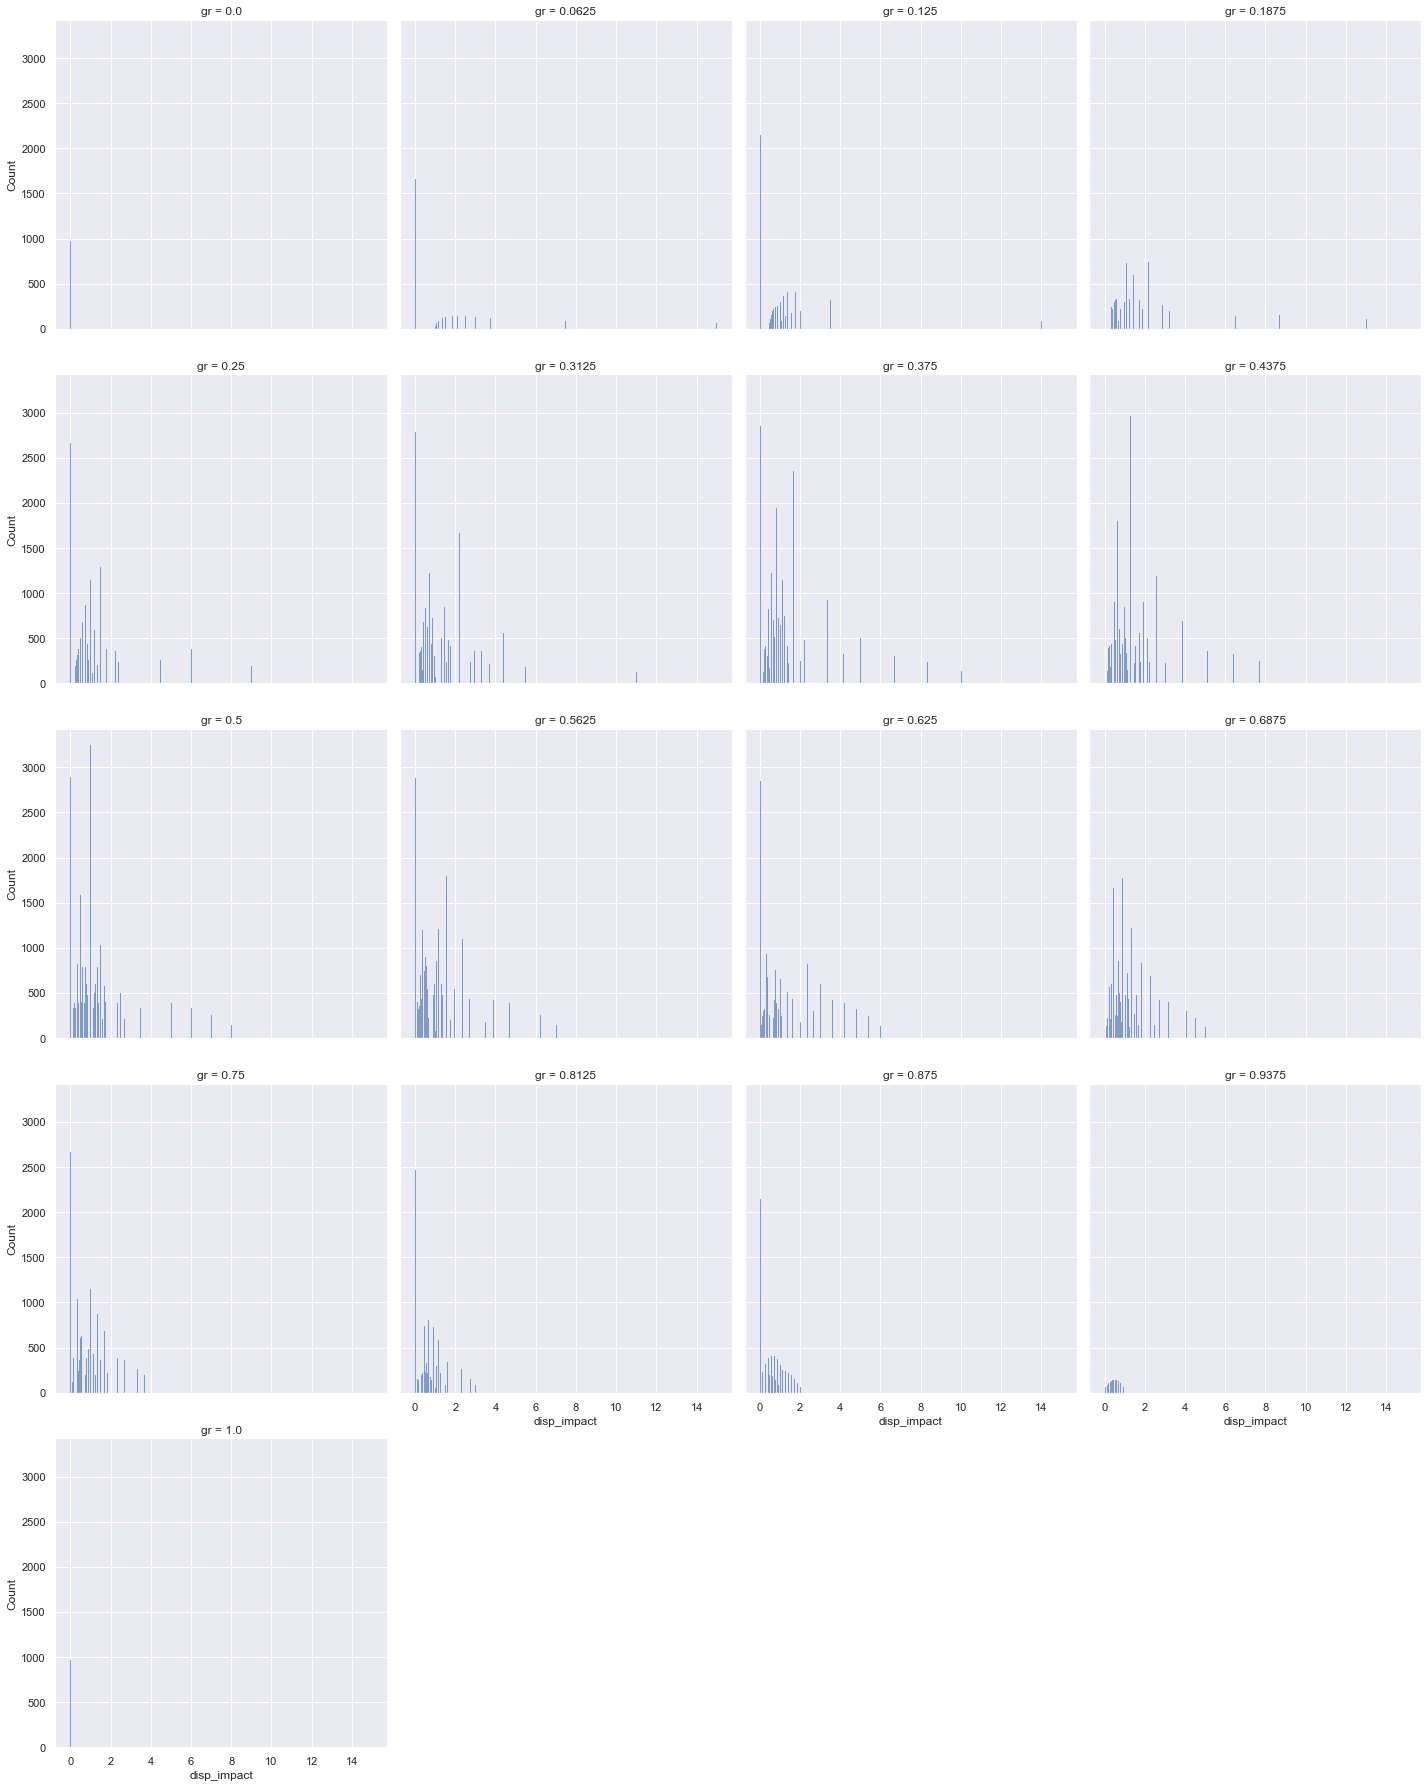

----------------------------- acc_equality_ratio -----------------------------


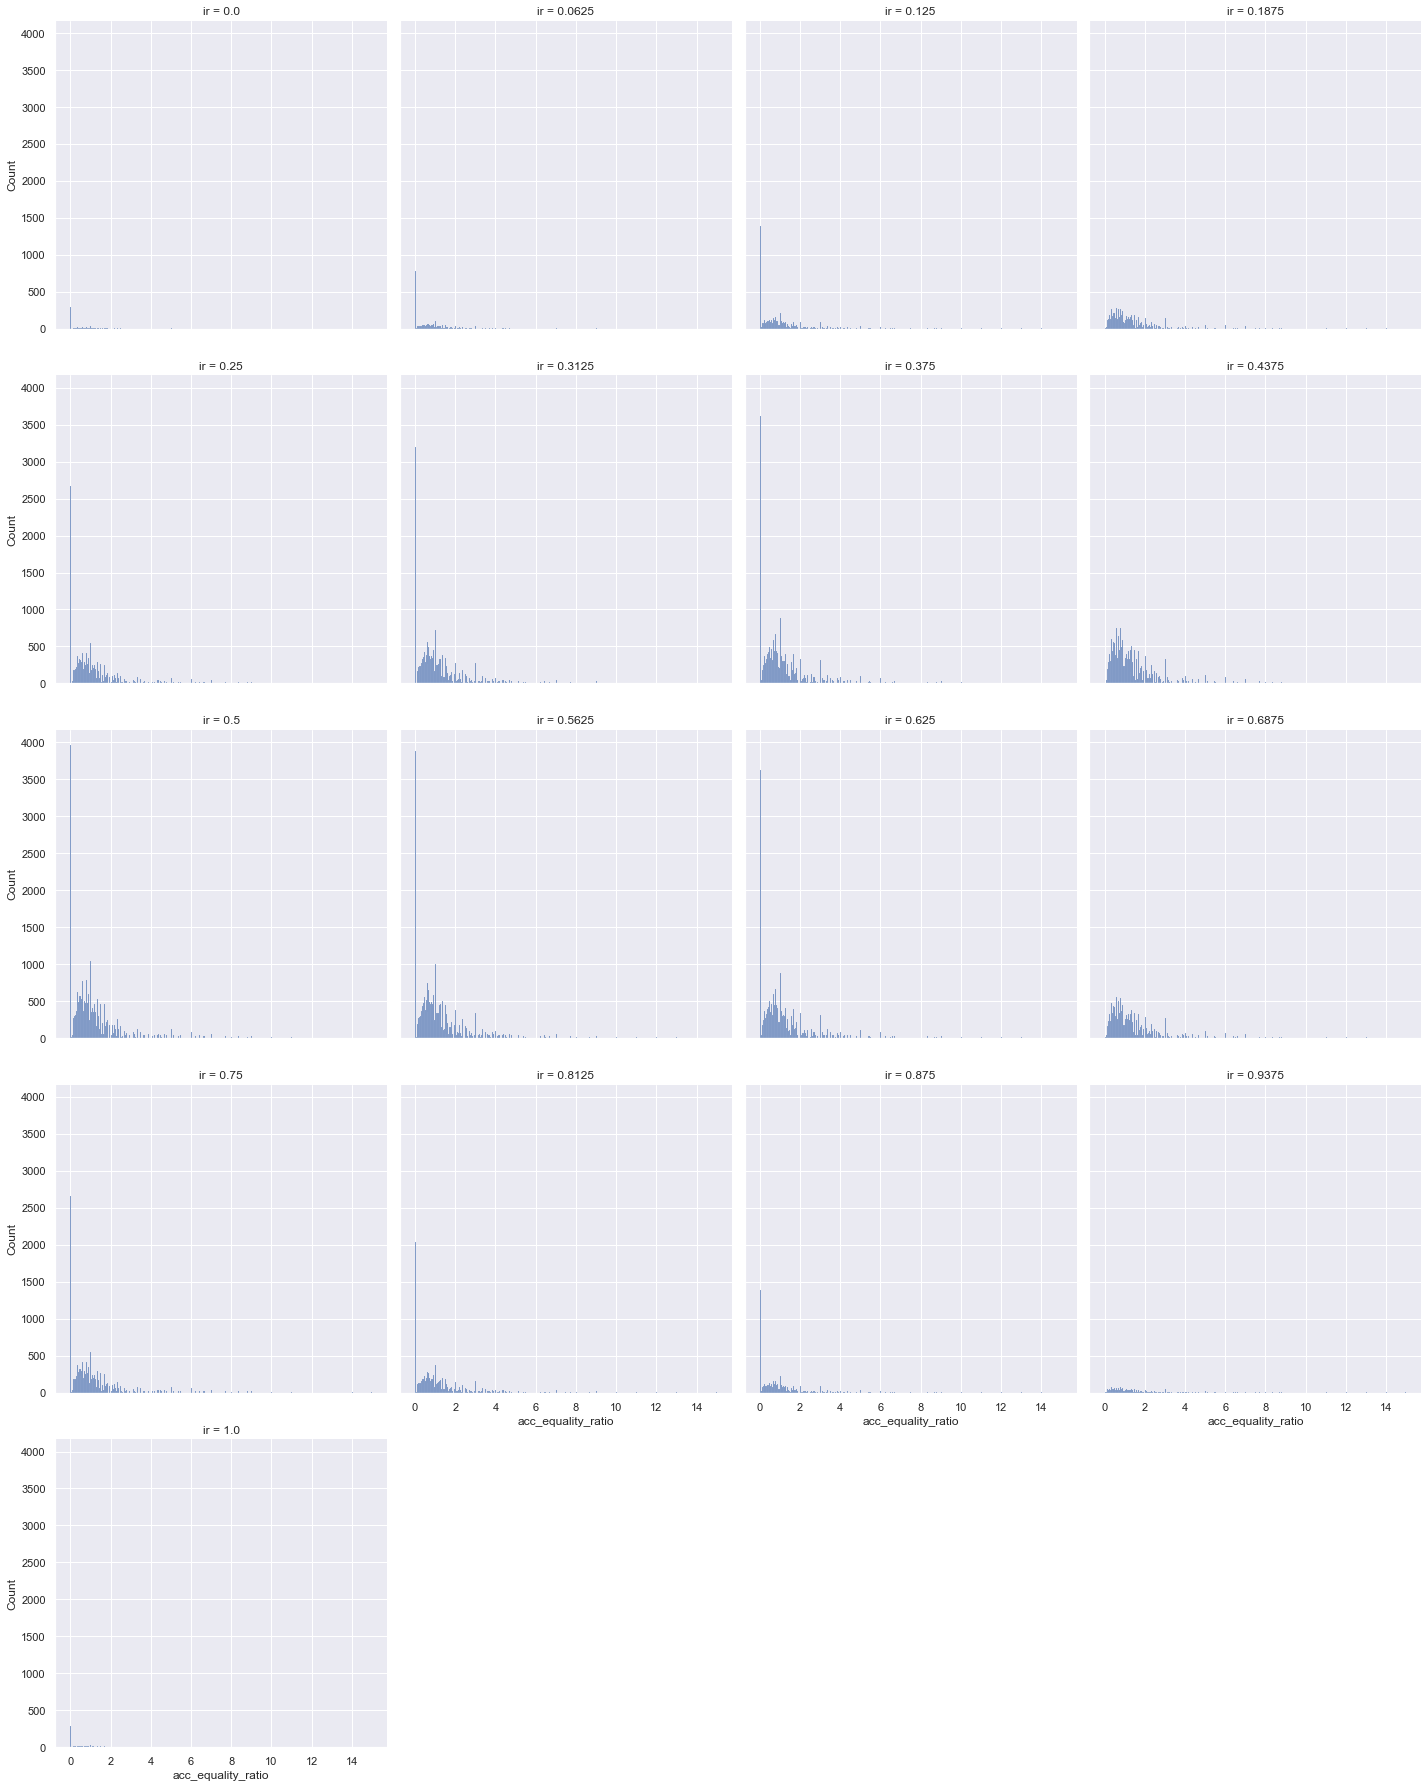

----------------------------- acc_equality_ratio -----------------------------


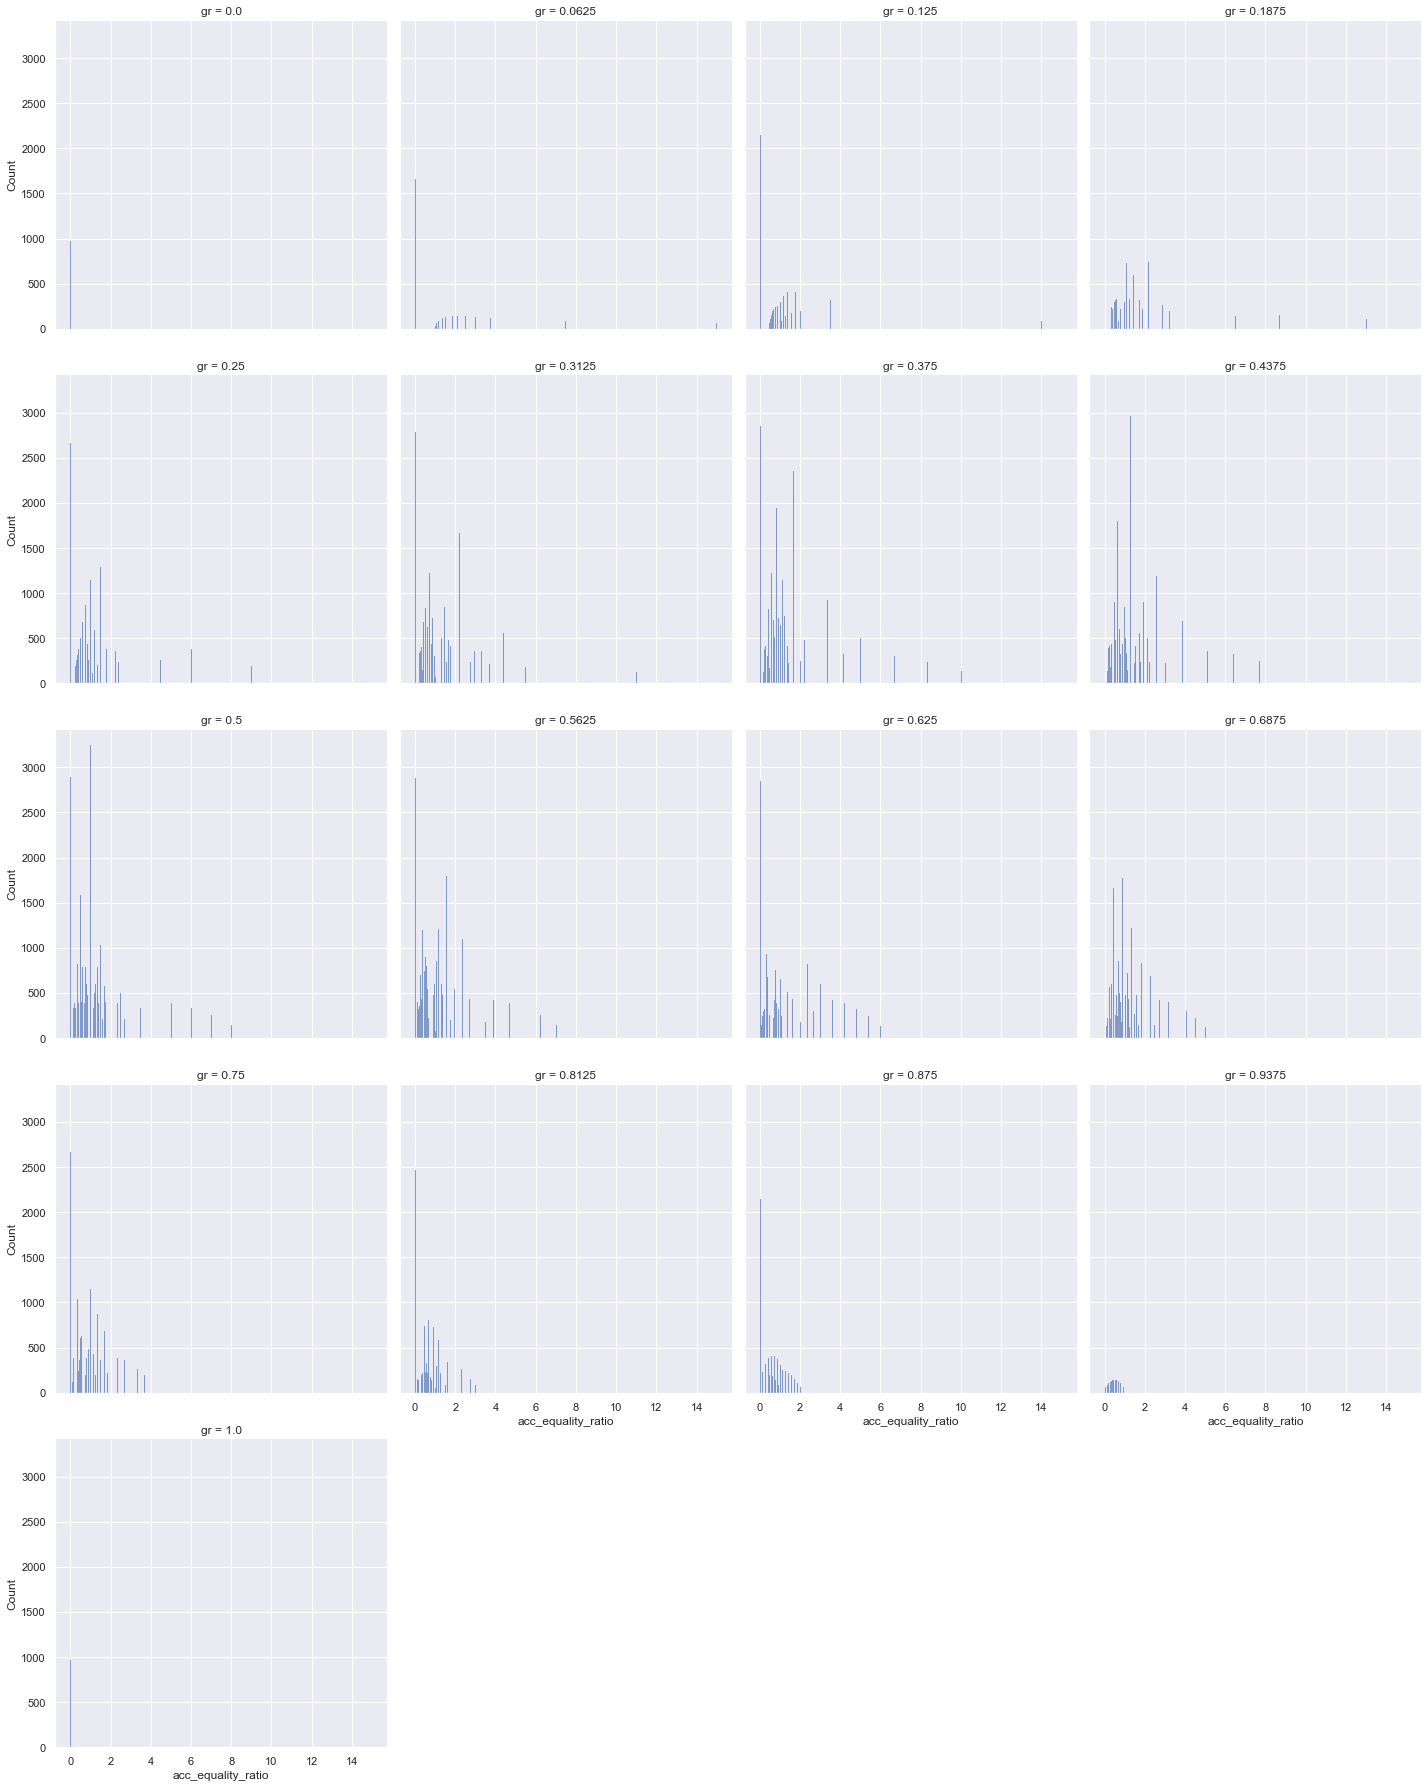

----------------------------- acc_equality_diff -----------------------------


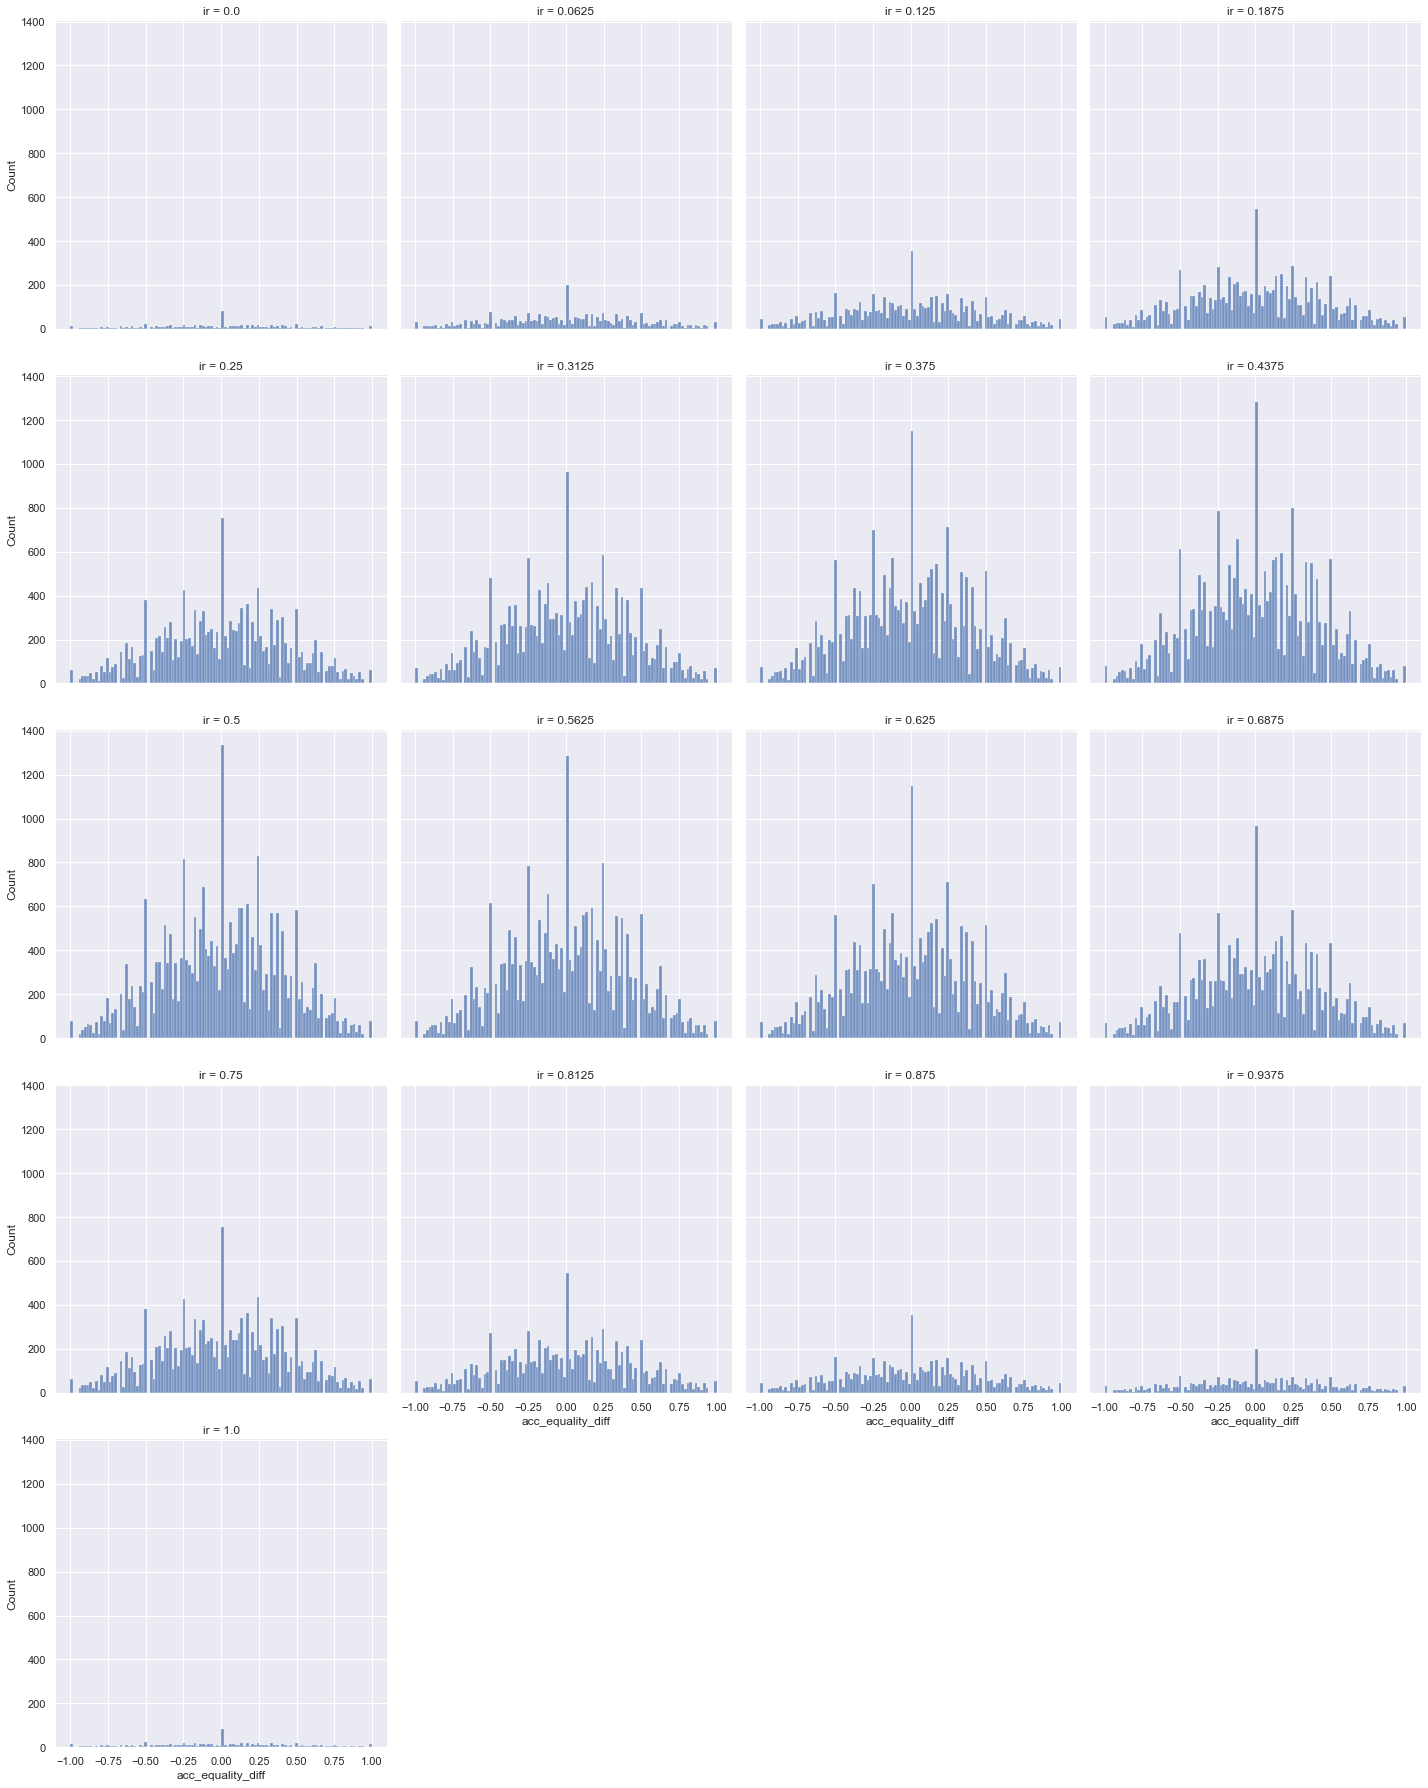

----------------------------- acc_equality_diff -----------------------------


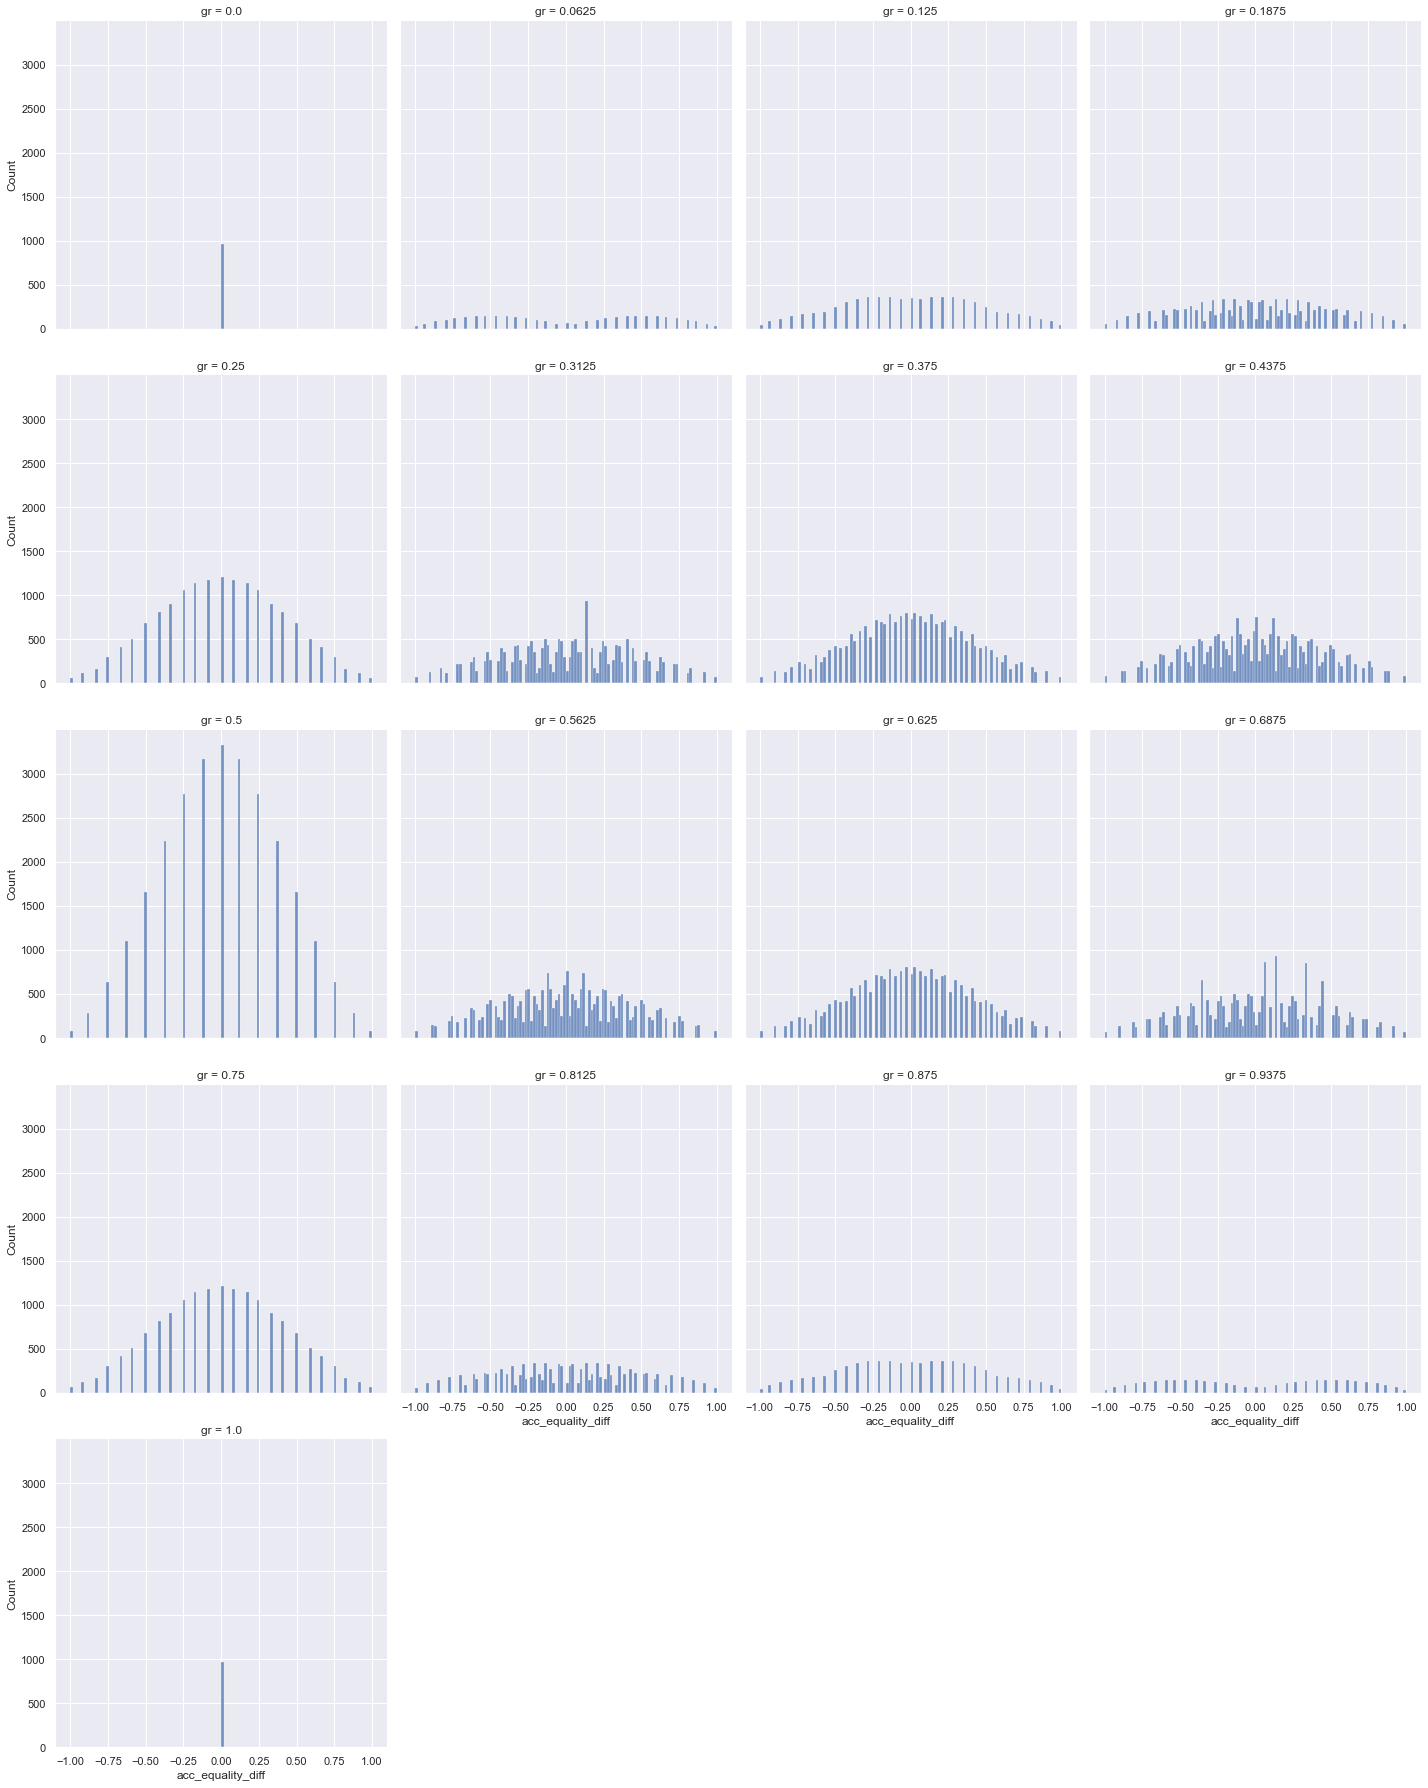

----------------------------- pred_equality_ratio -----------------------------


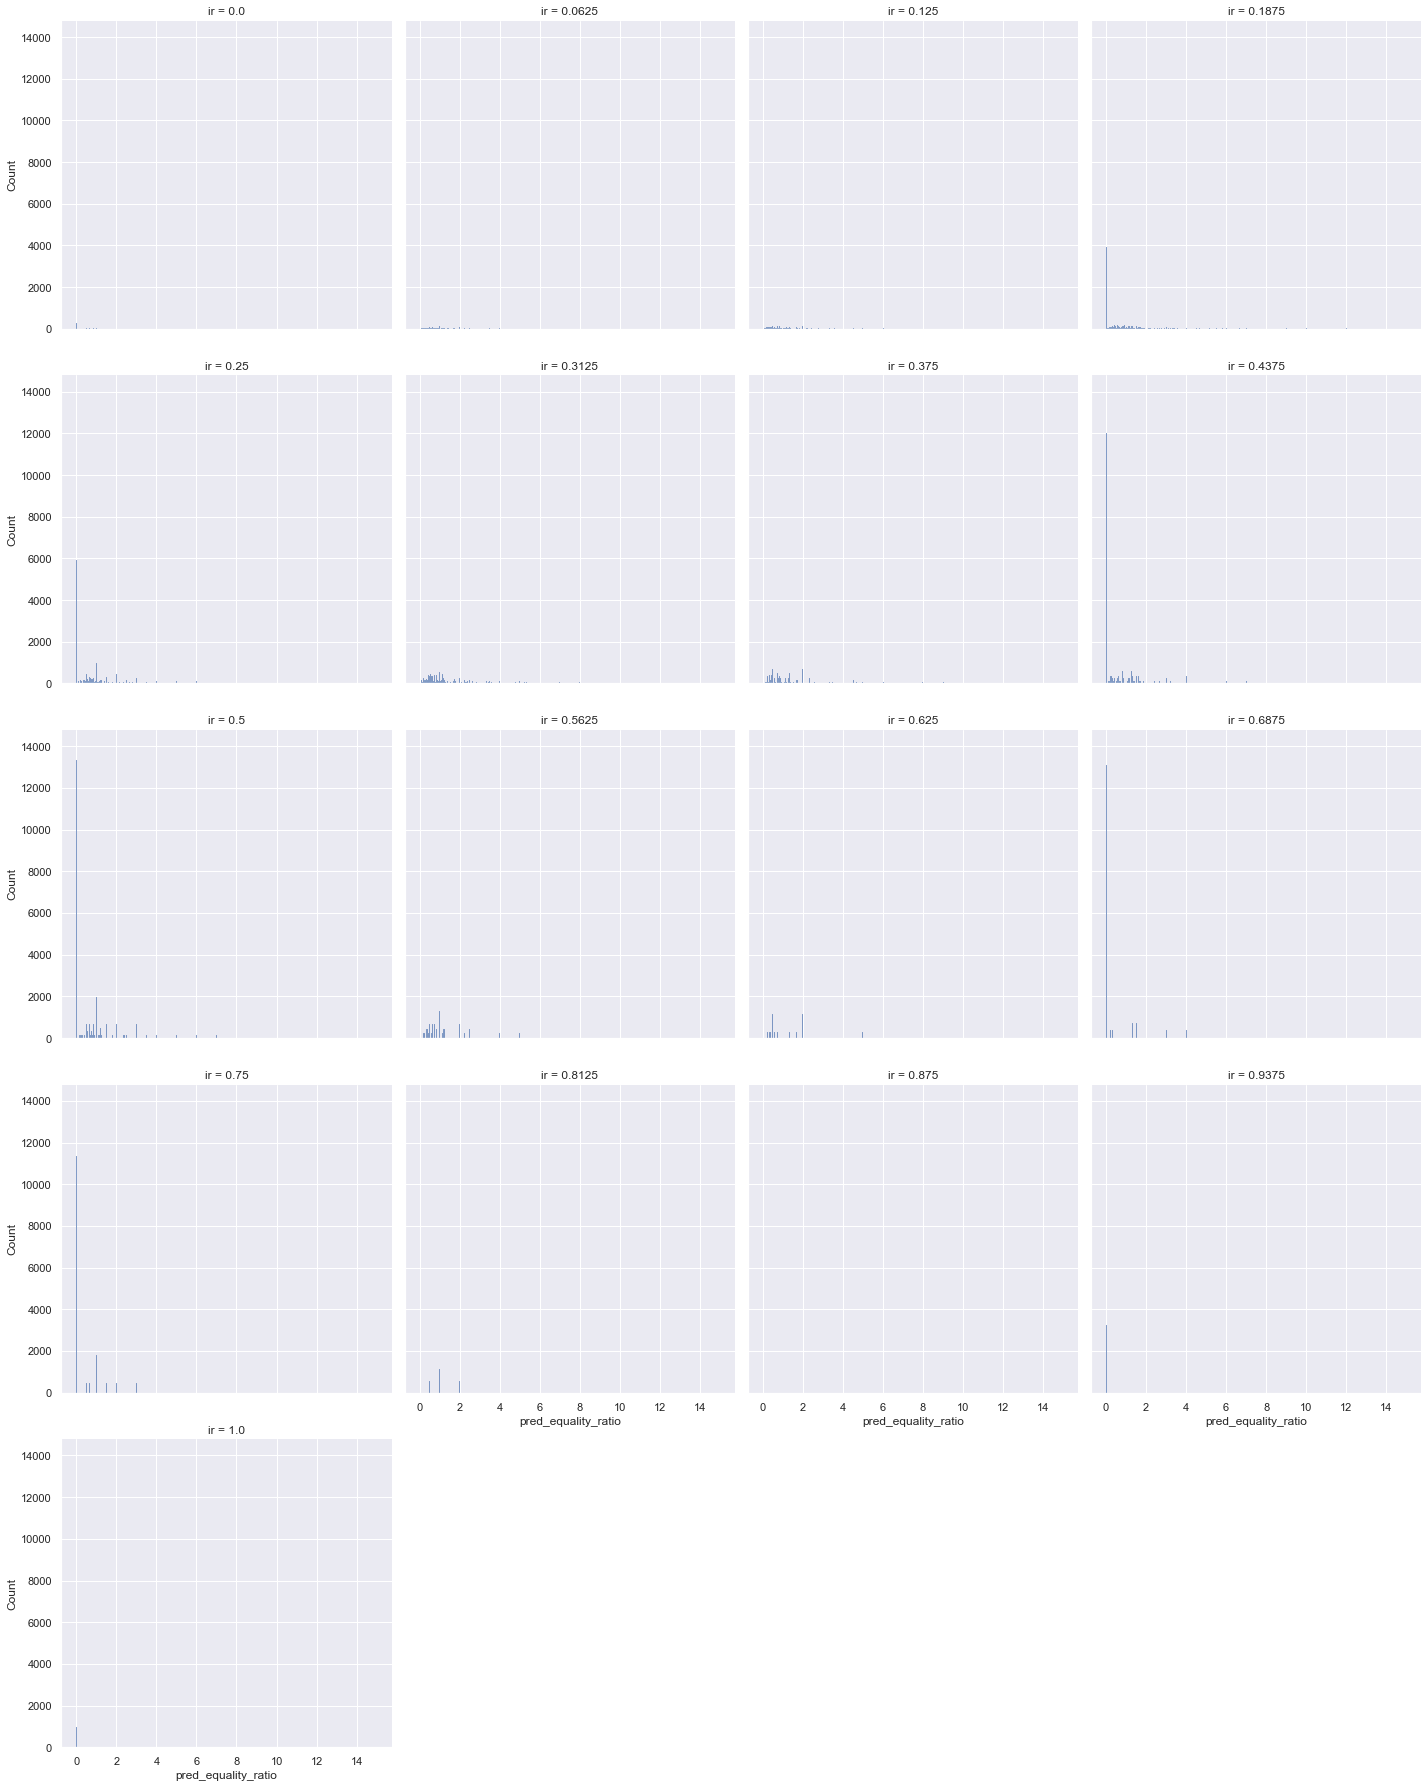

----------------------------- pred_equality_ratio -----------------------------


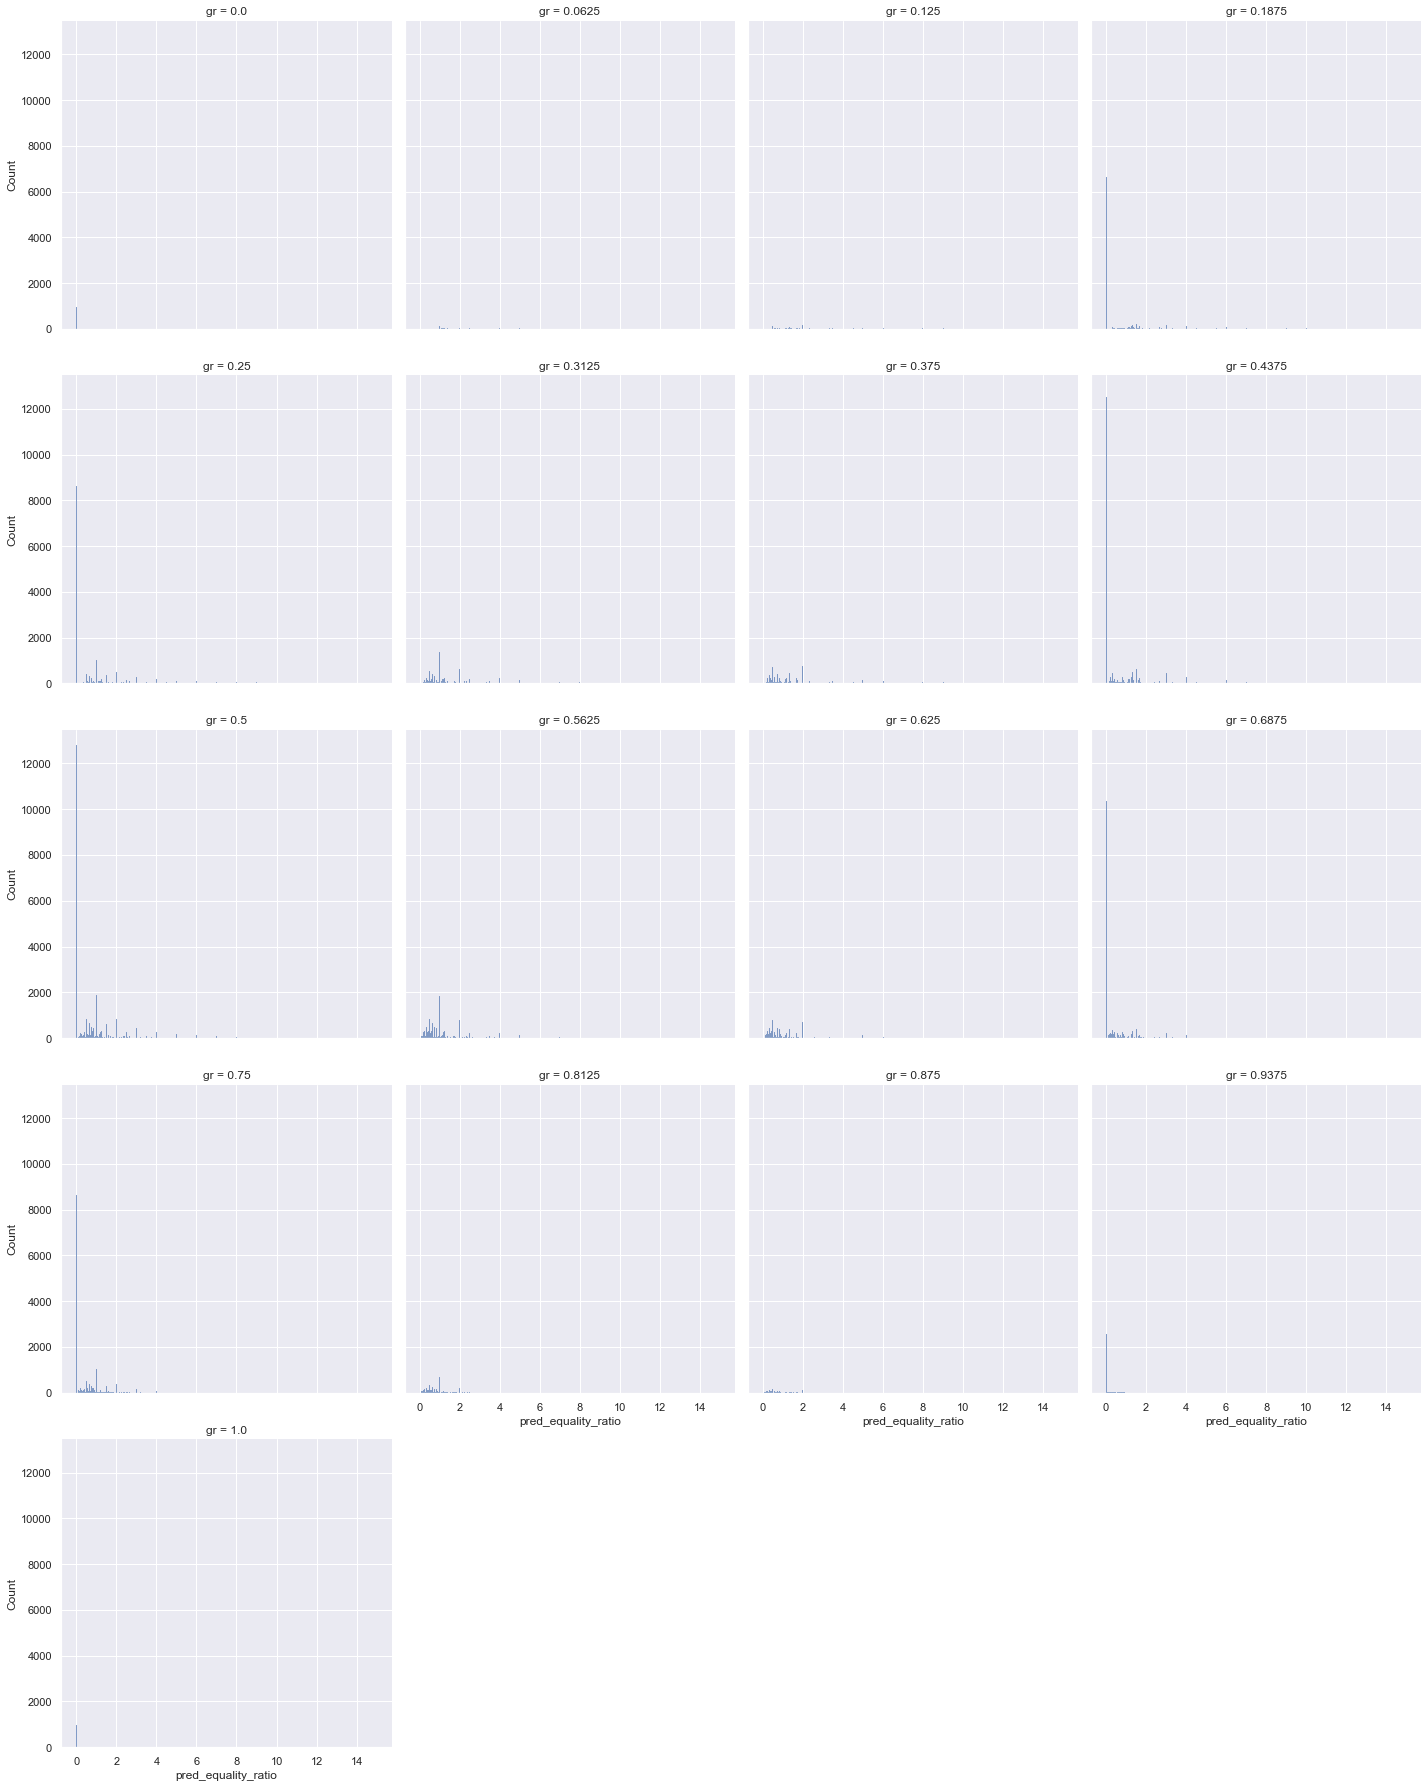

----------------------------- pred_equality_diff -----------------------------


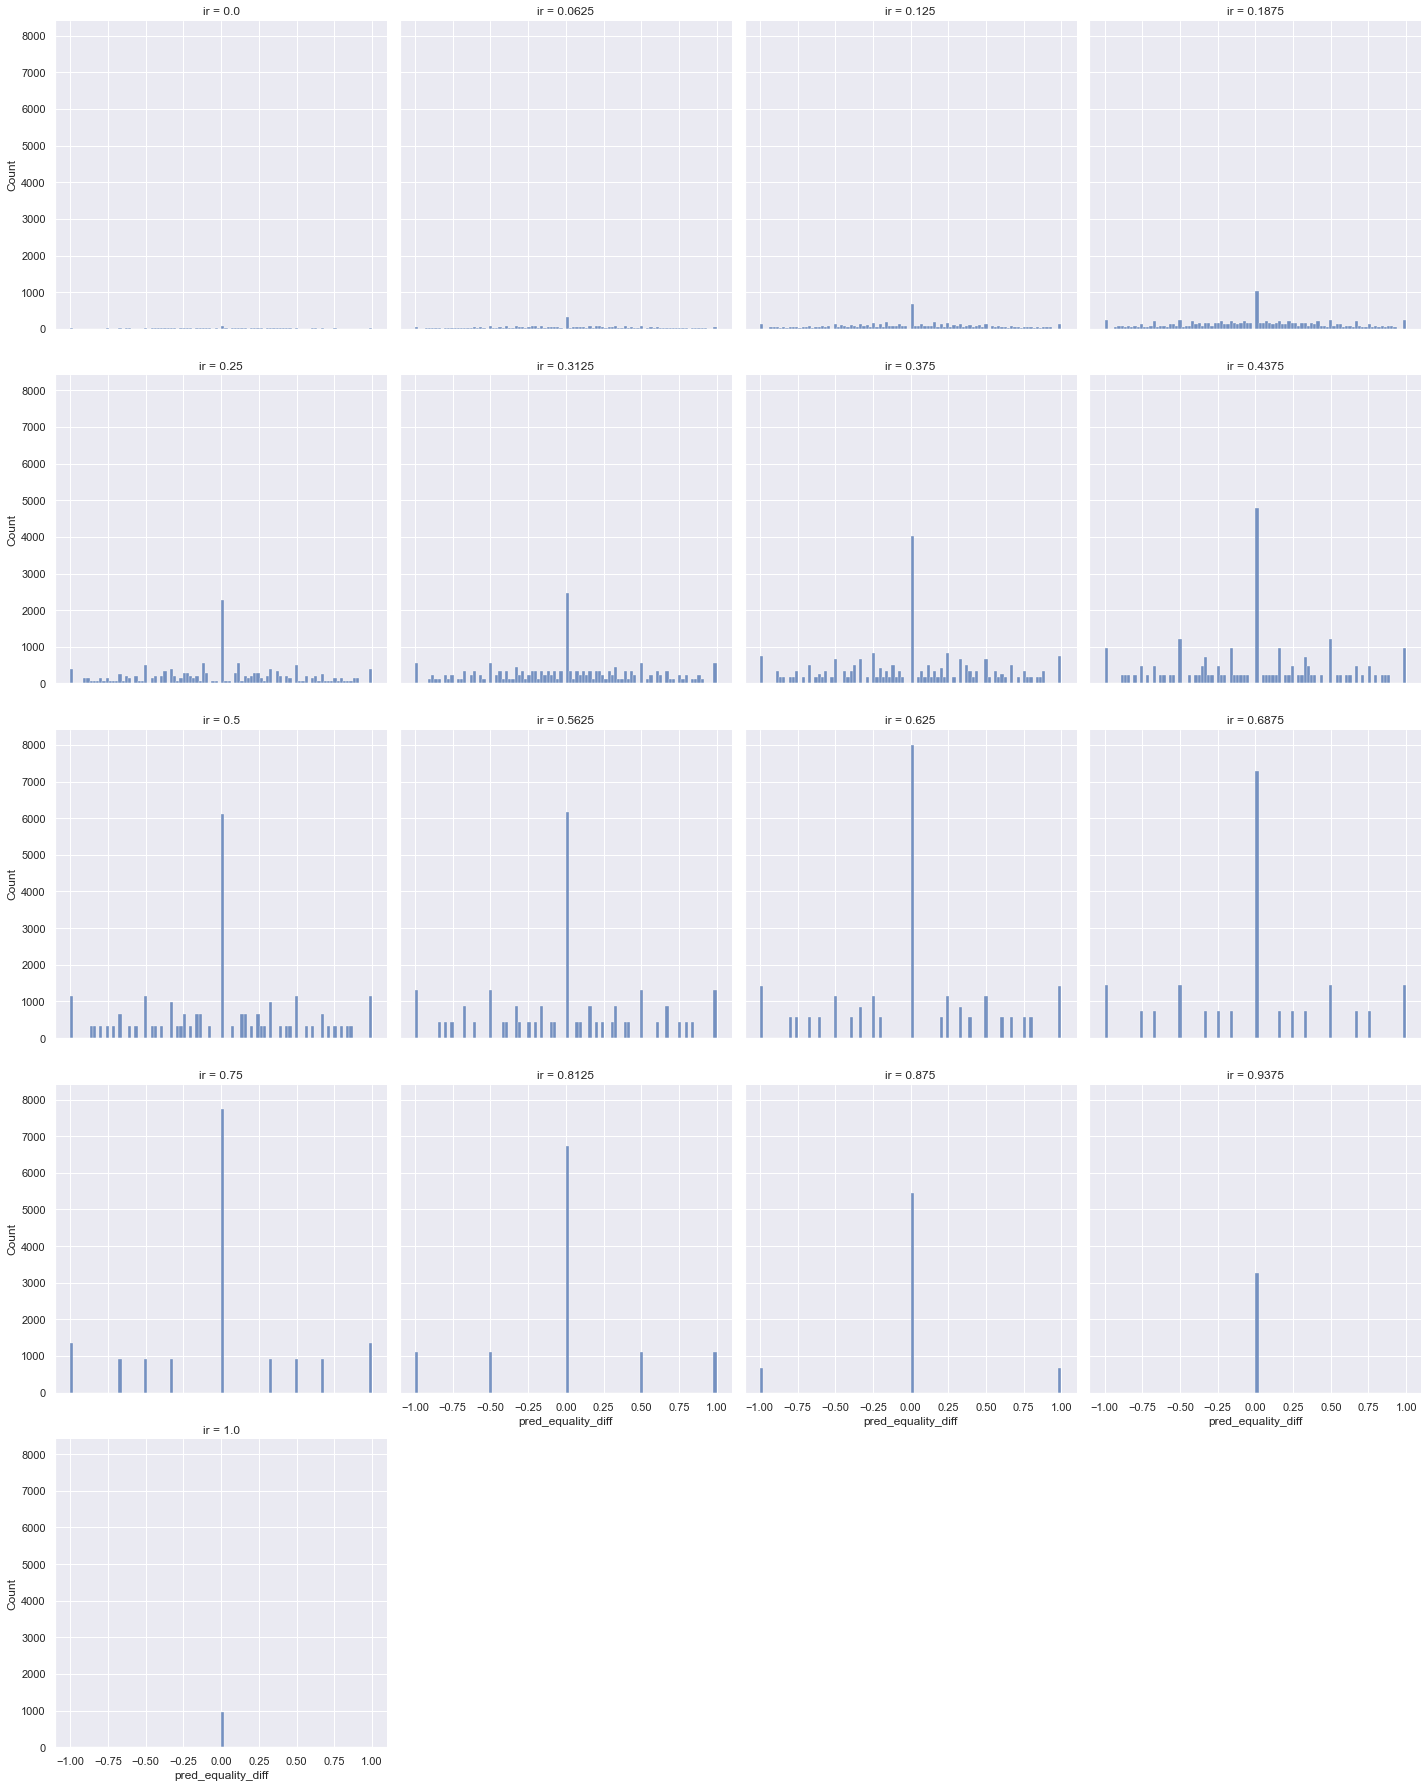

----------------------------- pred_equality_diff -----------------------------


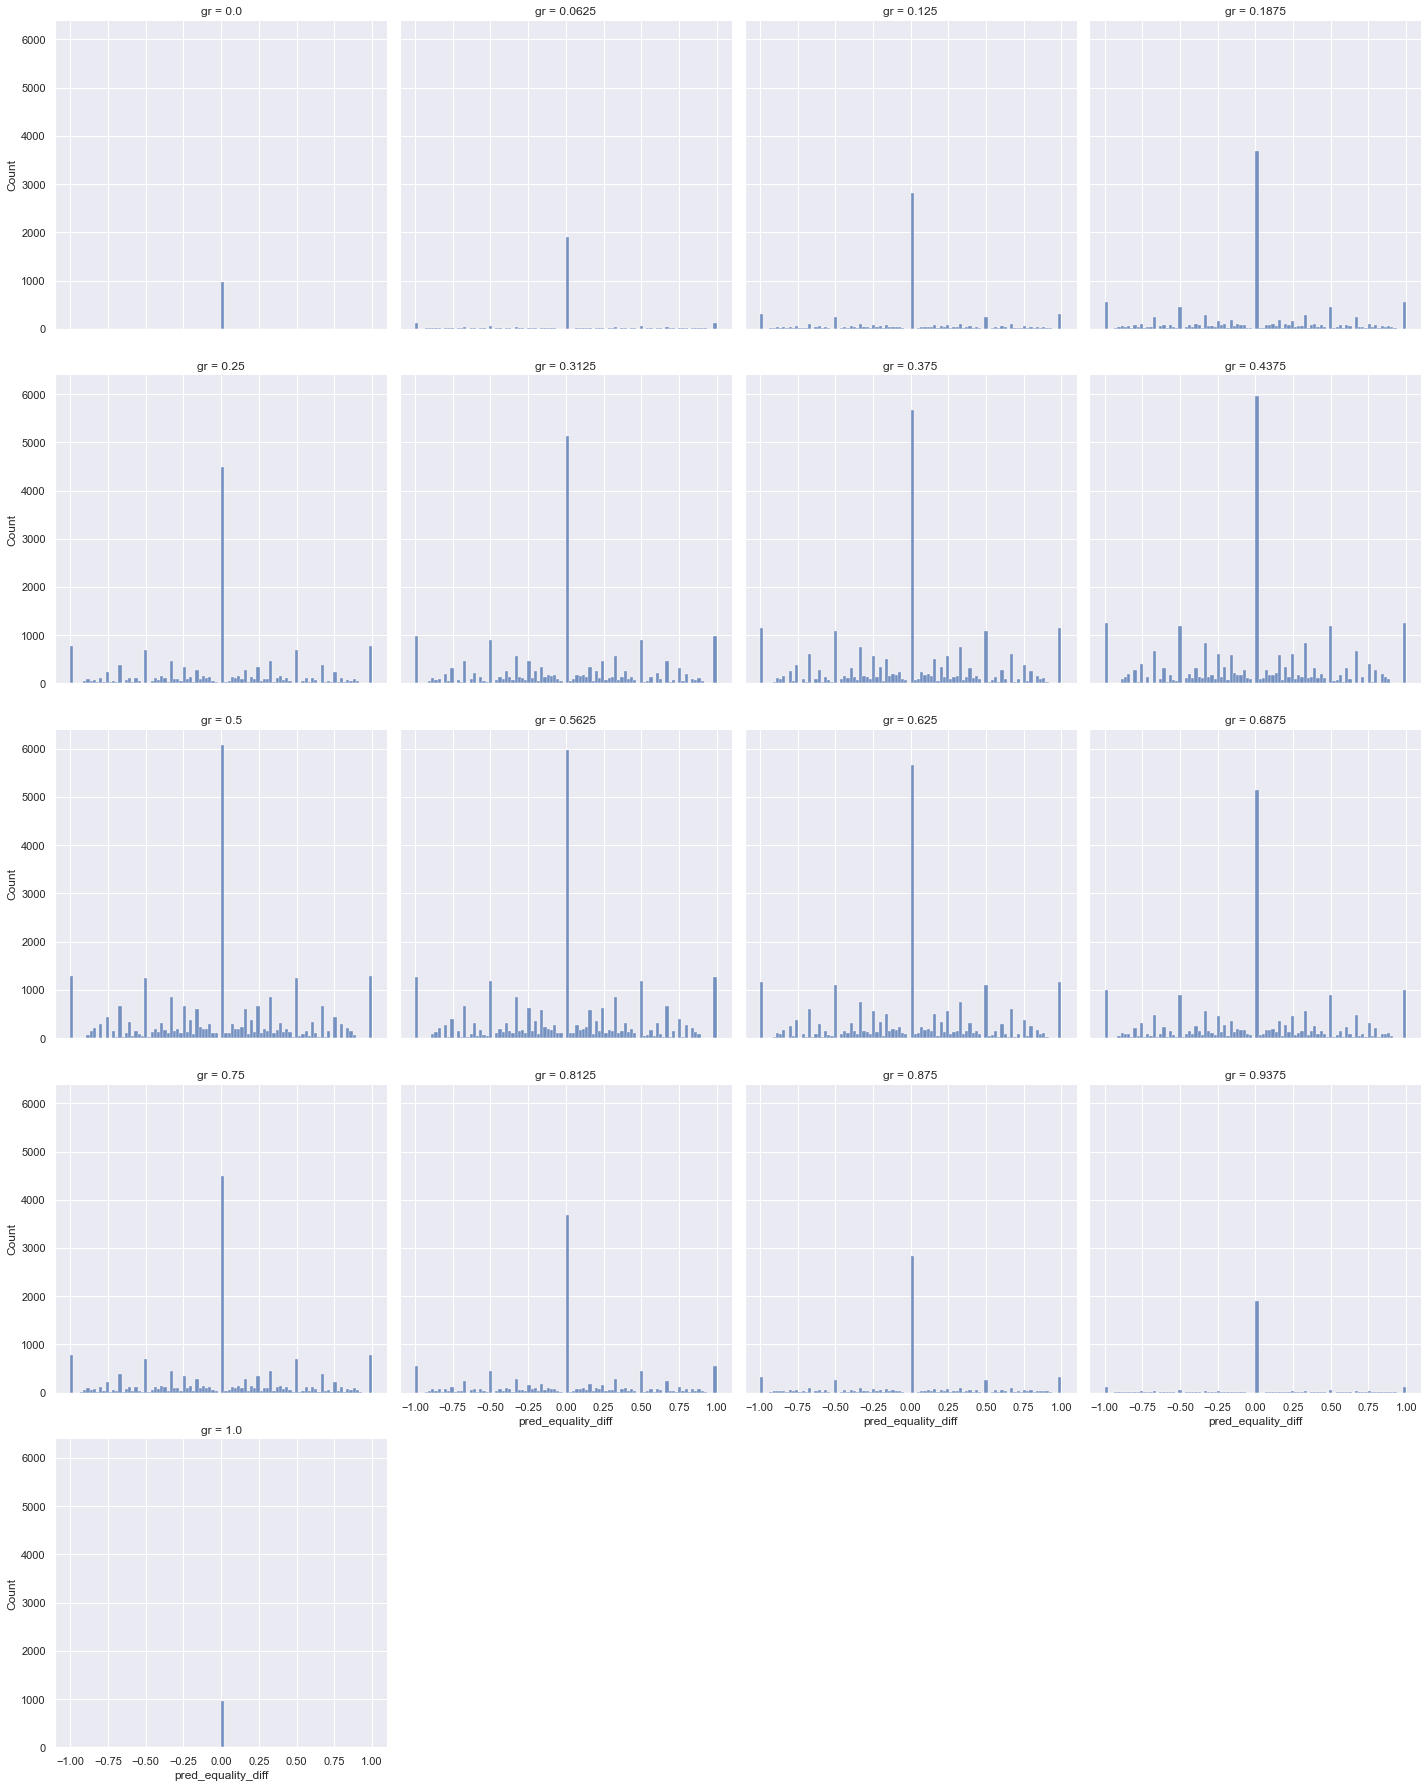

----------------------------- pred_parity_ratio -----------------------------


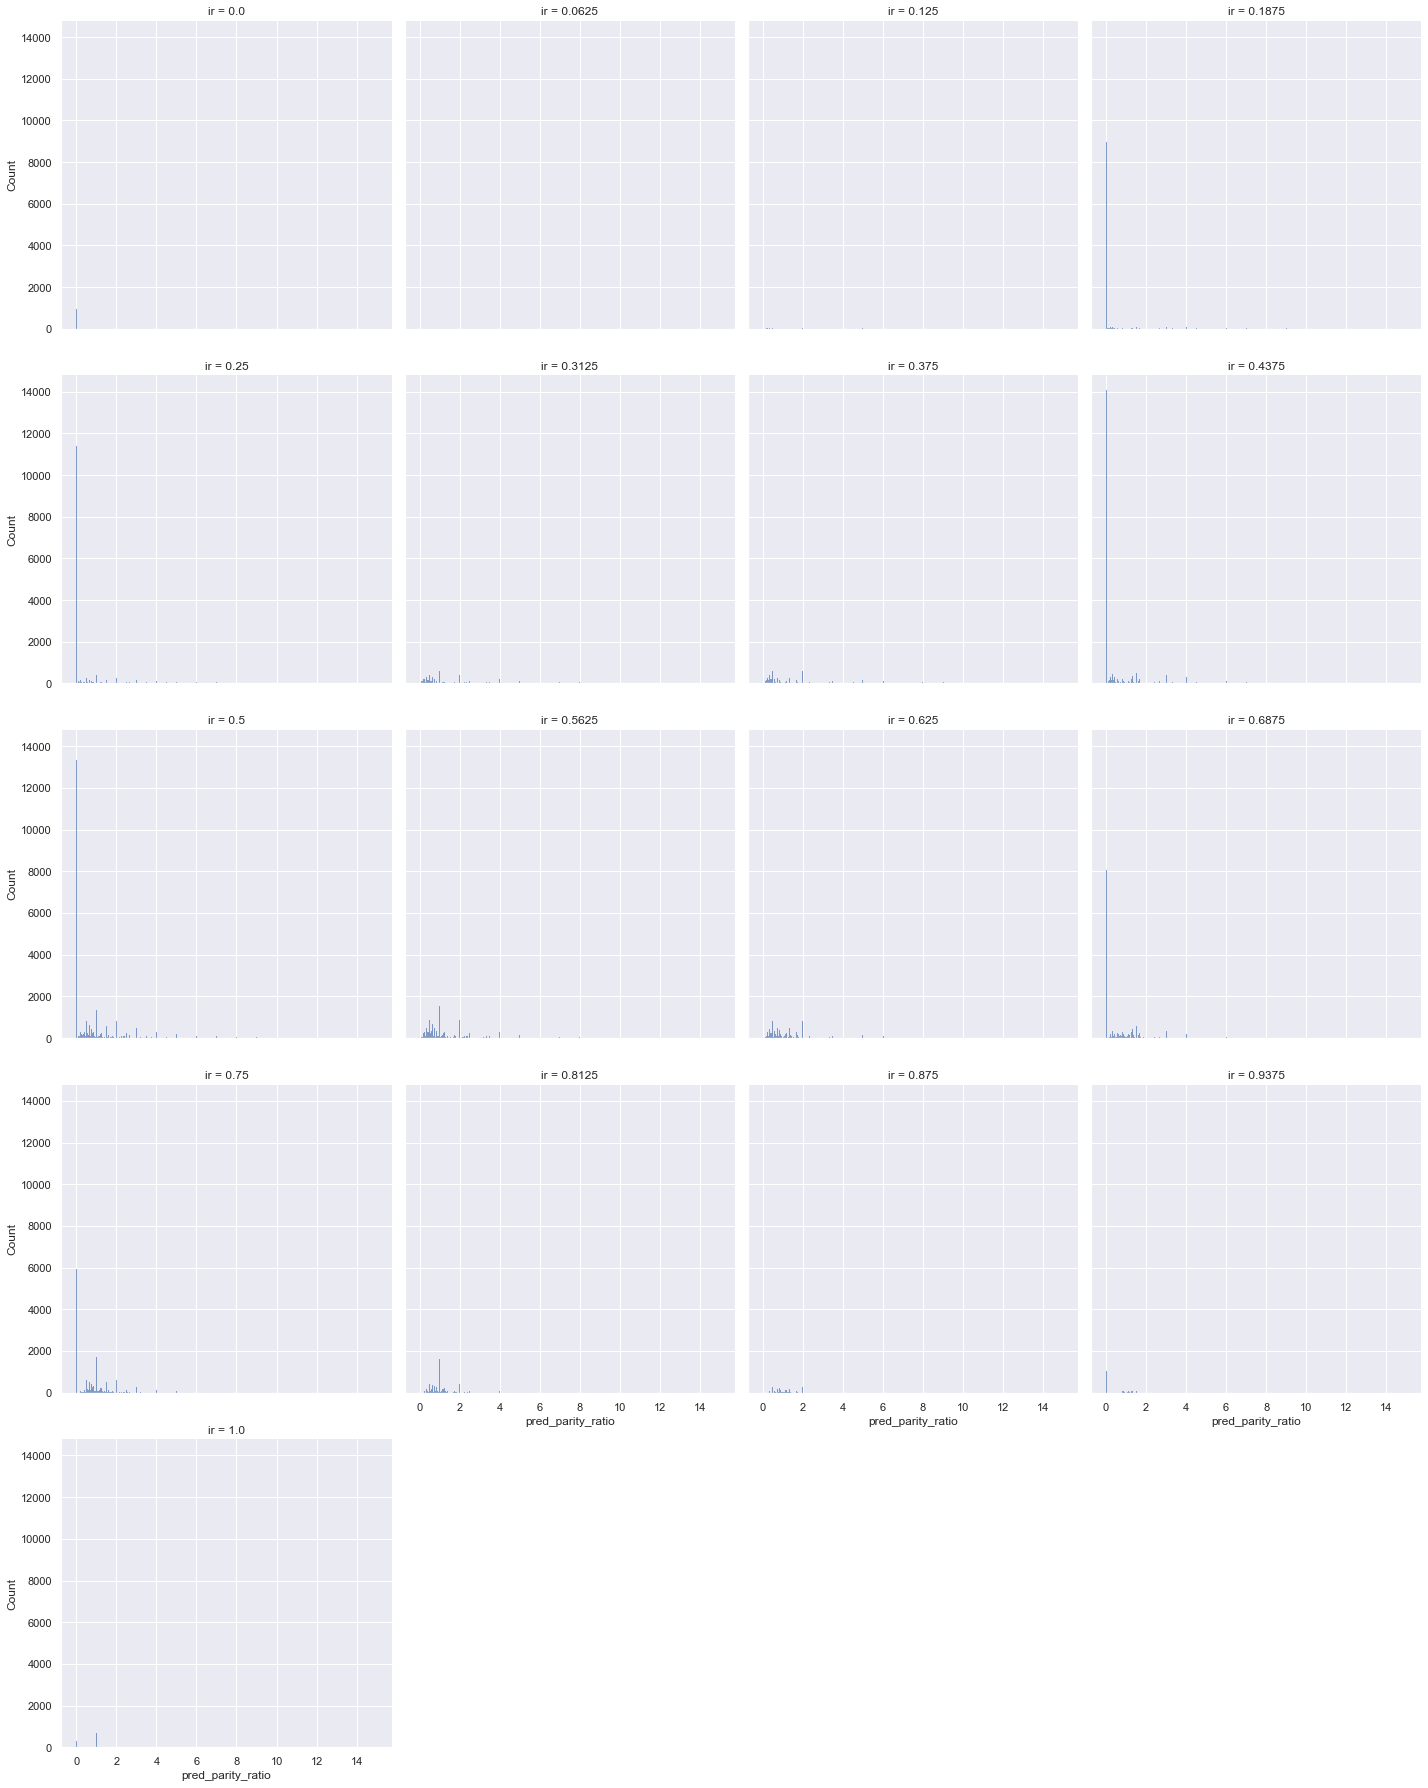

----------------------------- pred_parity_ratio -----------------------------


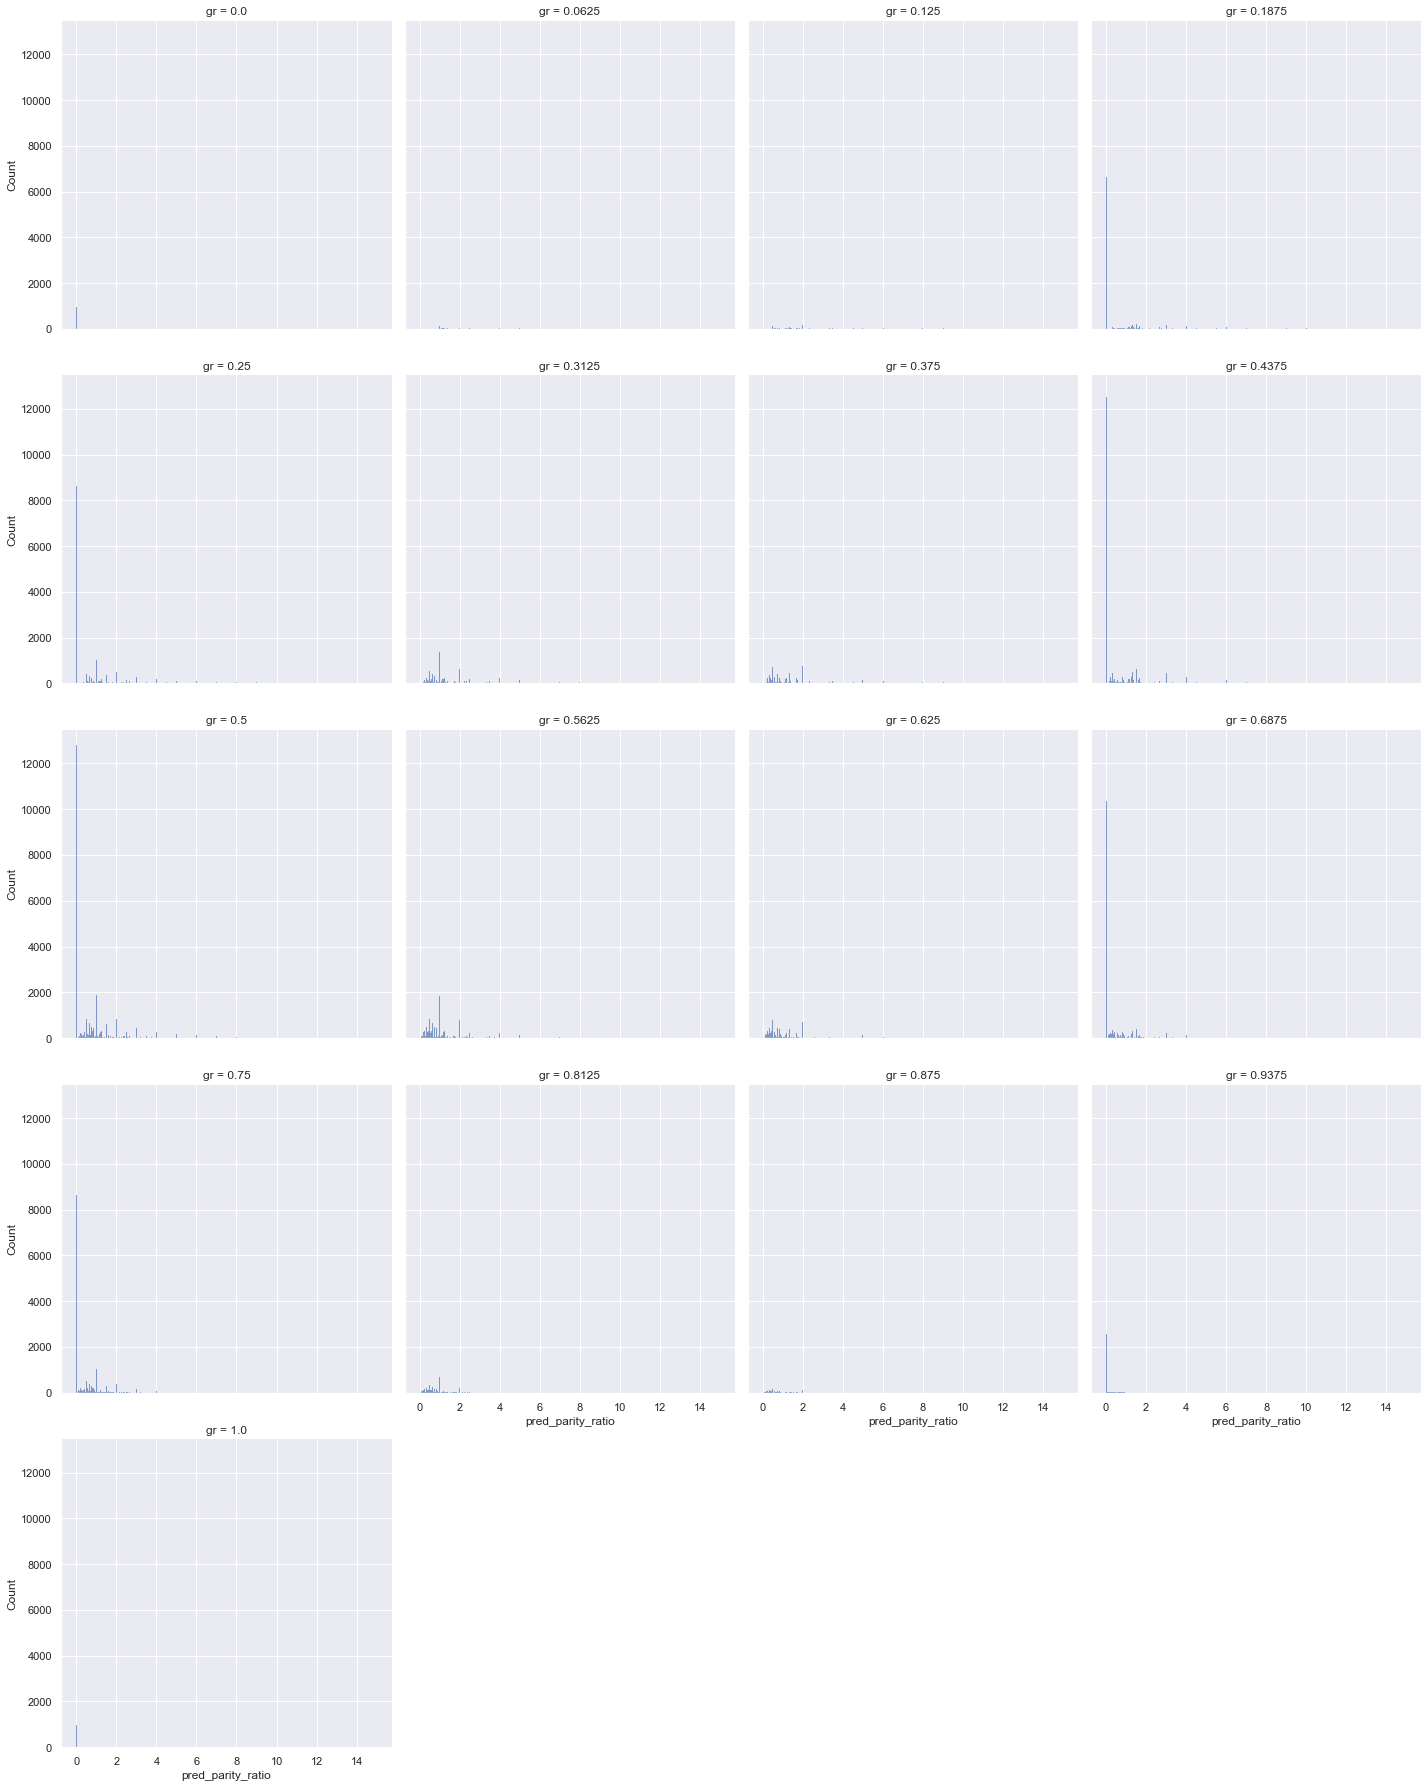

----------------------------- pred_parity_diff -----------------------------


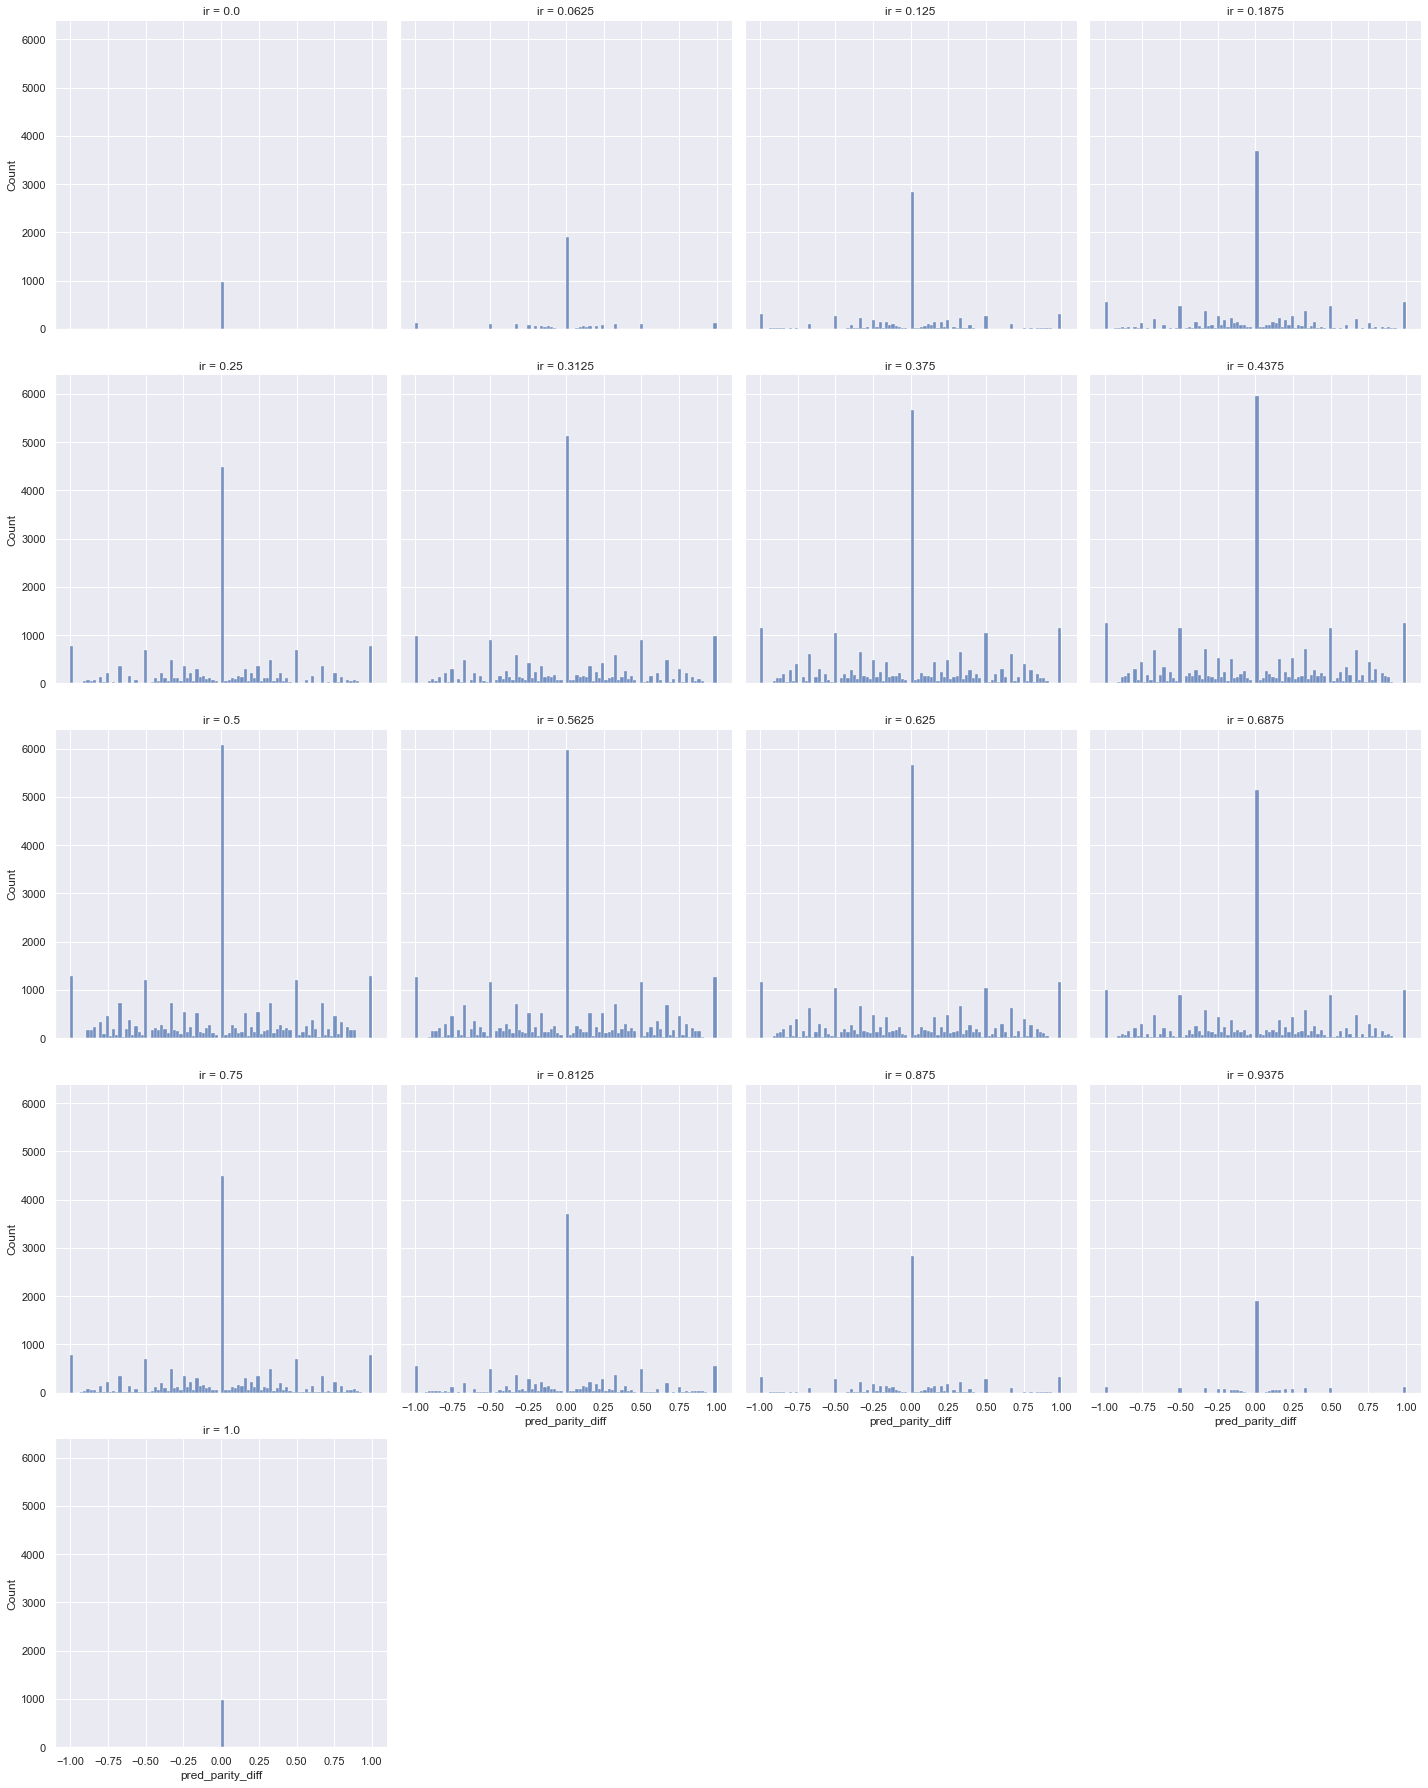

----------------------------- pred_parity_diff -----------------------------


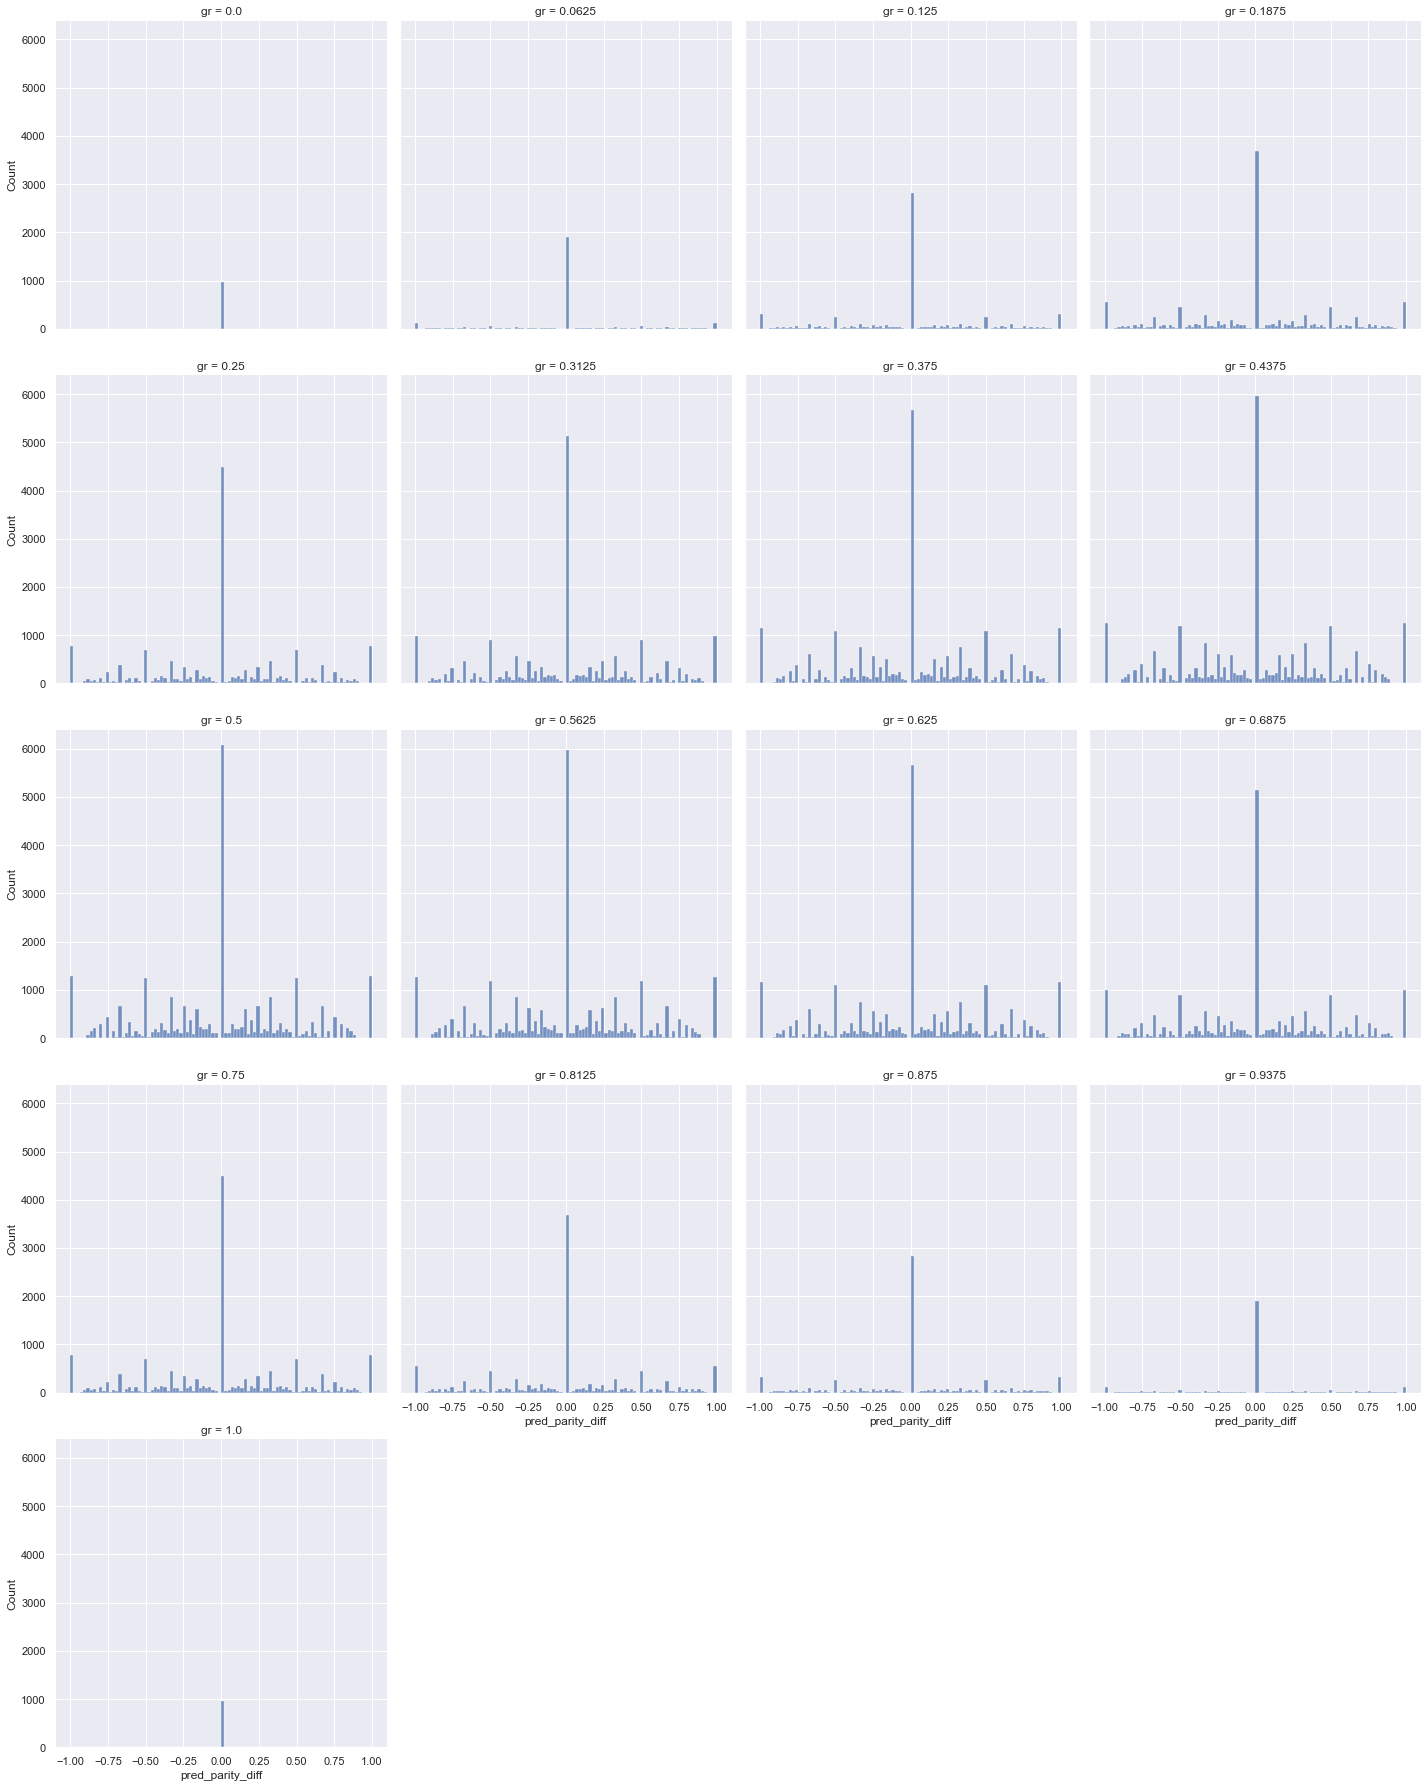

In [4]:
for fm in fm_list:
    
    print("-----------------------------",fm,"-----------------------------")
    
    sns.set(rc={'figure.figsize':(12.7,8.6)})
    sns.displot(
    df, x=fm, col="ir",
    col_wrap=4, 
#     aspect=5,
#     height=20, 
    facet_kws=dict(margin_titles=True),
    )
    plt.show()
    
    print("-----------------------------",fm,"-----------------------------")
    
    sns.set(rc={'figure.figsize':(12.7,8.6)})
    sns.displot(
    df, x=fm, col="gr",
    col_wrap=4, 
#     aspect=5,
#     height=20, 
    facet_kws=dict(margin_titles=True),
    )
    plt.show()
    
#     print("-----------------------------",fm,"-----------------------------")
    
#     sns.set(rc={'figure.figsize':(12.7,8.6)})
#     sns.displot(
#     df, x=fm, col="ir", row="gr", 
# #     aspect=5,
# #     height=20, 
#     facet_kws=dict(margin_titles=True),
#     )
#     plt.show()    

----------------------------- equal_opp_ratio -----------------------------


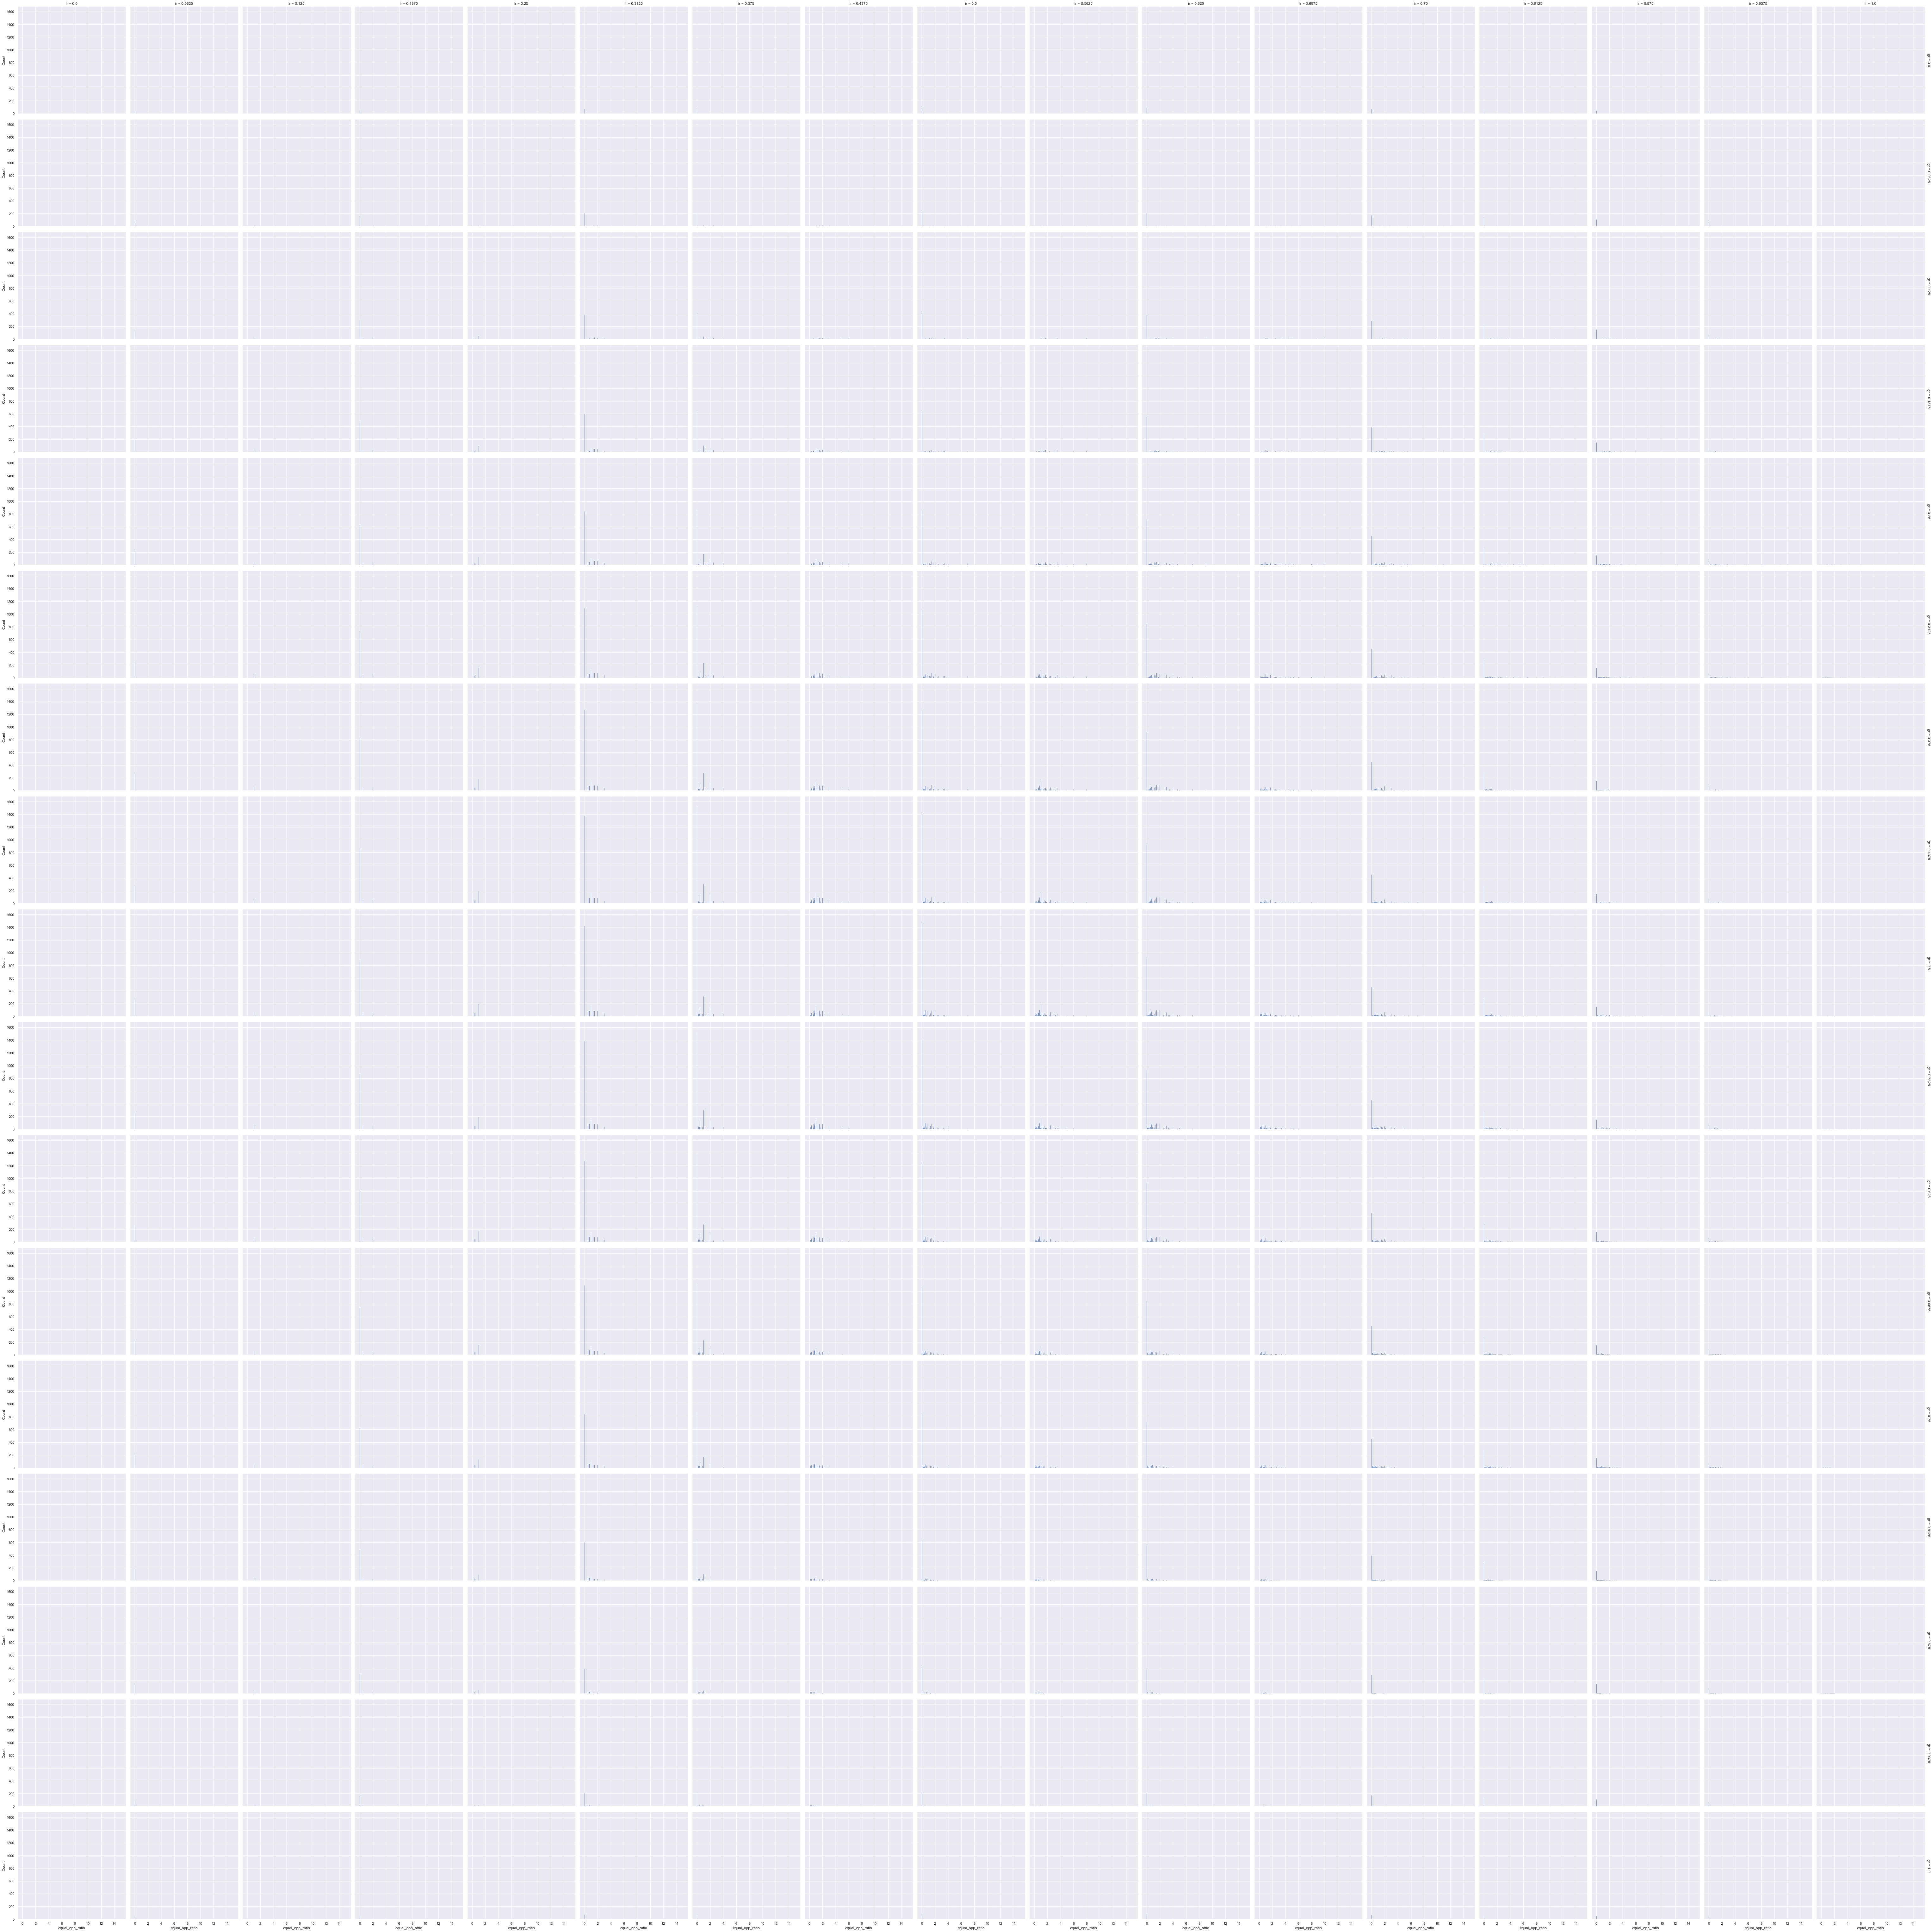

----------------------------- equal_opp_diff -----------------------------


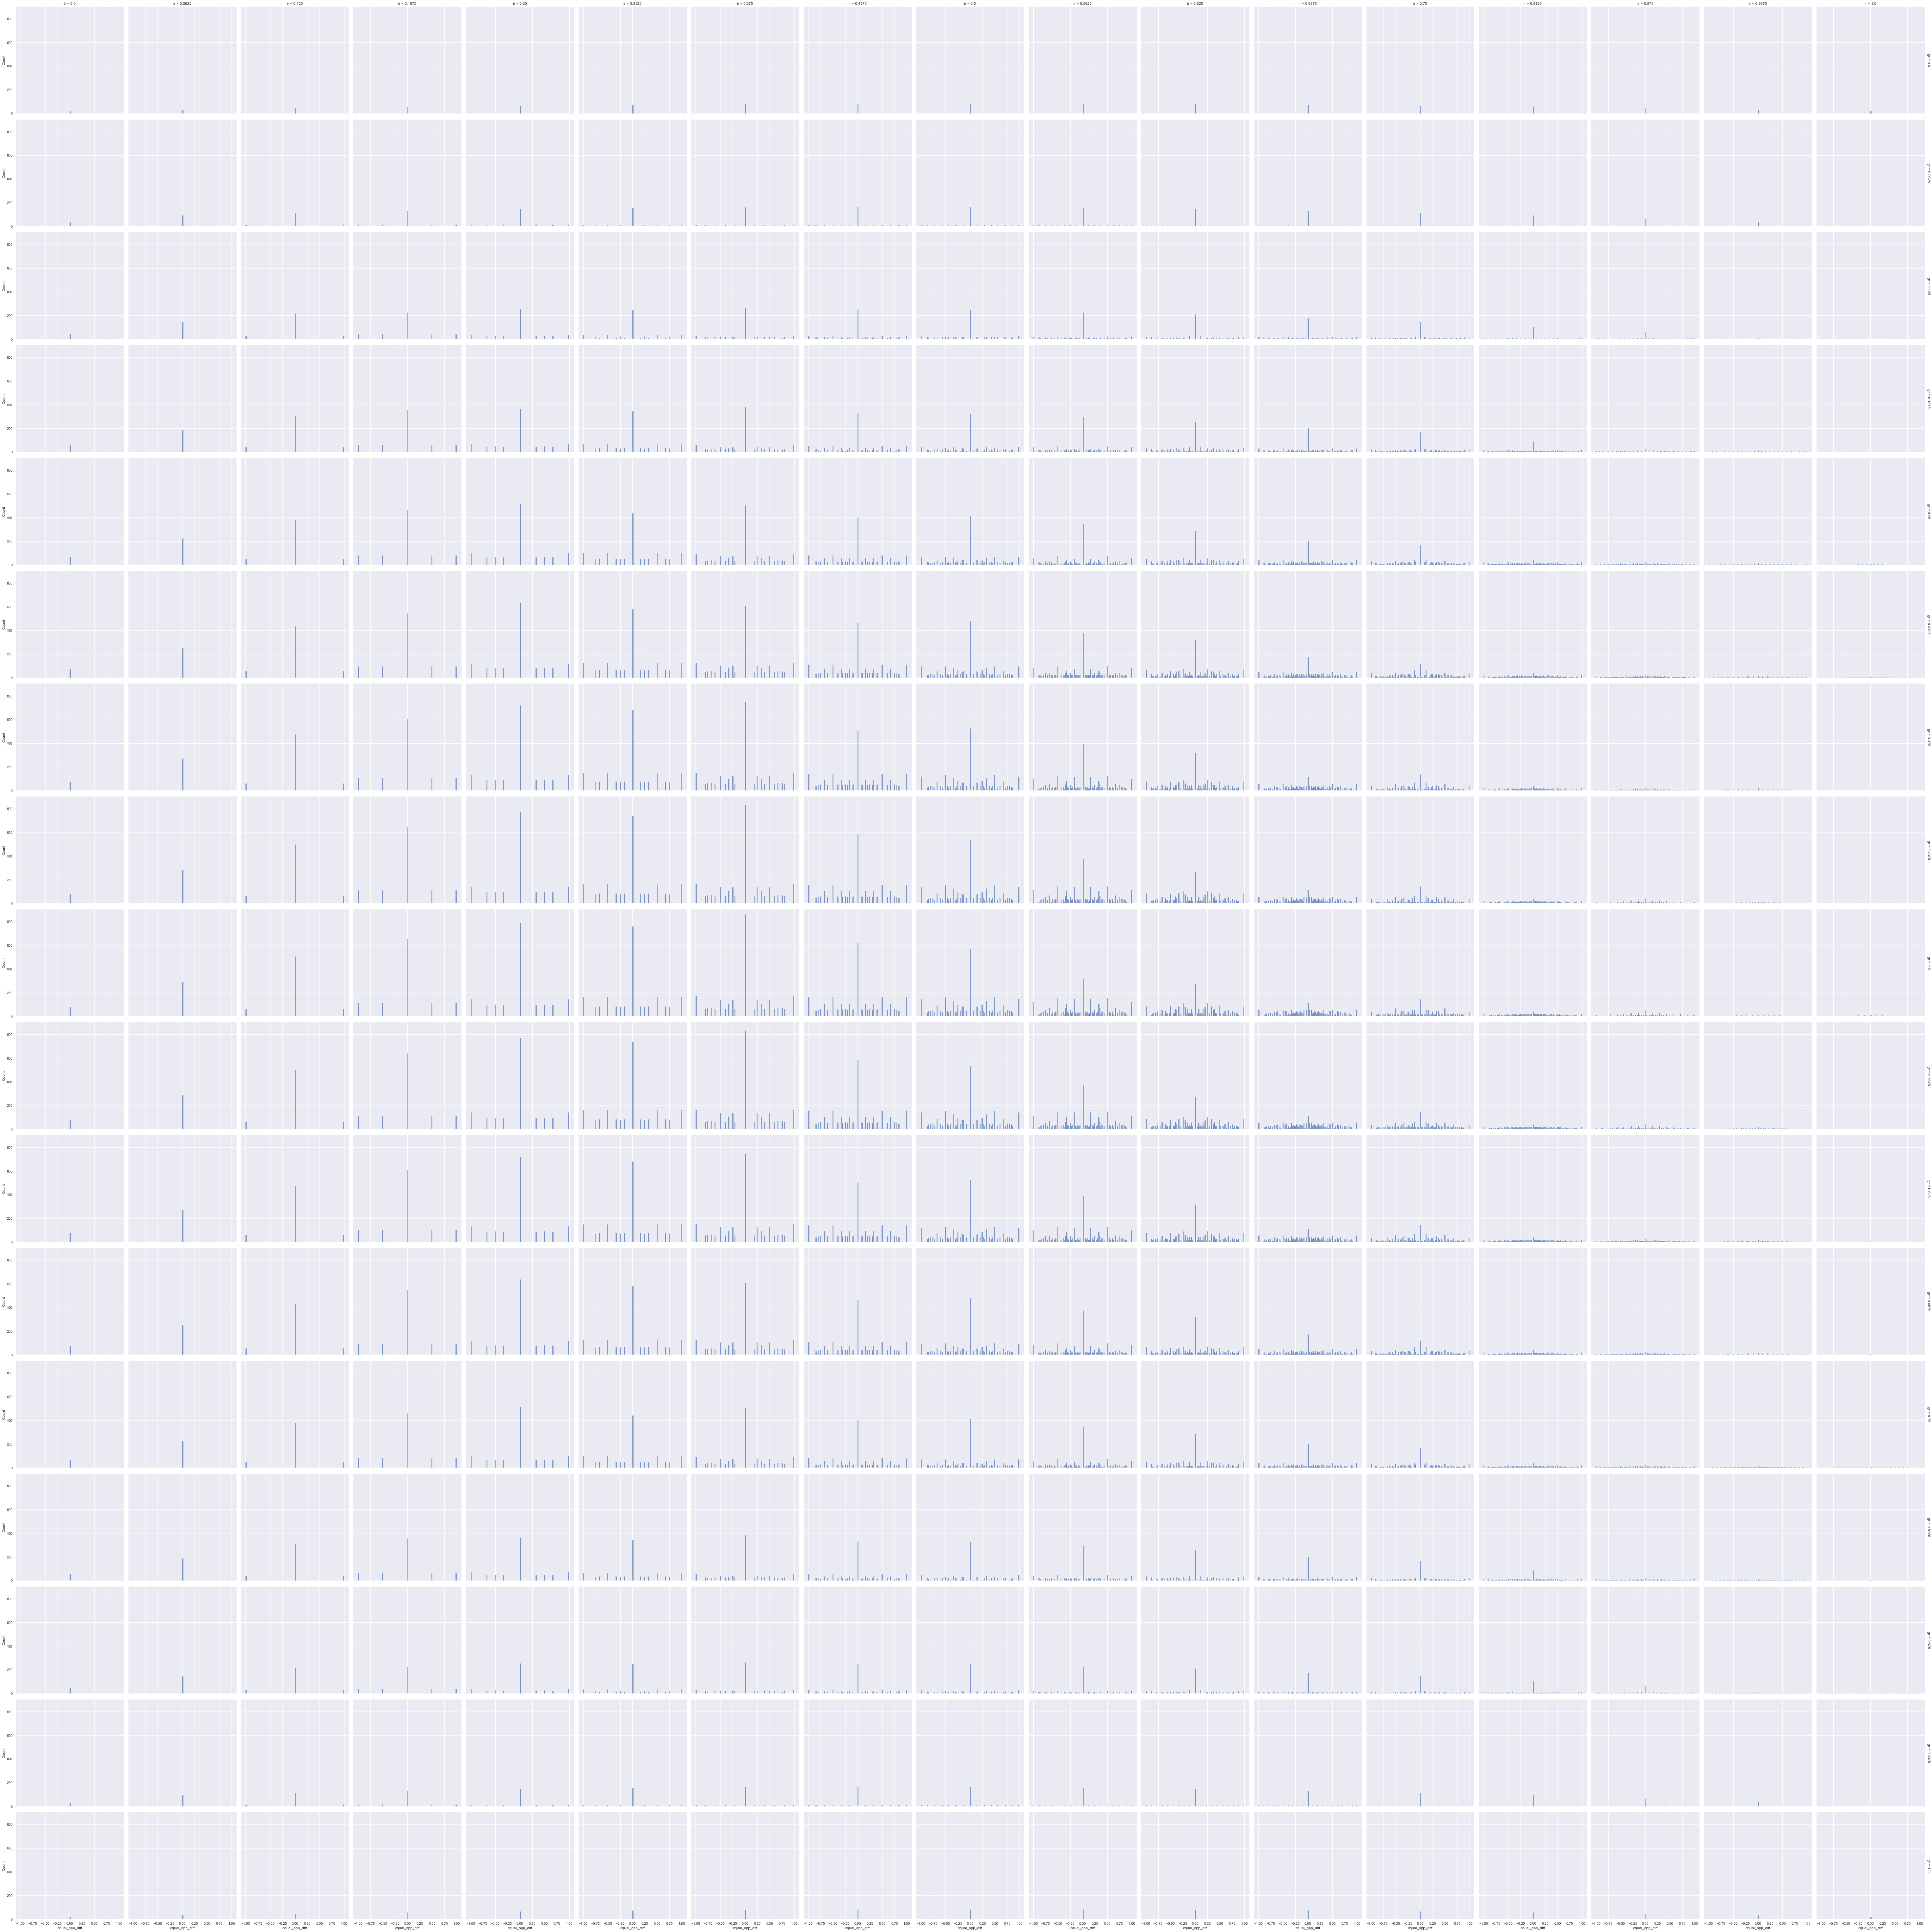

----------------------------- stat_parity -----------------------------


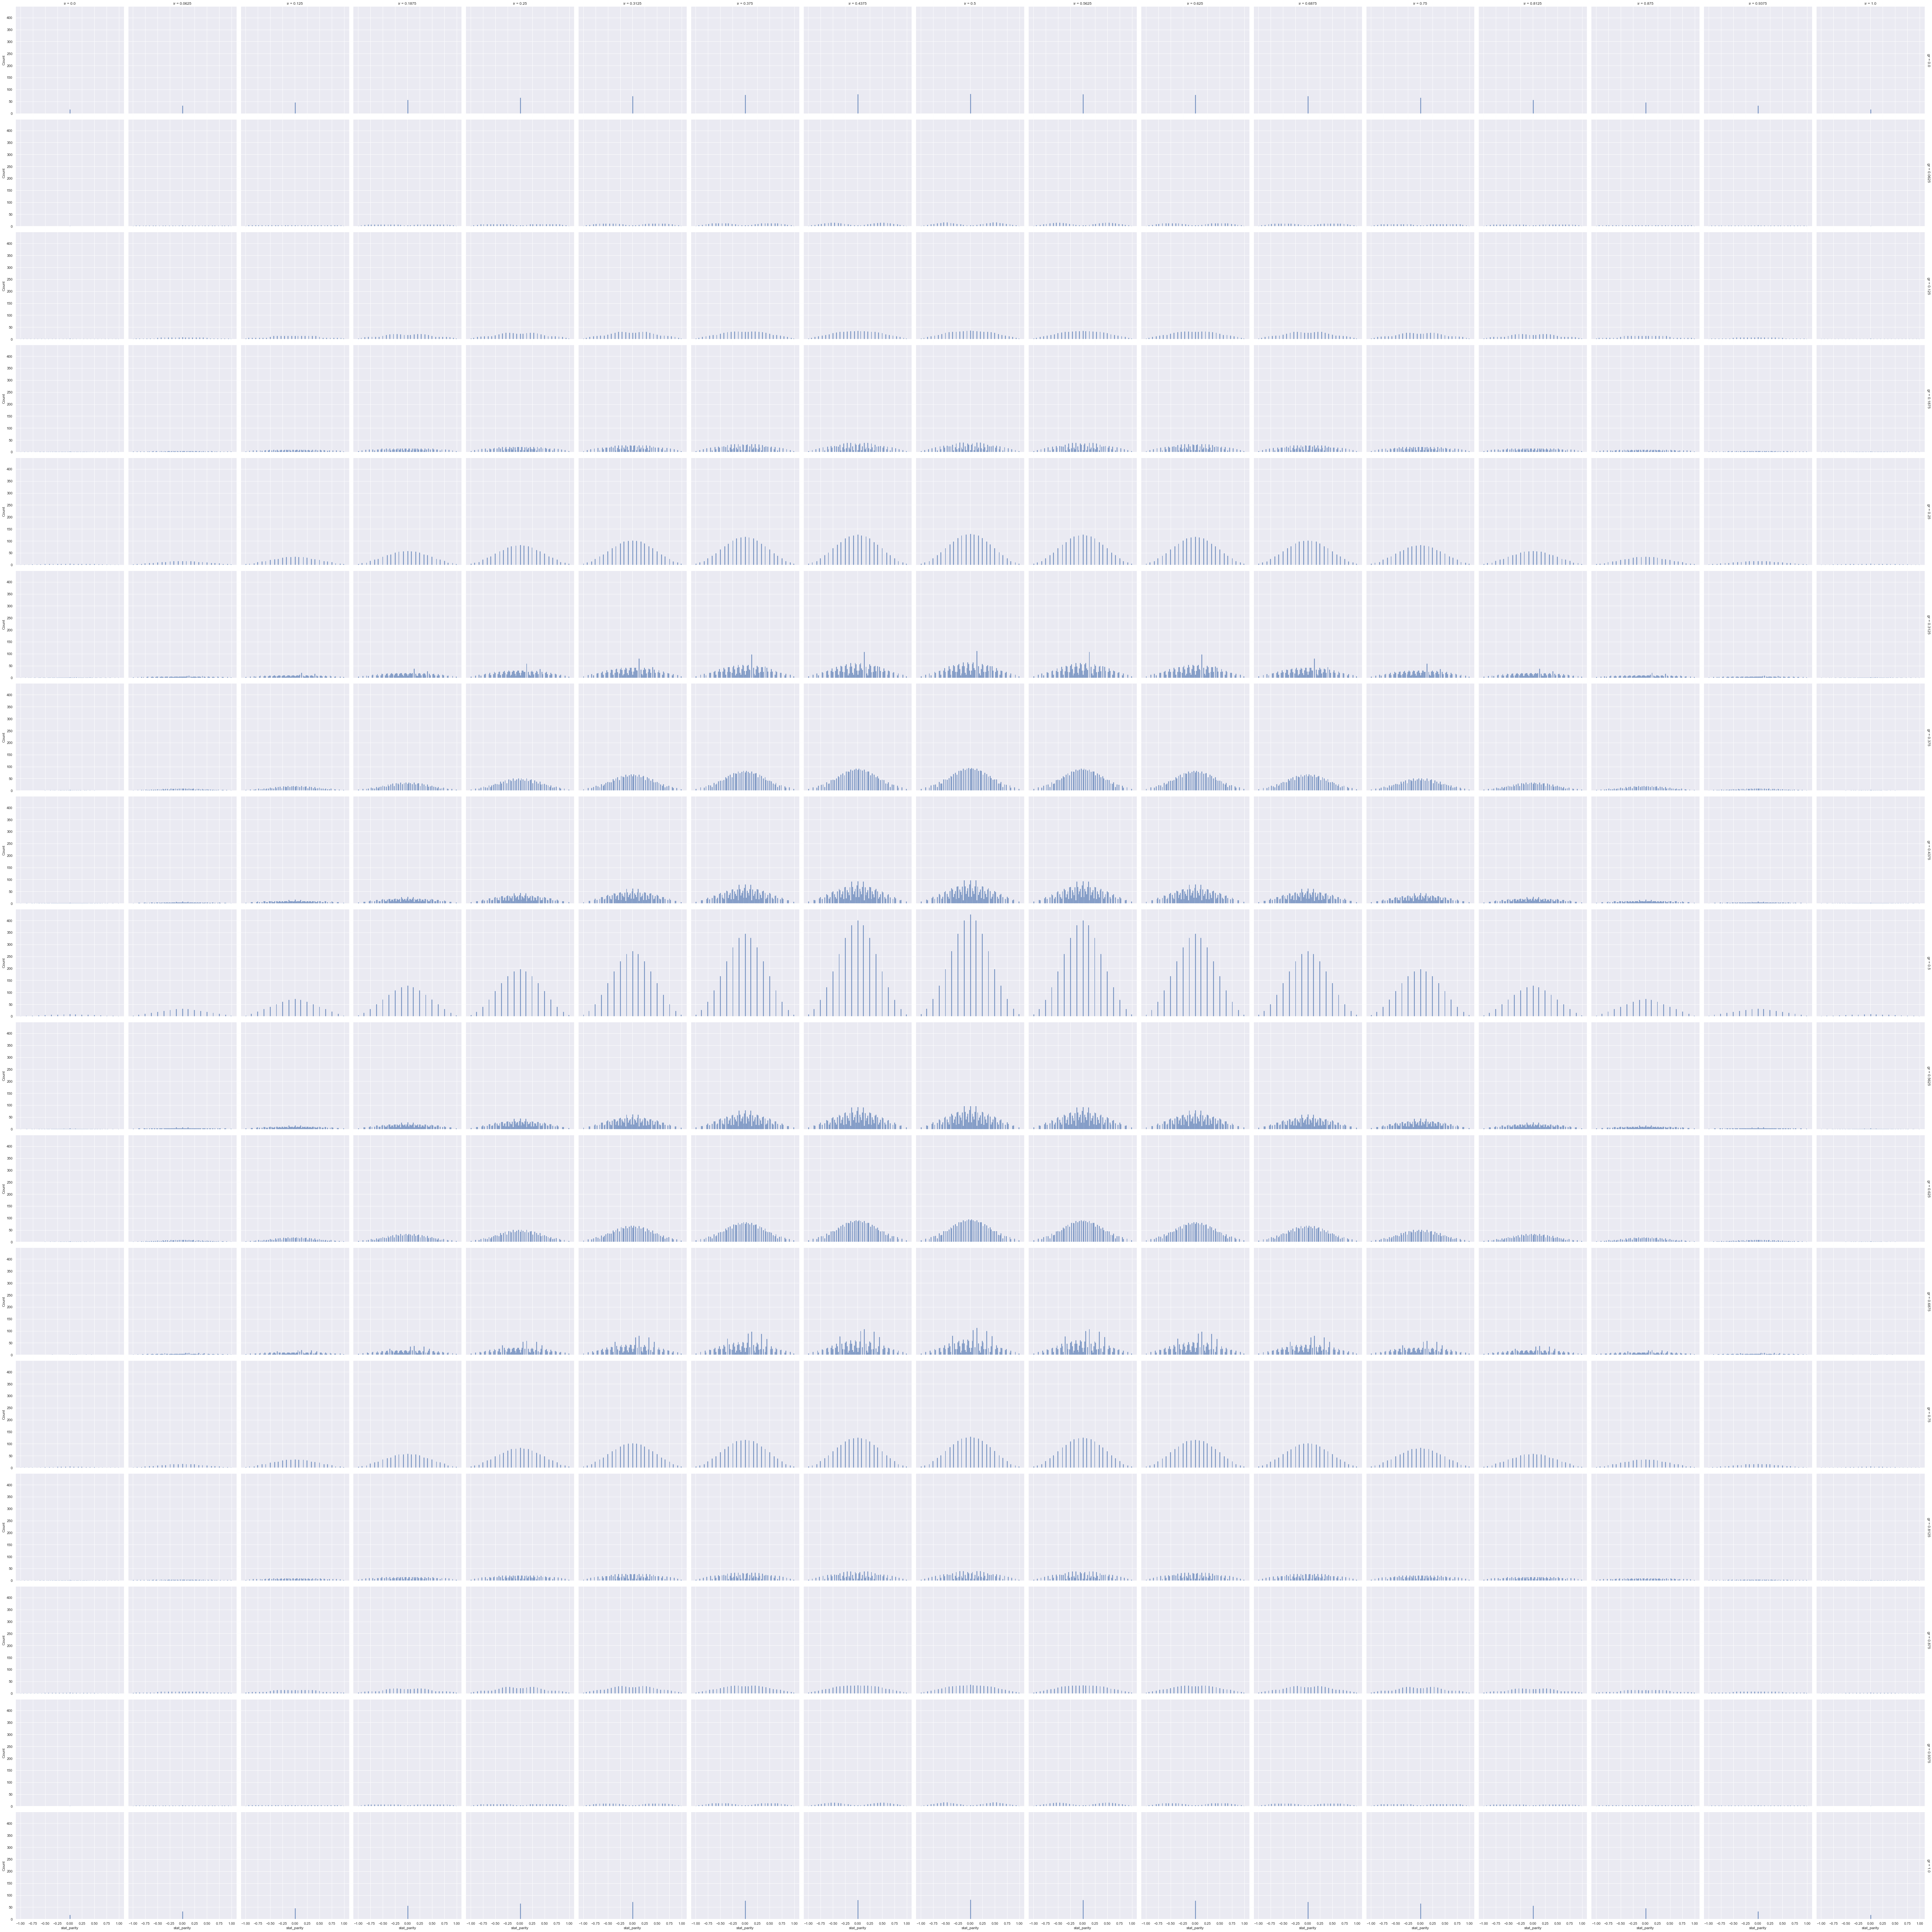

----------------------------- disp_impact -----------------------------


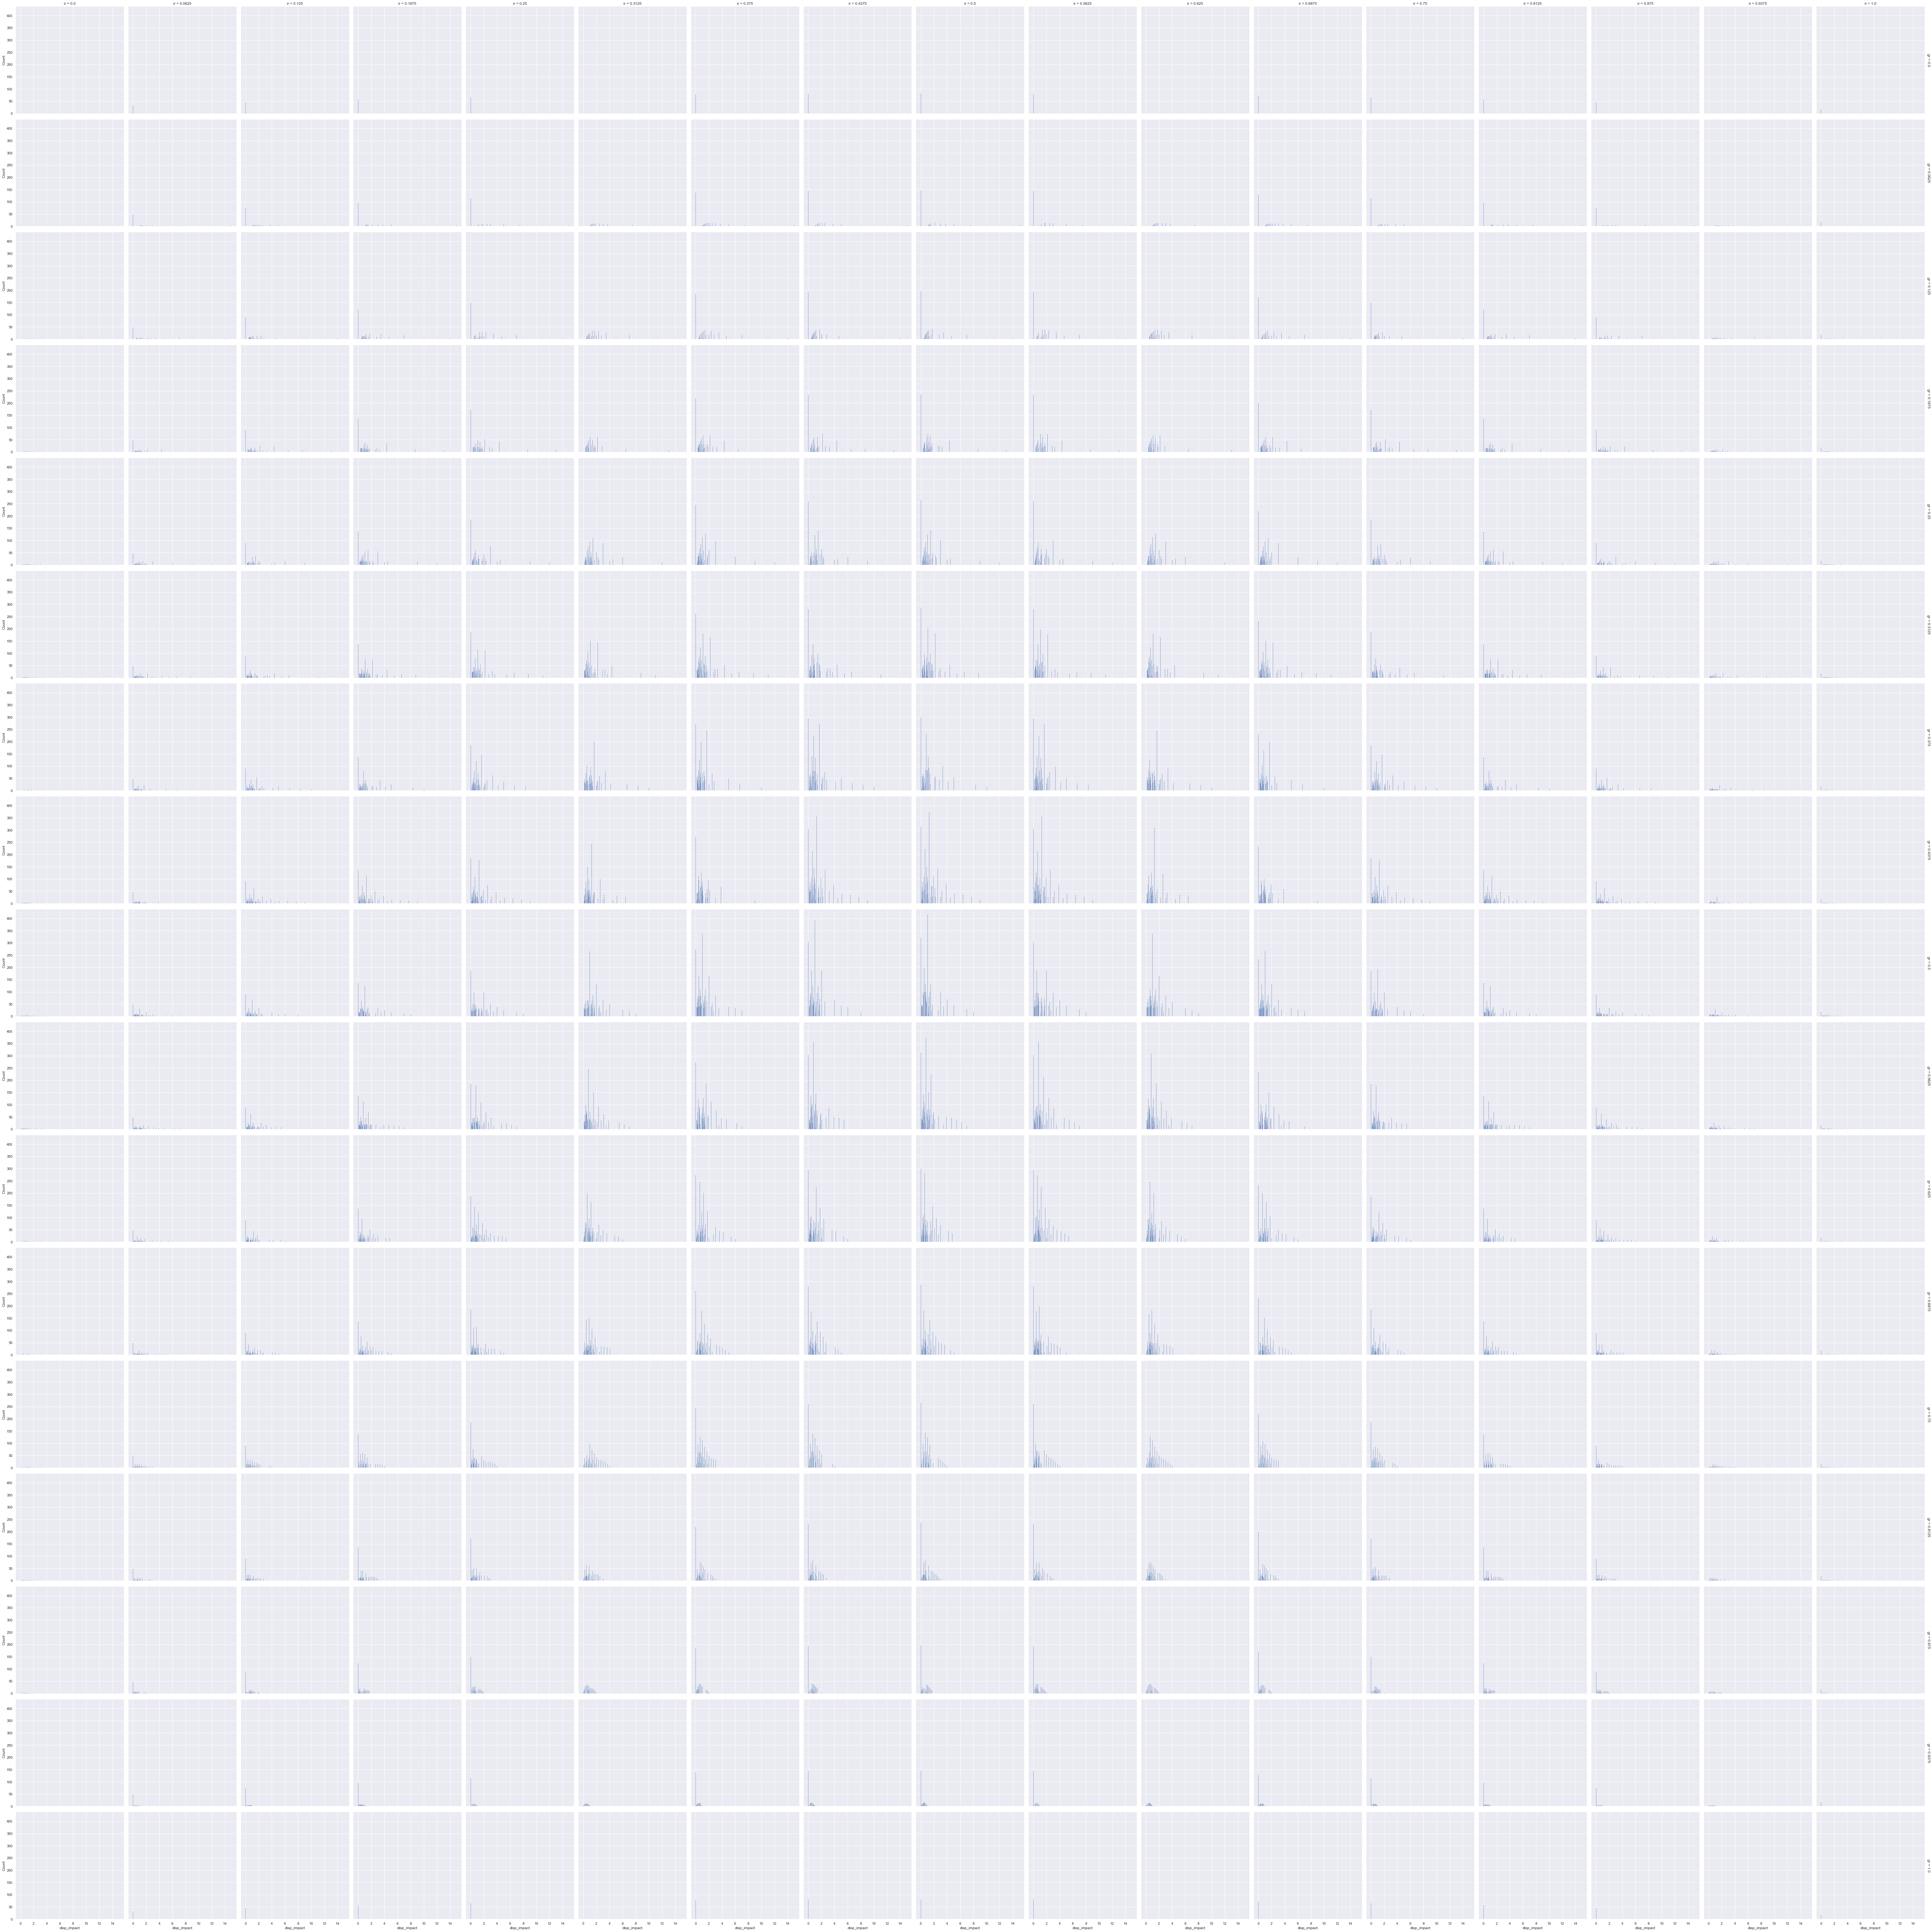

----------------------------- acc_equality_ratio -----------------------------


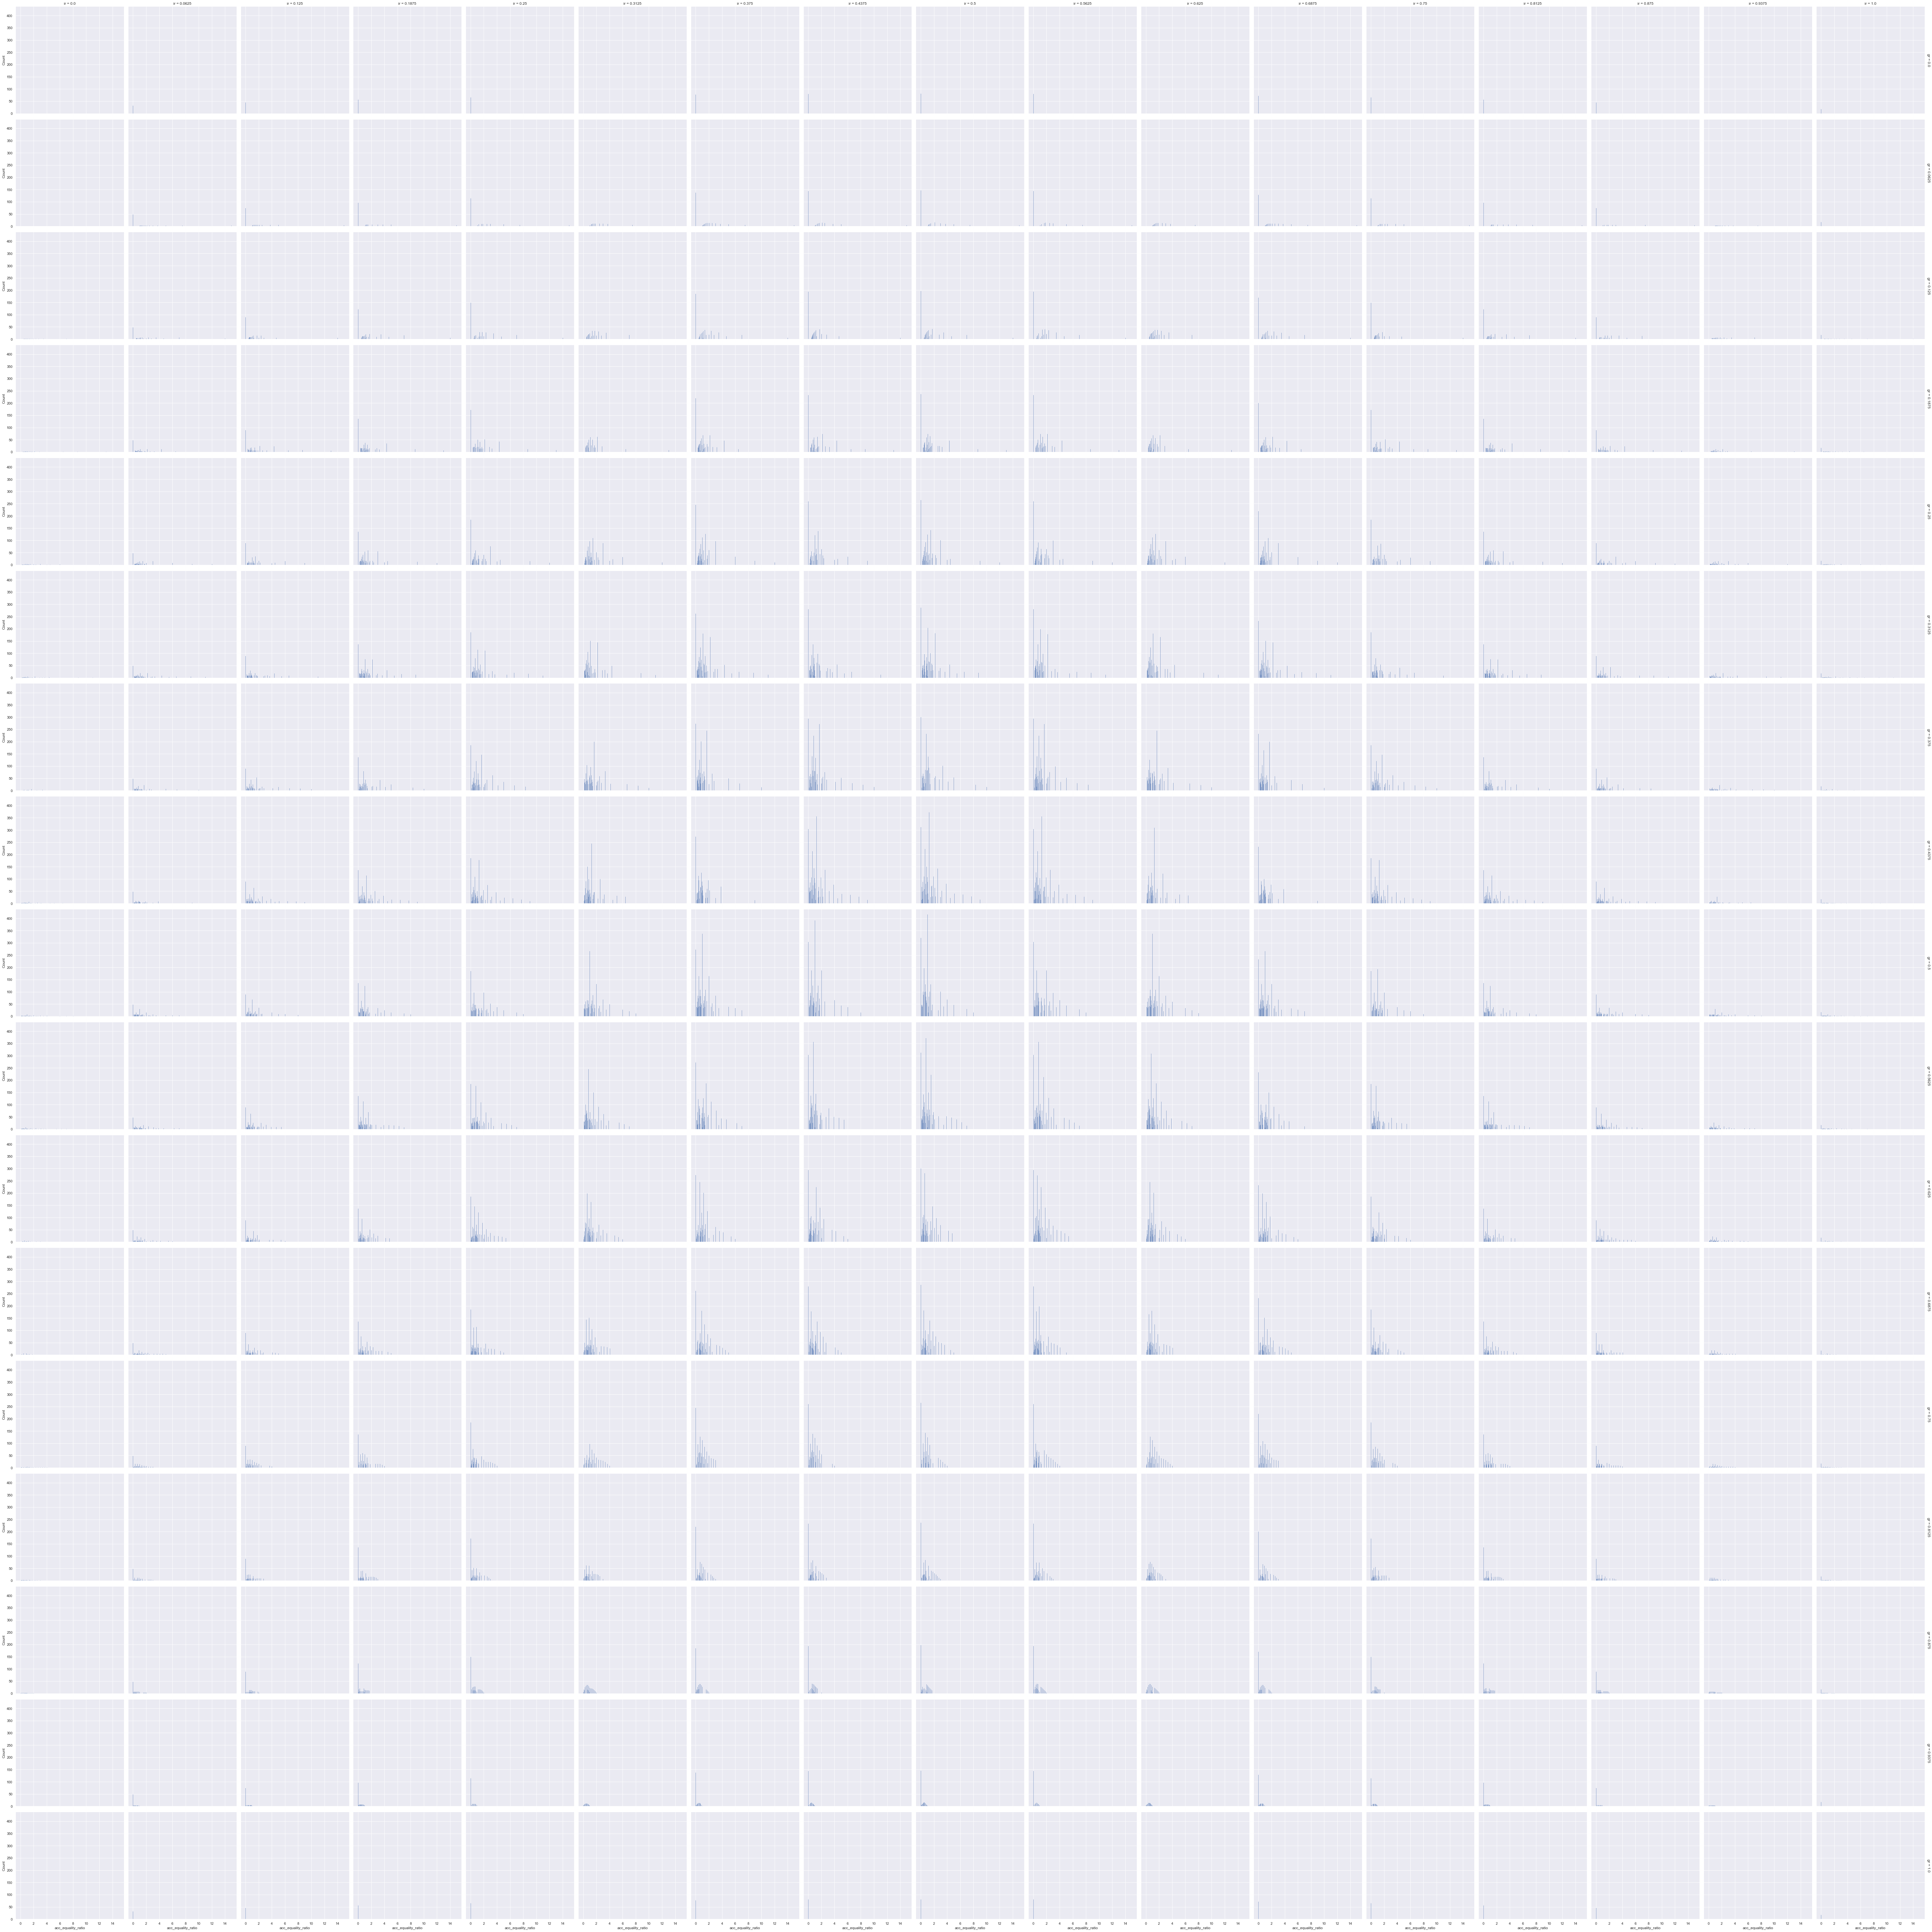

----------------------------- acc_equality_diff -----------------------------


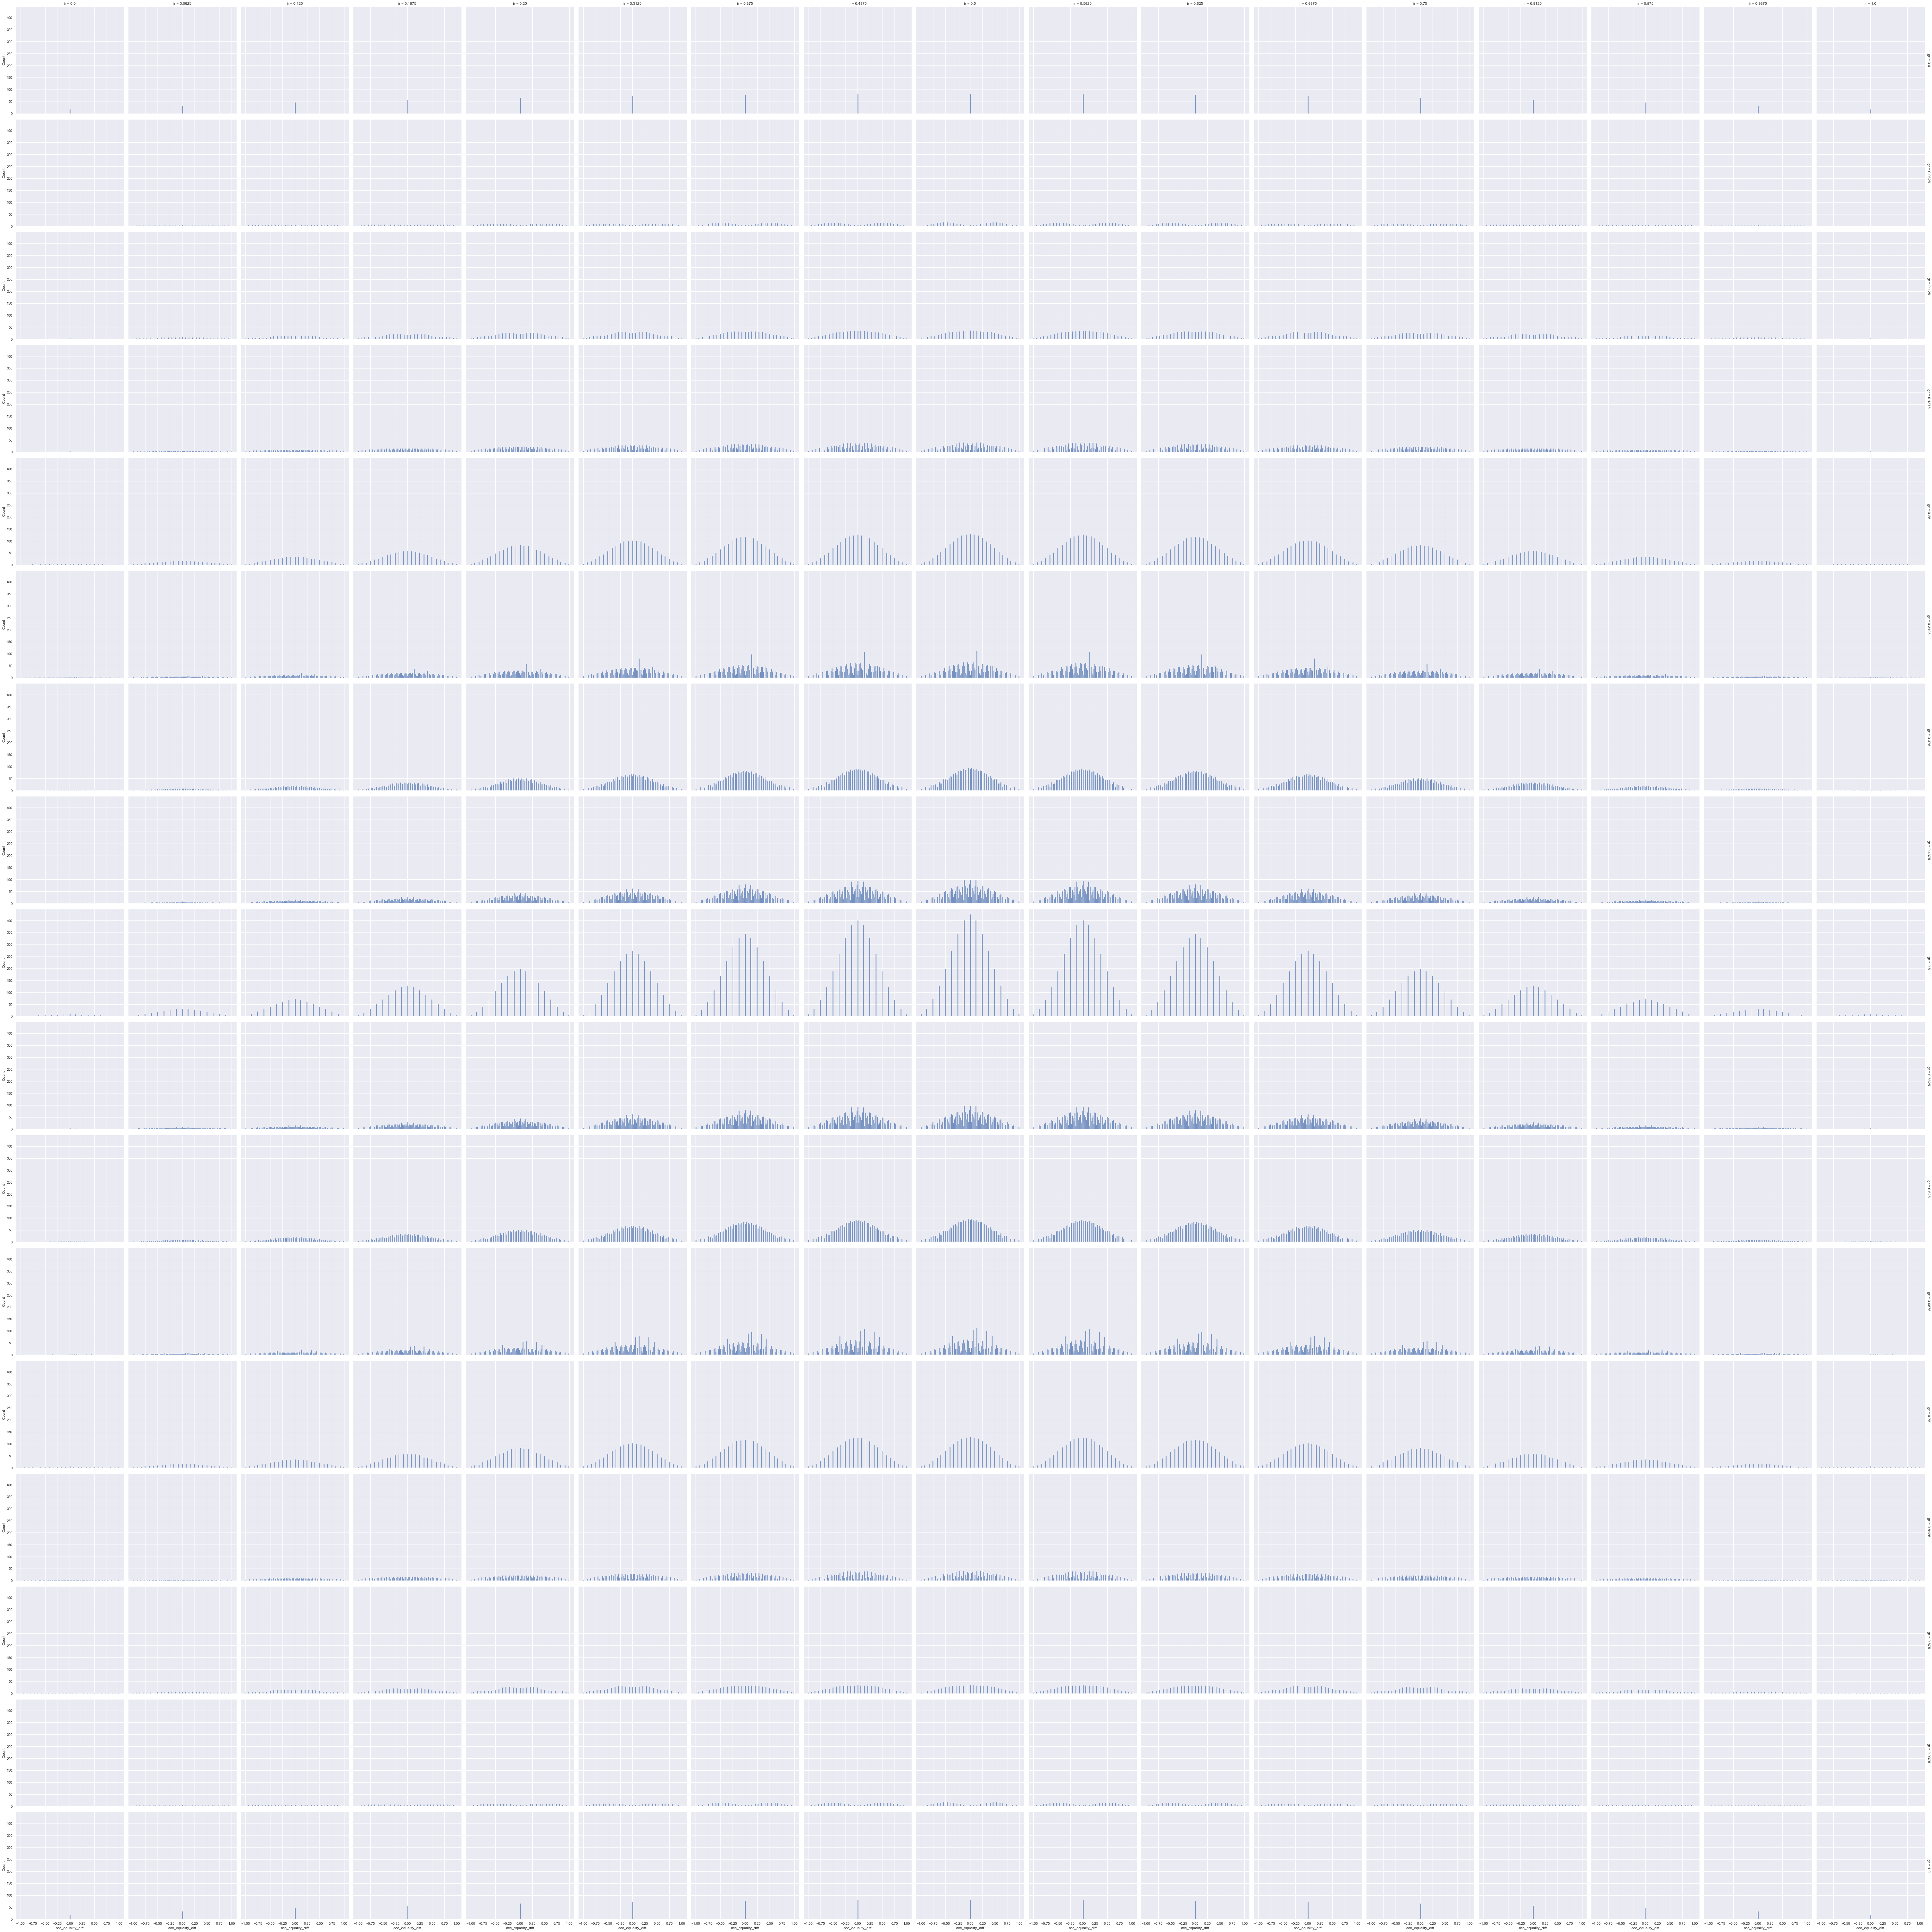

----------------------------- pred_equality_ratio -----------------------------


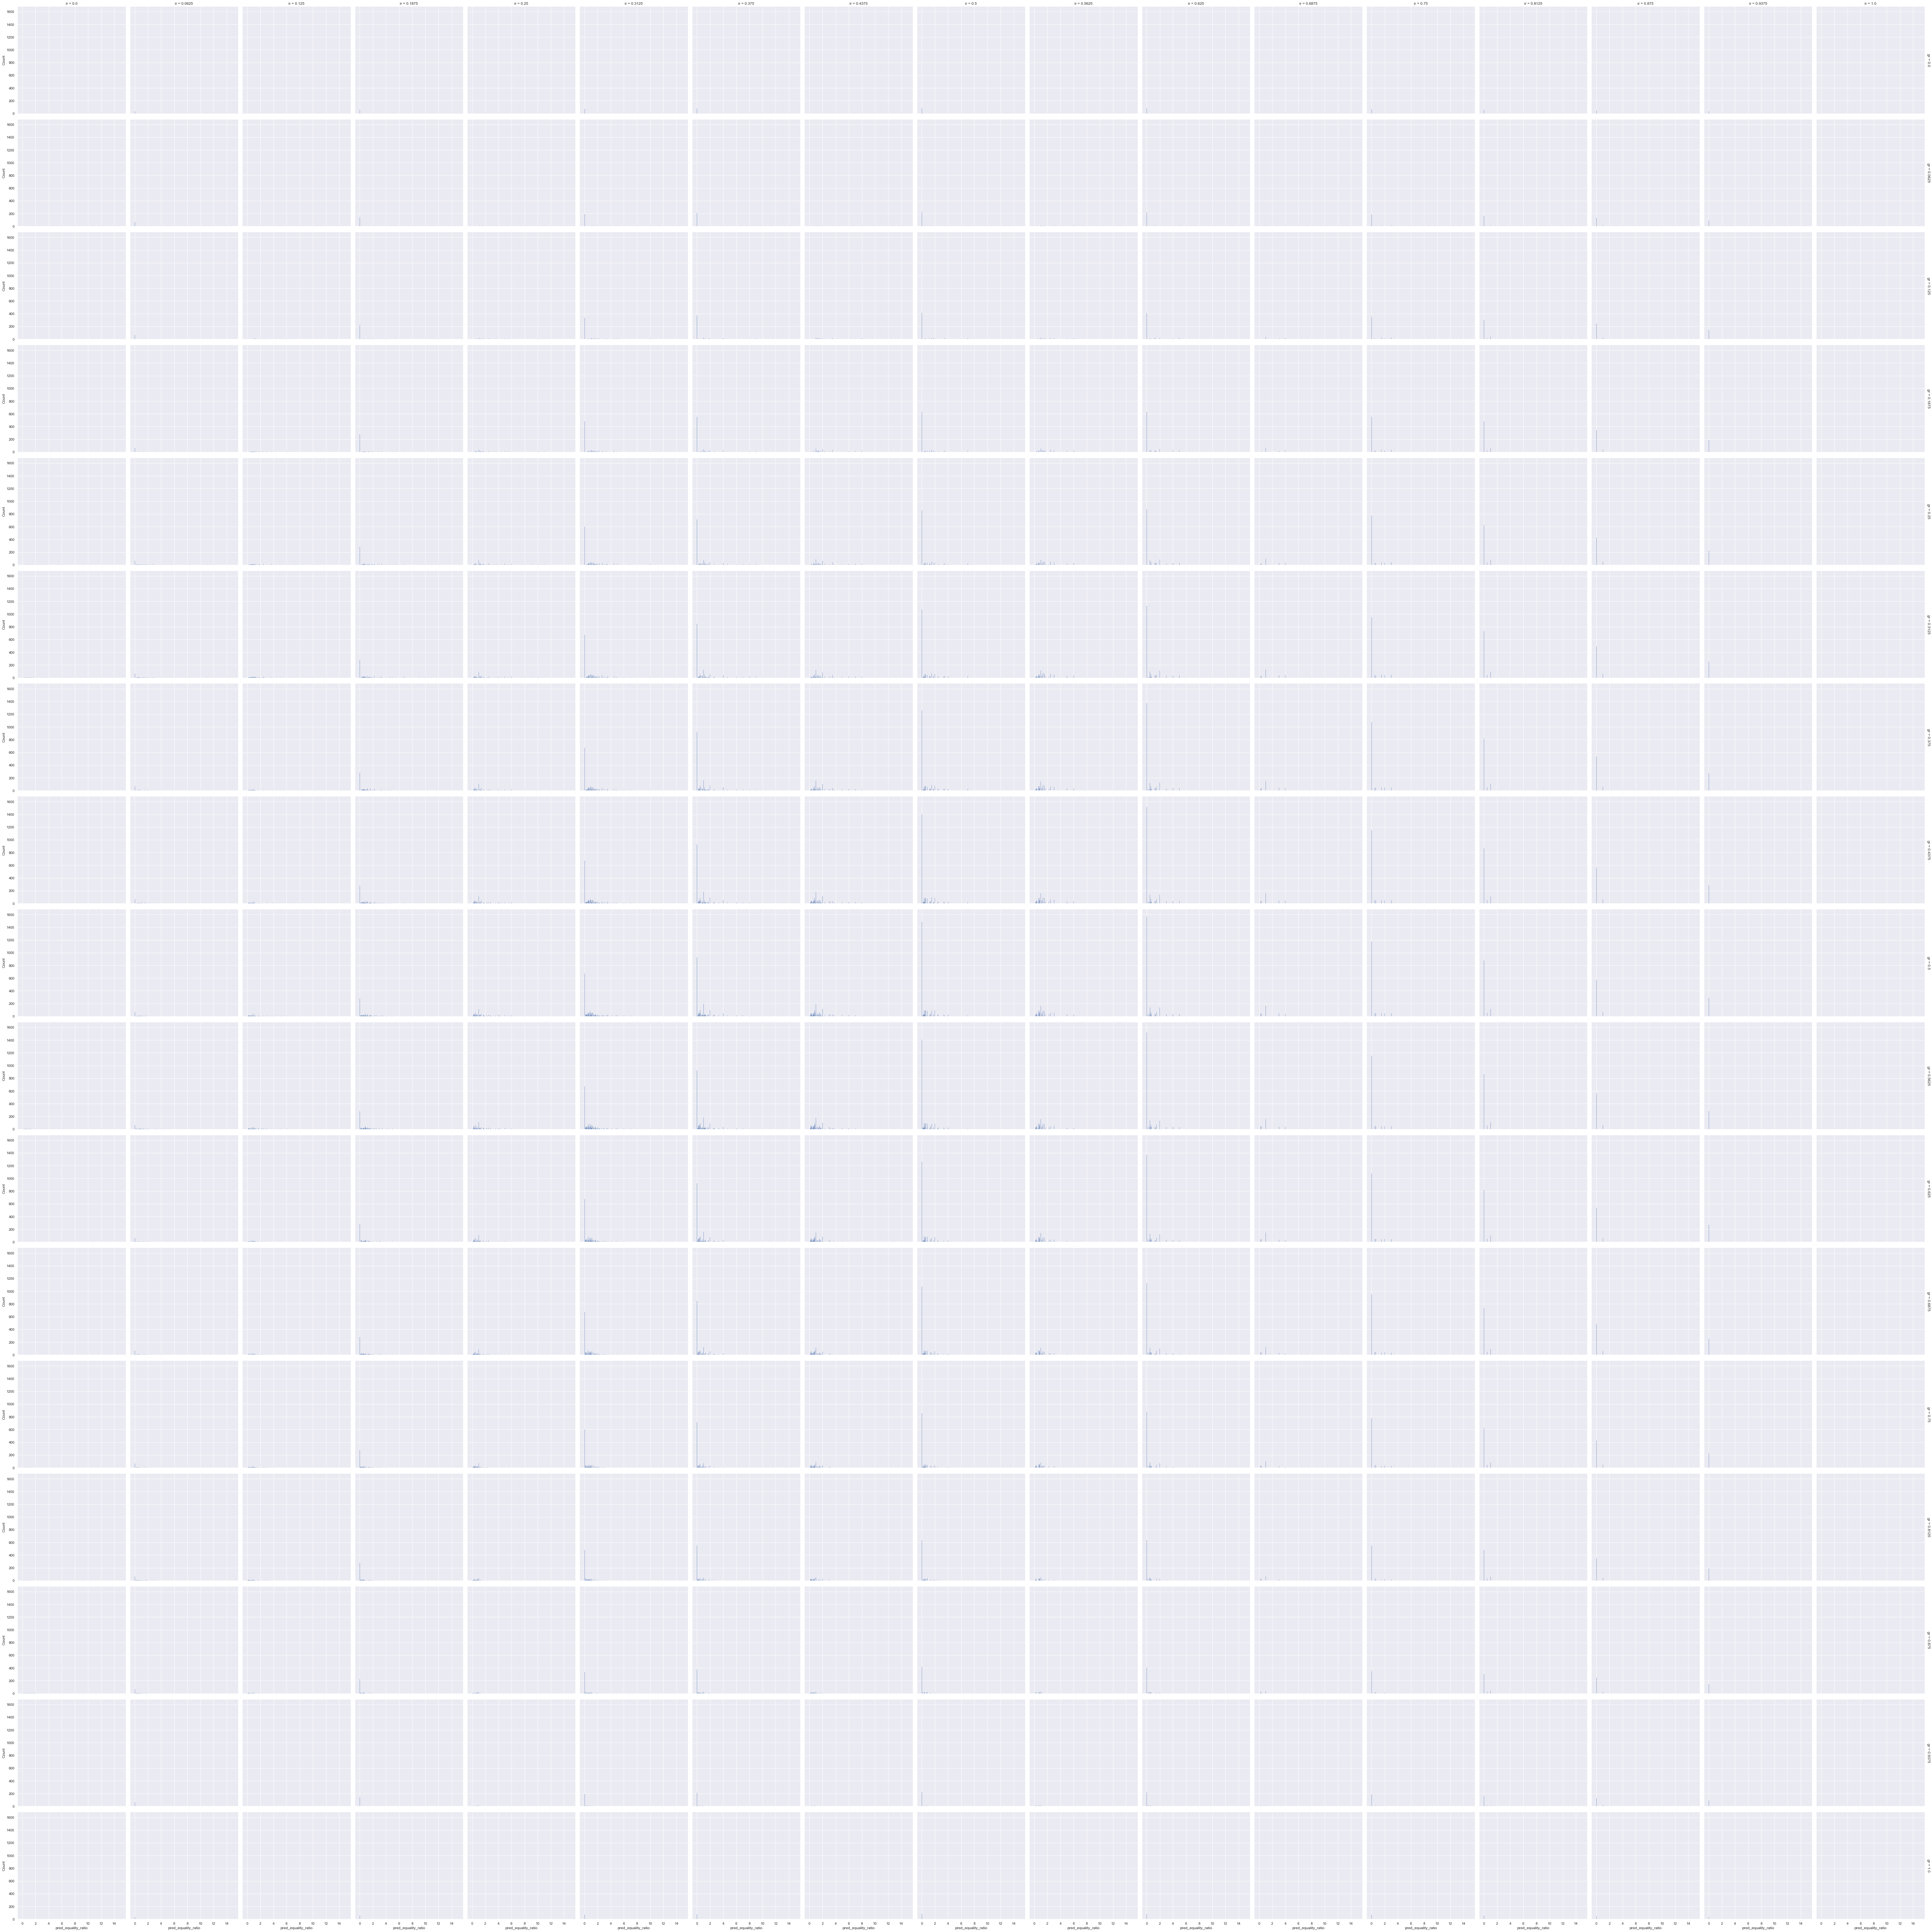

----------------------------- pred_equality_diff -----------------------------


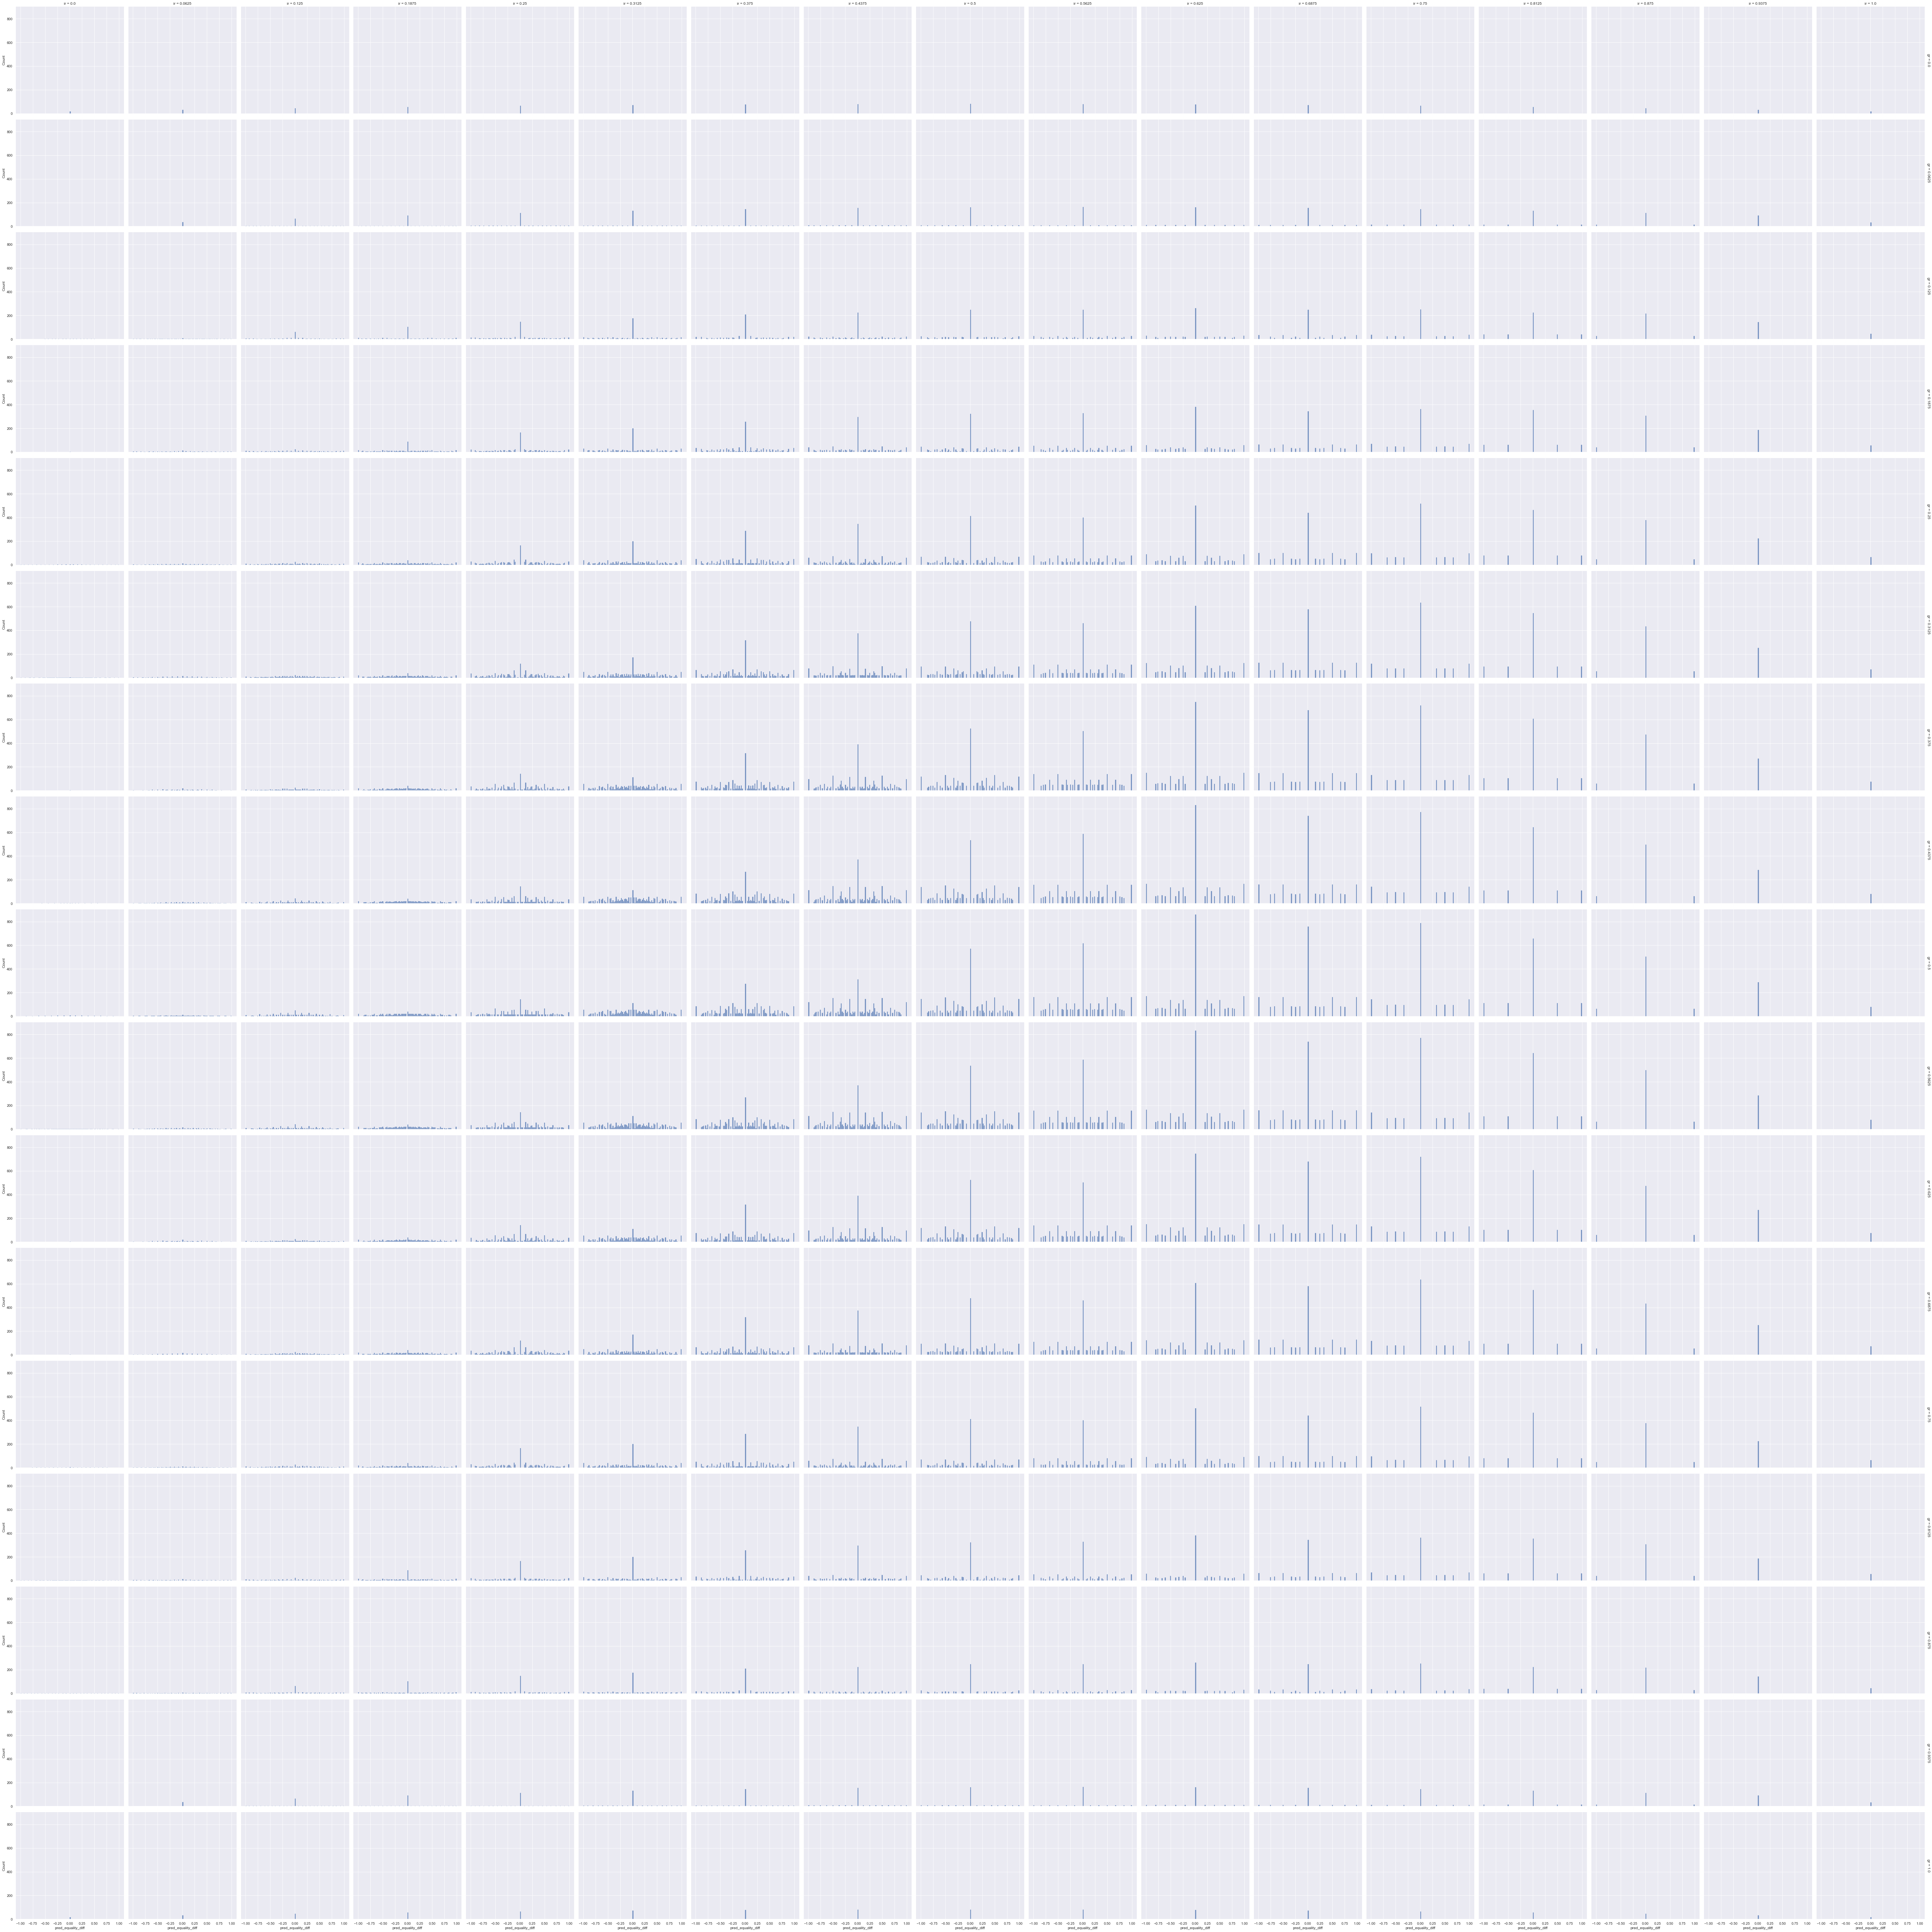

----------------------------- pred_parity_ratio -----------------------------


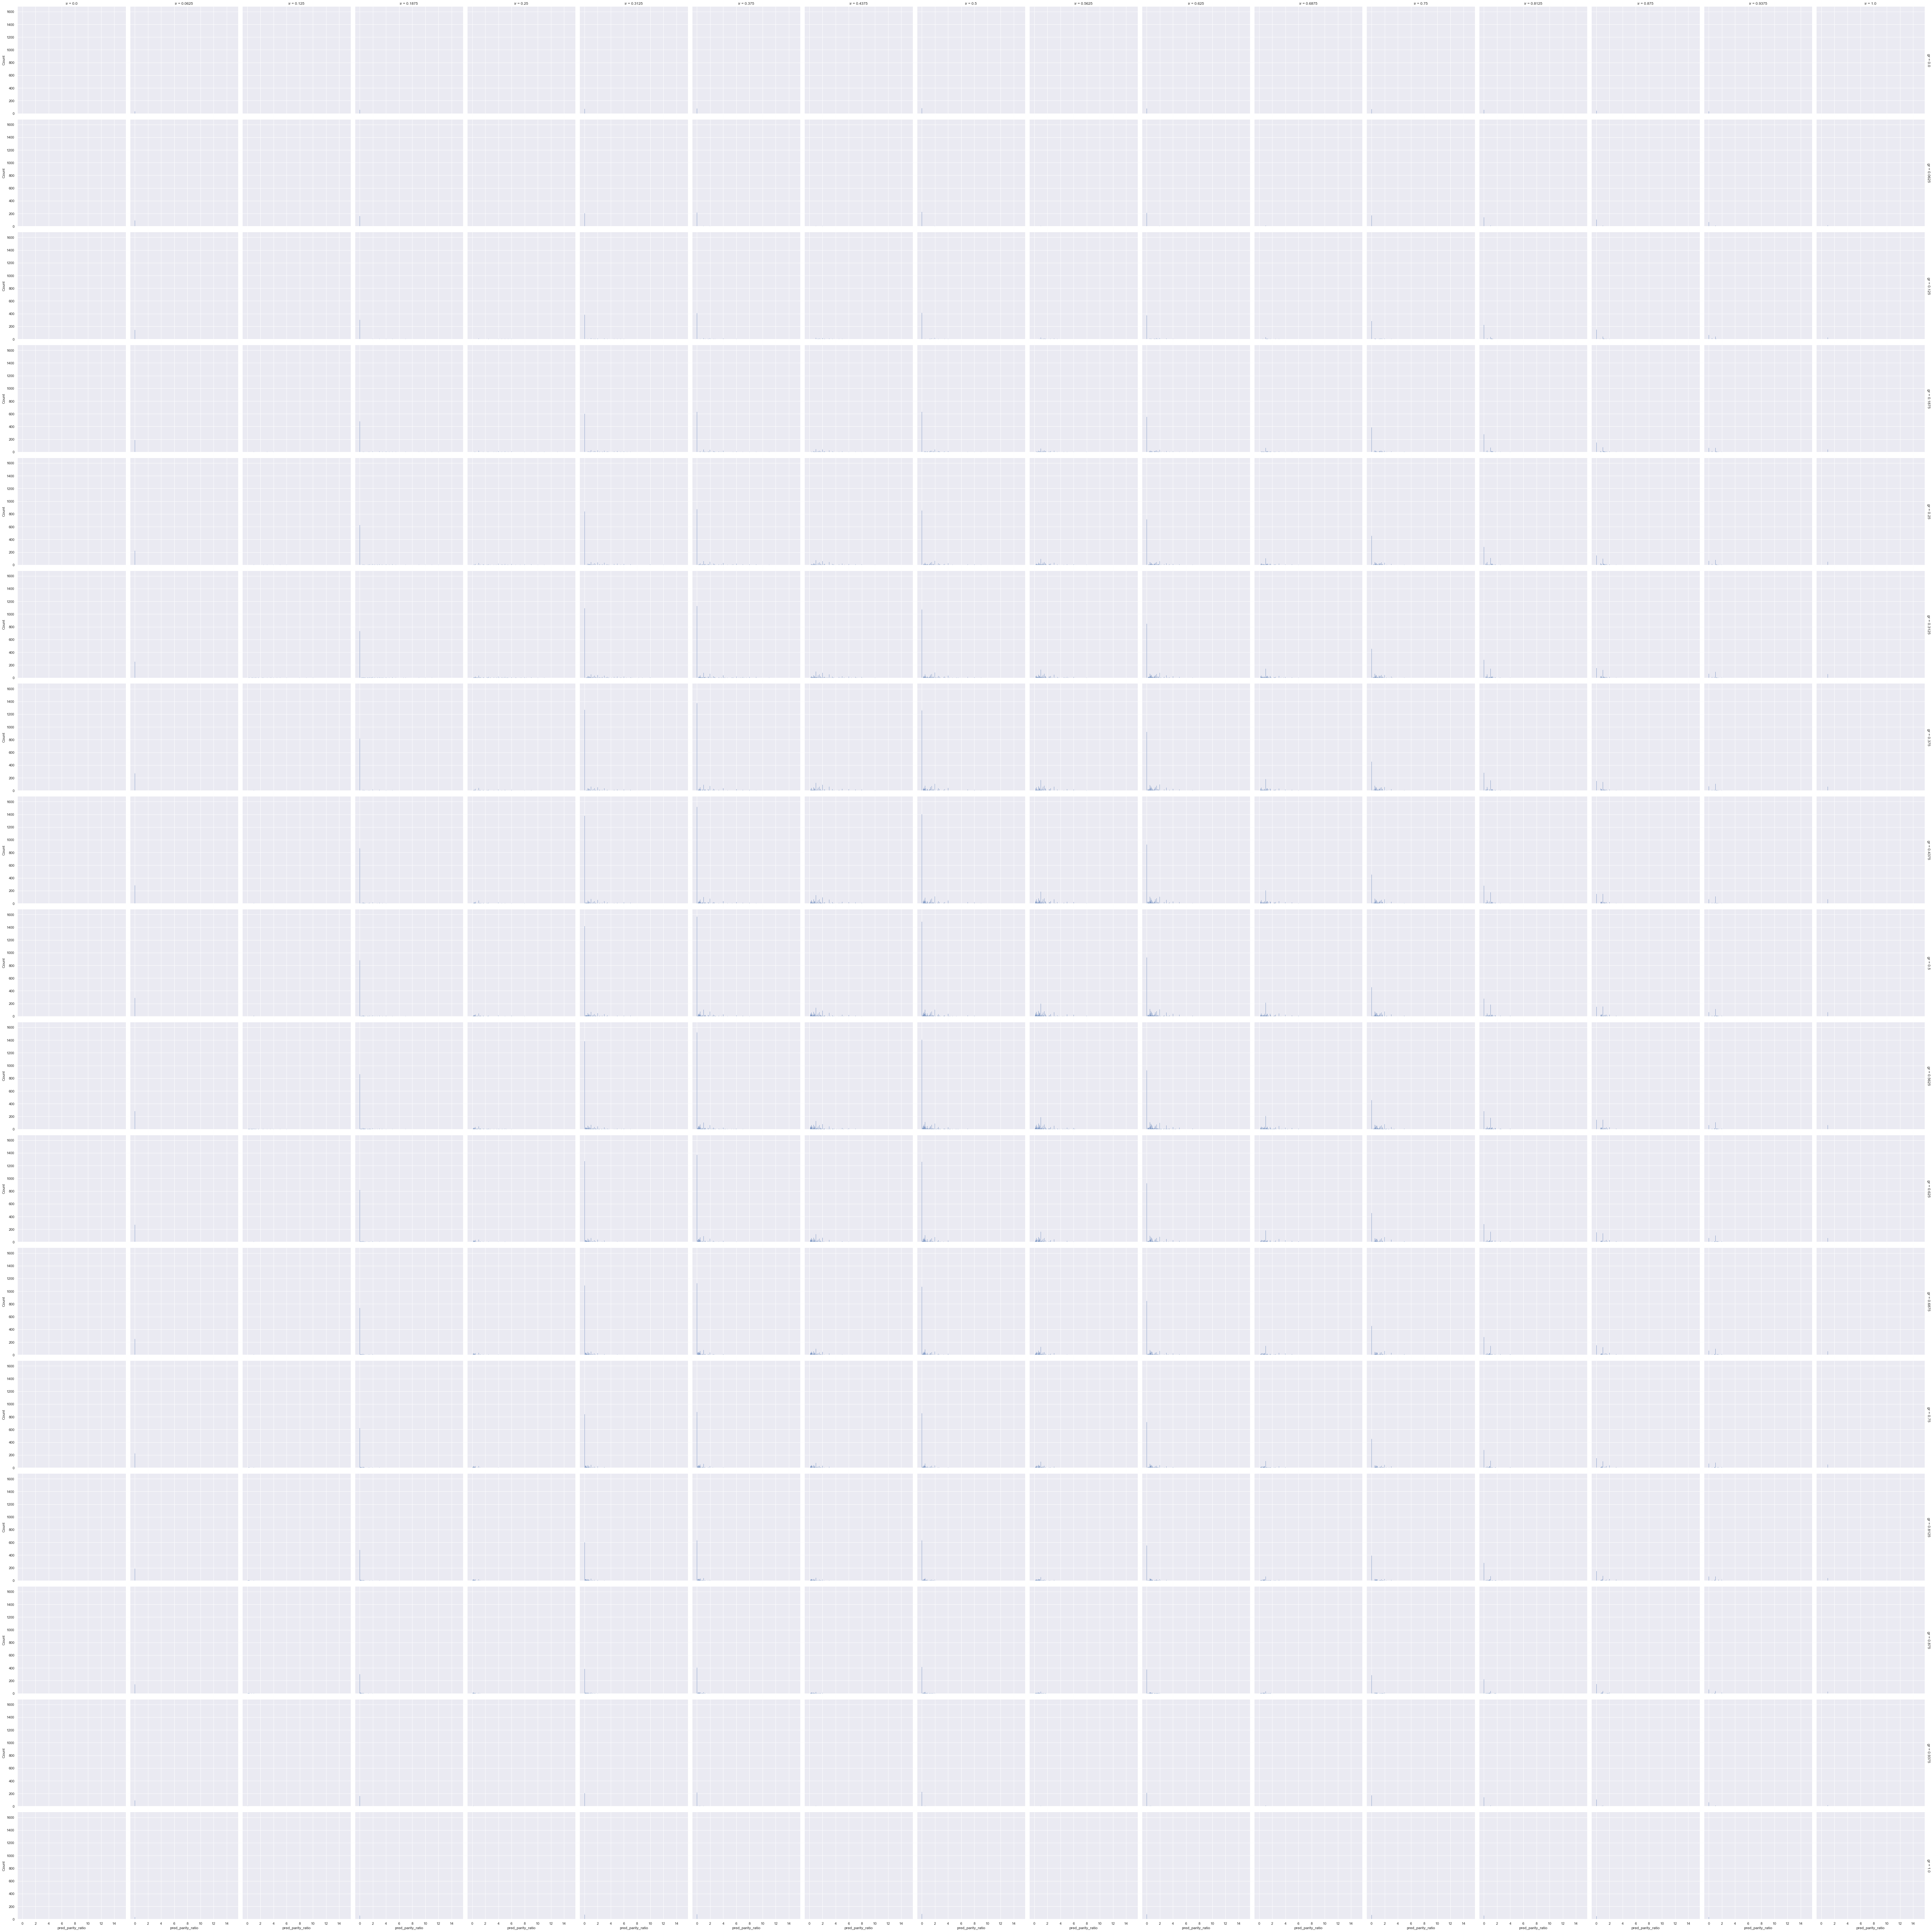

----------------------------- pred_parity_diff -----------------------------


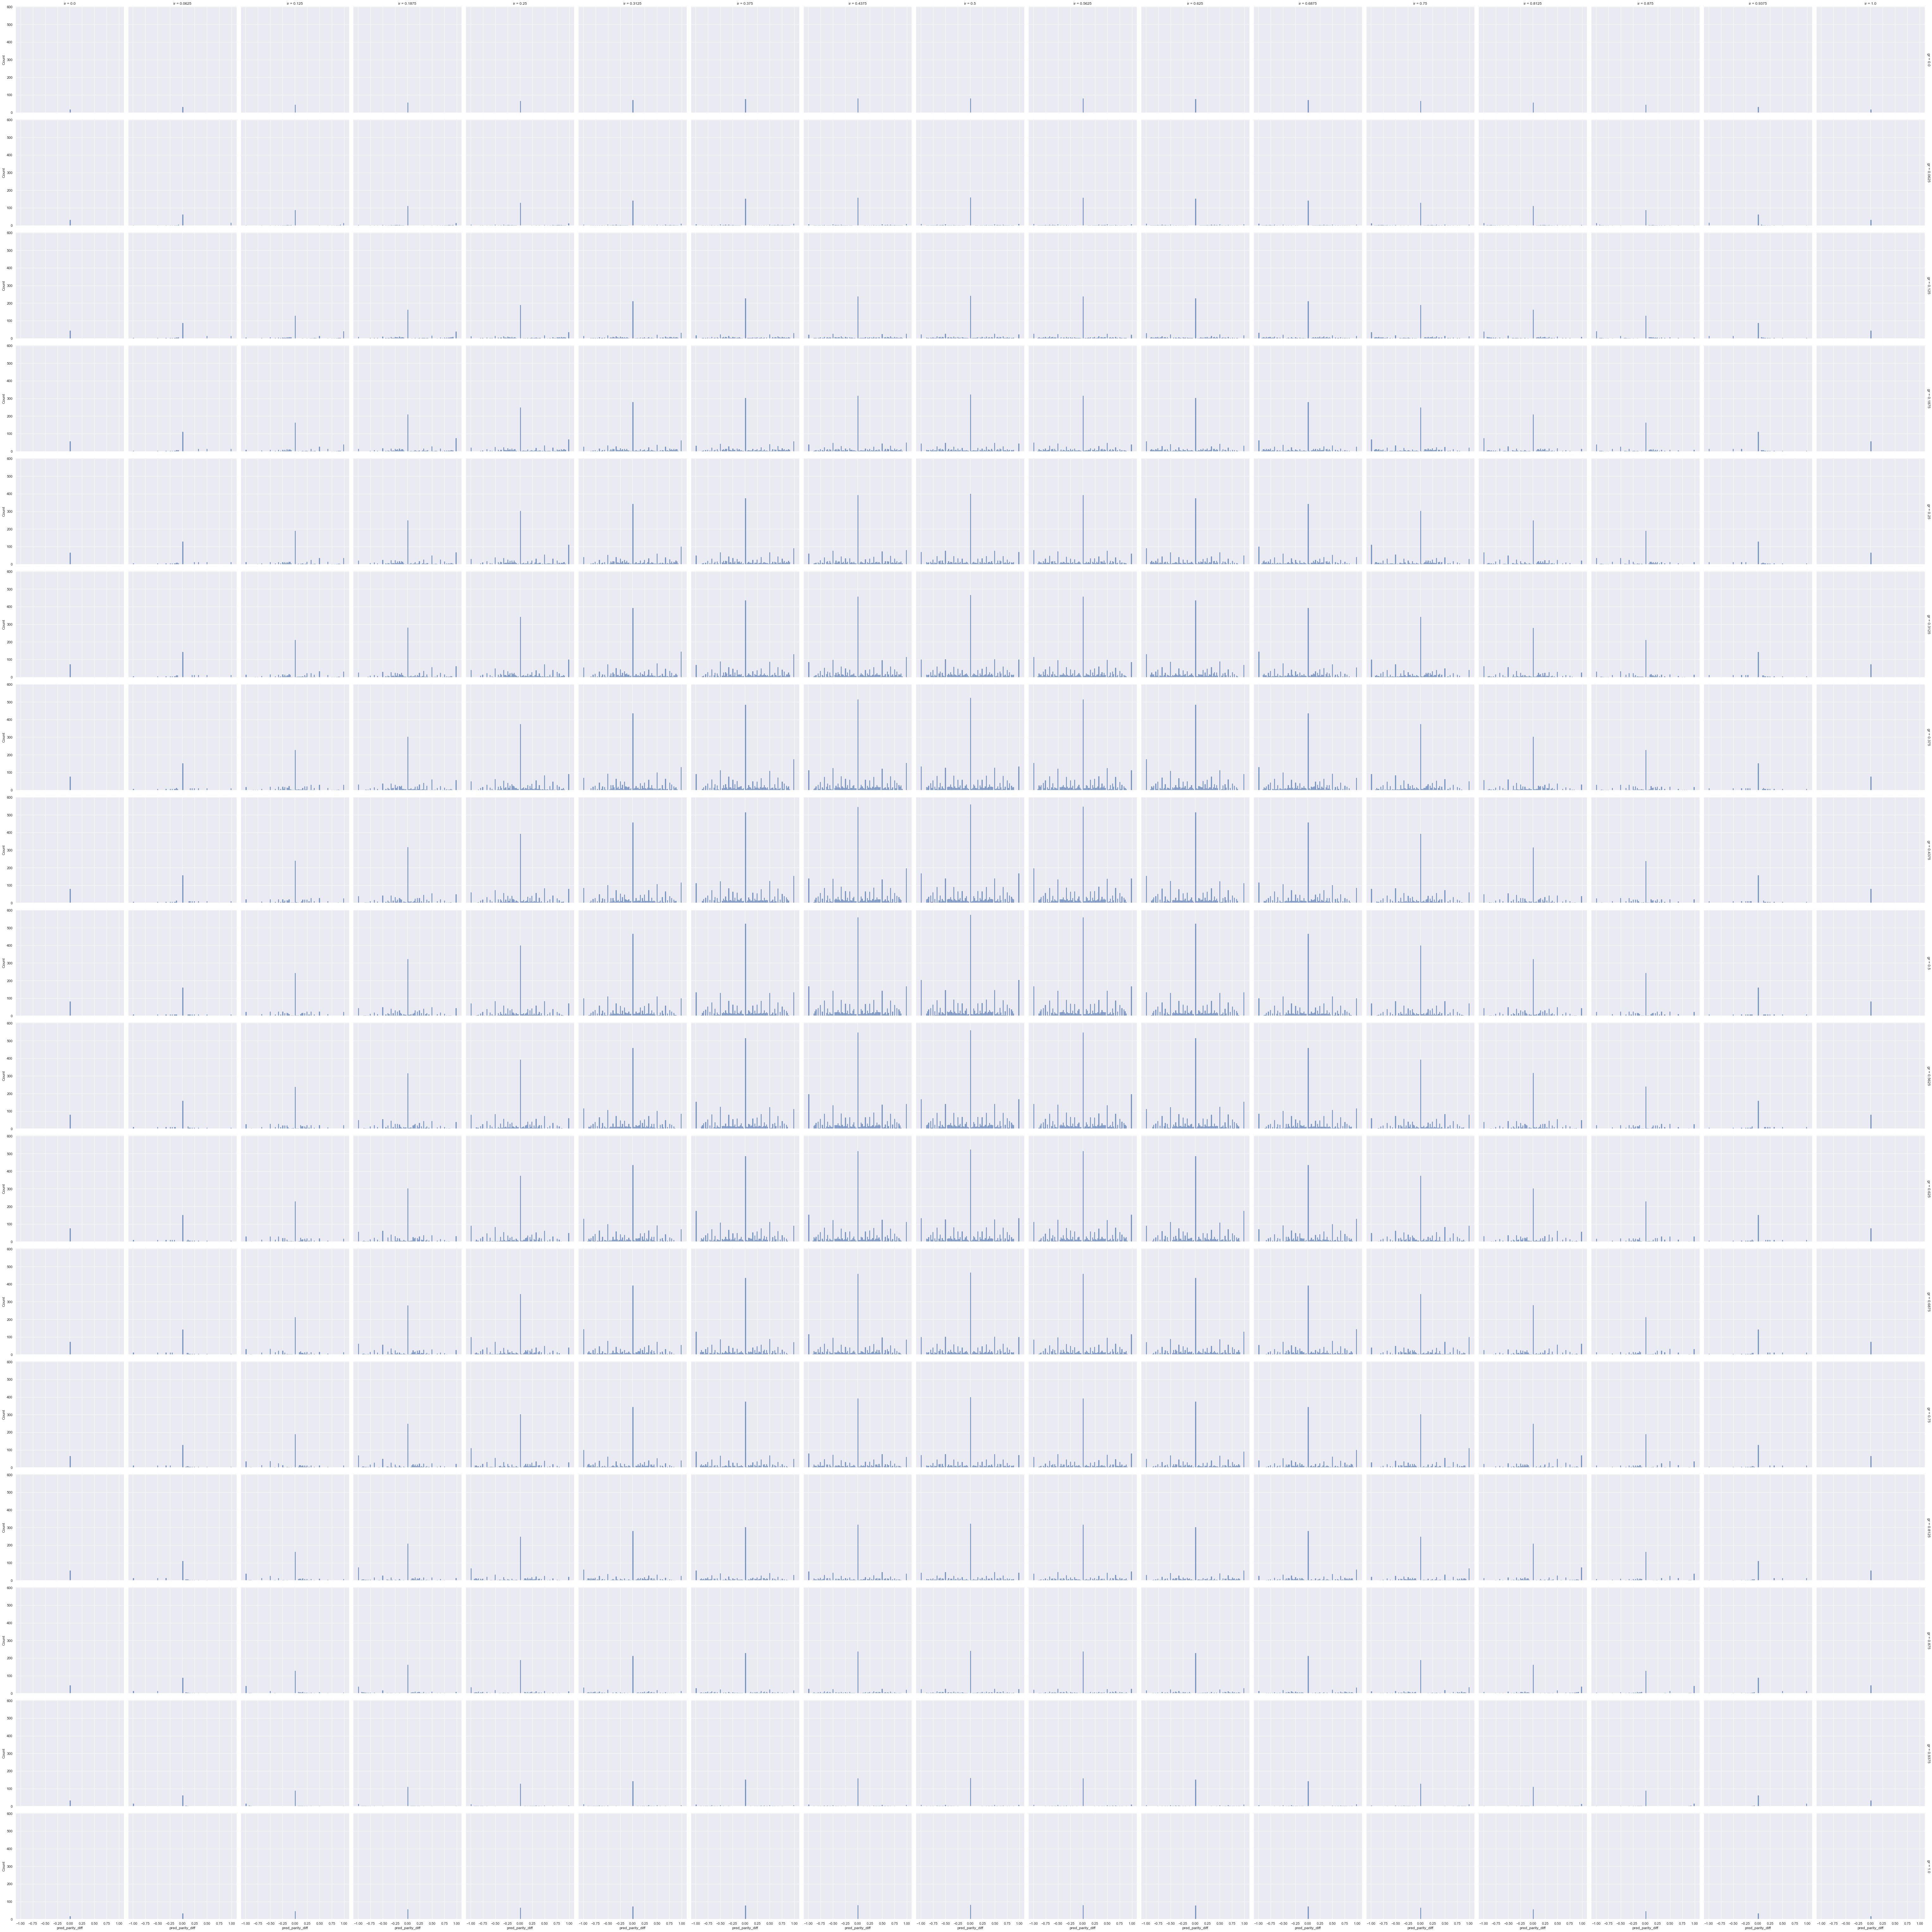

In [5]:
for fm in fm_list:
    
    print("-----------------------------",fm,"-----------------------------")
    
    sns.set(rc={'figure.figsize':(12.7,8.6)})
    sns.displot(
    df, x=fm, col="ir", row="gr", 
#     aspect=5,
#     height=20, 
    facet_kws=dict(margin_titles=True),
    )
    plt.show()   